### Table of contents
1. [Supp Figure 10B. Scatter plots showing IFN inducibility of cell type-specific genes and ISGs (expanded putative ISG set) in TAM and Tumor](#1)
2. [Score cells for expanded cell type-specific ISG signatures for visualization purposes](#2)
3. [Define IFNG and IFN1 response high and low cells using CytoSig p-values for visualization purposes](#3)
4. [Supp Fig 10A. Heatmap of type I and type II expanded cell type-specific ISGs](#4)
5. [Supp Fig 10C-D. Violin plots of expanded ISG signature scores in IFN1 and IFNG response high and low cells in samples from treated patients](#5)
6. [Score IMM151 and JAV101 bulk RNA-Seq for expanded ISG signatures and add CIBERSORTx fractions](#6)
7. [Supp Fig 10E-F. Violin plots of expanded ISG signature scores in IMM151 and JAV101 in samples grouped by IFNG expression and cell type fractions](#7)
8. [Supp Fig. 10G-J Cox models for PFS and logistic regression models for CB vs NCB in IO+VEGF arms of IMM151 and JAV101 (expanded IFNG signatures)](#8)

In [1]:
library(harmony)
library(hacksig)
library(car)
library(corrplot)
library(ComplexHeatmap)
library(rstatix)
library(stringr)
library(Seurat)
library(useful)
library(dplyr)
library(ggpubr)
library(ggrepel)
library(glue)
library(RColorBrewer)
library(ggpubr)
library(ggrepel)
library(reshape2)
library(lmerTest)
library(Scillus)
library(cowplot)
library(viridis)
library(hrbrthemes)
library(ggridges)
library(pheatmap)
library(ggplot2)
library(ggrastr)
library(magrittr)
library(broom)
library(yarrr)

library(survival)
library(survminer)
library(tidyverse)
library(forestmodel)
library(scales)
library(pROC)
library(car)

set.seed(1234)

options(repr.plot.width=12, repr.plot.height=9)

Loading required package: Rcpp

Loading required package: carData

corrplot 0.92 loaded

Loading required package: grid

ComplexHeatmap version 2.8.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))



Attaching package: 'rstatix'


The following object is masked from 'package:stats':

    filter


Attaching SeuratObject

Attaching sp

Loading required package: ggplot2


Attaching package: 'dplyr'


The following object is masked from 'package:car

### Supp Figure 10B. Scatter plots showing IFN inducibility of cell type-specific genes and ISGs (expanded putative ISG set) in TAM and Tumor <a name="1"></a>

### First, we retrieve type I and type II inducibility inferrence outputs from the mixed effects models

In [2]:
seur_full_notx_allstages = readRDS("../../Data_Objects/seur_full_BBK_notx_allstages_No_Omitted_Contam_Manuscript.RDS")
Idents(seur_full_notx_allstages) = "BBK_Broad_Celltype_DE"

goi_pre = readRDS("../../Signatures/manuscript_goi_hallmark_benciminn_curated.RDS")
goi_expansion = readRDS("../../Data_Objects/CytoSig_expansion_isgs_ifng_ifn1_50p_FigureS10.RDS")
goi = unique(c(goi_pre,goi_expansion))
length(goi)

celltypes = unique(as.character(Idents(seur_full_notx_allstages)))
celltypes

type1_isg = list()
type2_isg = list()

for (i in 1:length(celltypes)) {
    lmres = readRDS(paste("../../Outputs/Manuscript_MixedEffects_Output_Stage_Corrected_EarlyLate/",celltypes[i],"_CytoSig_MixedEffects_Patient_Stage_Corrected_EarlyLate_Vargenes.RDS", sep = ""))
    lmres_sub = subset(lmres, gene %in% goi)
    
    type1_isg[[i]] = subset(lmres_sub, IFN1_resp_beta > 0 & IFN1_resp_p_adj_BH < 0.01)$gene
    type2_isg[[i]] = subset(lmres_sub, IFNG_resp_beta > 0 & IFNG_resp_p_adj_BH < 0.01)$gene
}

names(type1_isg) = celltypes
names(type2_isg) = celltypes

[1] 377

[1] "Tumor"                       "Monocyte"                   
 [3] "TAM"                         "CD8"                        
 [5] "Plasma cell"                 "CD8 NK-like"                
 [7] "DC"                          "Endothelial"                
 [9] "T-reg"                       "NK"                         
[11] "T-Helper"                    "B cell"                     
[13] "Perivascular_and_Fibroblast"

### Identify cell type-specific genes and ISGs as shown previously

### TAM

In [3]:
myeloid_dropped_comparisons = c("TAM","Monocyte","DC")

drop = myeloid_dropped_comparisons

#Get vector of cell types to consider in one vs each DE

celltypes_TAM = unique(as.character(Idents(seur_full_notx_allstages)))
celltypes_TAM = subset(celltypes_TAM, !(celltypes_TAM %in% drop))
celltypes_TAM

#For each comparitor cell type, retrieve DE results and store genes signficantly enriched in TAM
TAM_cts = list()

for (i in 1:length(celltypes_TAM)){
    cts_de = readRDS(paste("../../Outputs/Manuscript_CellTypeSpecific_DE_Output_Stage_Corrected_EarlyLate/TAM/TAM_vs_",celltypes_TAM[i],"_CellTypeSpecific_DE_Manuscript_Vargenes2000_LR_Patient_Stage_Corrected_EarlyLate.RDS",sep = ""))
    cts_de$diff = cts_de$pct.1 - cts_de$pct.2

    cts_de = subset(cts_de, p_val_adj < 0.05 & avg_log2FC > 0 & diff > 0 & pct.2 < 0.2)
    TAM_cts[[i]] = row.names(cts_de)    
}

names(TAM_cts) = celltypes_TAM

#Get final unified vector of cell type-specific genes
Reduced_TAM_cts = Reduce(intersect, TAM_cts)
#Reduced_TAM_cts

#Intersect these cell type-specific genes with type I and type II IFN inducible genes
TAM_IFN1 = intersect(Reduce(intersect, TAM_cts), type1_isg$TAM)
TAM_IFN1

TAM_IFNG = intersect(Reduce(intersect, TAM_cts), type2_isg$TAM)
TAM_IFNG

[1] "Tumor"                       "CD8"                        
 [3] "Plasma cell"                 "CD8 NK-like"                
 [5] "Endothelial"                 "T-reg"                      
 [7] "NK"                          "T-Helper"                   
 [9] "B cell"                      "Perivascular_and_Fibroblast"

[1] "IFI30"    "LPAR6"    "FCGR1A"   "MYD88"    "VSIG4"    "LILRB1"  
 [7] "IL10"     "IL1RN"    "C1QB"     "TNFSF13B" "SIGLEC1"  "SECTM1"  
[13] "MX2"      "FPR2"     "CXCL10"

[1] "CD86"     "FCGR1A"   "FPR1"     "MYD88"    "SIGLEC10" "LILRB1"  
 [7] "TNFSF13B" "SLAMF8"   "ANKRD22"  "PSTPIP2"  "FCGR1B"   "SECTM1"  
[13] "JAK2"     "CXCL10"   "CXCL9"    "TNFAIP2"  "PTGS2"    "IL15"

### Tumor and fibroblast

In [4]:
tumor_dropped_comparisons = c("Tumor","Perivascular_and_Fibroblast")

drop = tumor_dropped_comparisons

#Get vector of cell types to consider in one vs each DE

celltypes_Tumor = unique(as.character(Idents(seur_full_notx_allstages)))
celltypes_Tumor = subset(celltypes_Tumor, !(celltypes_Tumor %in% drop))
celltypes_Tumor

#For each comparitor cell type, retrieve DE results and store genes signficantly enriched in Tumor
Tumor_cts = list()

for (i in 1:length(celltypes_Tumor)){
    cts_de = readRDS(paste("../../Outputs/Manuscript_CellTypeSpecific_DE_Output_Stage_Corrected_EarlyLate/Tumor/Tumor_vs_",celltypes_Tumor[i],"_CellTypeSpecific_DE_Manuscript_Vargenes2000_LR_Patient_Stage_Corrected_EarlyLate.RDS",sep = ""))
    cts_de$diff = cts_de$pct.1 - cts_de$pct.2

    cts_de = subset(cts_de, p_val_adj < 0.05 & avg_log2FC > 0 & diff > 0 & pct.2 < 0.2)
    Tumor_cts[[i]] = row.names(cts_de)    
}

names(Tumor_cts) = celltypes_Tumor

#Get final unified vector of cell type-specific genes
Reduced_Tumor_cts = Reduce(intersect, Tumor_cts)
#Reduced_Tumor_cts

#Intersect these cell type-specific genes with type I and type II IFN inducible genes
Tumor_IFN1 = intersect(Reduce(intersect, Tumor_cts), type1_isg$Tumor)
Tumor_IFN1

Tumor_IFNG = intersect(Reduce(intersect, Tumor_cts), type2_isg$Tumor)
Tumor_IFNG

[1] "Monocyte"    "TAM"         "CD8"         "Plasma cell" "CD8 NK-like"
 [6] "DC"          "Endothelial" "T-reg"       "NK"          "T-Helper"   
[11] "B cell"

[1] "C1R"     "PFKP"    "TNFAIP6"

[1] "C1S"  "C1R"  "CFB"  "SSPN" "DSP"

### Retrieve various stats for plotting

In [5]:
seur_TAM = subset(seur_full_notx_allstages, idents = "TAM")
seur_Tumor = subset(seur_full_notx_allstages, idents = "Tumor")

In [6]:
TAM_tot = DotPlot(seur_TAM, features = Reduced_TAM_cts, group.by = "BBK_Broad_Celltype_DE")$data
TAM_tot = TAM_tot[,c("pct.exp","features.plot")]
colnames(TAM_tot) = c("Total_Pct_Expressing","gene")
head(TAM_tot)

##

TAM_Sample = DotPlot(seur_TAM, features = Reduced_TAM_cts, group.by = "Sample")$data

TAM_Sample_collapsed = TAM_Sample %>%
group_by(features.plot)%>% 
summarise(Pct_Exp_Sample_Median=median(pct.exp),Avg_Exp_Sample_Median=median(avg.exp))
          
colnames(TAM_Sample_collapsed) = c("gene","Pct_Exp_Sample_Median","Avg_Exp_Sample_Median")
head(TAM_Sample_collapsed)
dim(TAM_Sample_collapsed)

##

TAM_Patient = DotPlot(seur_TAM, features = Reduced_TAM_cts, group.by = "Patient")$data

TAM_Patient_collapsed = TAM_Patient %>%
group_by(features.plot)%>% 
summarise(Pct_Exp_Patient_Median=median(pct.exp),Avg_Exp_Patient_Median=median(avg.exp))
          
colnames(TAM_Patient_collapsed) = c("gene","Pct_Exp_Patient_Median","Avg_Exp_Patient_Median")
head(TAM_Patient_collapsed)
dim(TAM_Patient_collapsed)

##

TAM_stats = left_join(TAM_tot, TAM_Sample_collapsed, by = "gene")
TAM_stats = left_join(TAM_stats, TAM_Patient_collapsed, by = "gene")
head(TAM_stats)

Warning message:
"Only one identity present, the expression values will be not scaled"


Total_Pct_Expressing gene  
CCRL2  21.88958             CCRL2 
IFI30  60.32020             IFI30 
LPAR6  58.50384             LPAR6 
CD86   66.41539             CD86  
FCGR1A 68.04509             FCGR1A
FPR1   59.63099             FPR1

gene   Pct_Exp_Sample_Median Avg_Exp_Sample_Median
1 CCRL2  25.00000              0.2478615            
2 IFI30  68.72964              2.0574638            
3 LPAR6  58.13953              1.2665822            
4 CD86   70.97187              1.5771662            
5 FCGR1A 67.79232              1.9301279            
6 FPR1   62.98077              1.5199804

[1] 339   3

gene   Pct_Exp_Patient_Median Avg_Exp_Patient_Median
1 CCRL2  25.44757               0.2299451             
2 IFI30  68.72964               1.8550056             
3 LPAR6  59.62653               1.2642940             
4 CD86   71.21212               1.4786767             
5 FCGR1A 67.79232               2.1383539             
6 FPR1   63.56589               1.5199804

[1] 339   3

Total_Pct_Expressing gene   Pct_Exp_Sample_Median Avg_Exp_Sample_Median
1 21.88958             CCRL2  25.00000              0.2478615            
2 60.32020             IFI30  68.72964              2.0574638            
3 58.50384             LPAR6  58.13953              1.2665822            
4 66.41539             CD86   70.97187              1.5771662            
5 68.04509             FCGR1A 67.79232              1.9301279            
6 59.63099             FPR1   62.98077              1.5199804            
  Pct_Exp_Patient_Median Avg_Exp_Patient_Median
1 25.44757               0.2299451             
2 68.72964               1.8550056             
3 59.62653               1.2642940             
4 71.21212               1.4786767             
5 67.79232               2.1383539             
6 63.56589               1.5199804

In [7]:
Tumor_tot = DotPlot(seur_Tumor, features = Reduced_Tumor_cts, group.by = "BBK_Broad_Celltype_DE")$data
Tumor_tot = Tumor_tot[,c("pct.exp","features.plot")]
colnames(Tumor_tot) = c("Total_Pct_Expressing","gene")
head(Tumor_tot)

##

Tumor_Sample = DotPlot(seur_Tumor, features = Reduced_Tumor_cts, group.by = "Sample")$data

Tumor_Sample_collapsed = Tumor_Sample %>%
group_by(features.plot)%>% 
summarise(Pct_Exp_Sample_Median=median(pct.exp),Avg_Exp_Sample_Median=median(avg.exp))
          
colnames(Tumor_Sample_collapsed) = c("gene","Pct_Exp_Sample_Median","Avg_Exp_Sample_Median")
head(Tumor_Sample_collapsed)
dim(Tumor_Sample_collapsed)

##

Tumor_Patient = DotPlot(seur_Tumor, features = Reduced_Tumor_cts, group.by = "Patient")$data

Tumor_Patient_collapsed = Tumor_Patient %>%
group_by(features.plot)%>% 
summarise(Pct_Exp_Patient_Median=median(pct.exp),Avg_Exp_Patient_Median=median(avg.exp))
          
colnames(Tumor_Patient_collapsed) = c("gene","Pct_Exp_Patient_Median","Avg_Exp_Patient_Median")
head(Tumor_Patient_collapsed)
dim(Tumor_Patient_collapsed)

##

Tumor_stats = left_join(Tumor_tot, Tumor_Sample_collapsed, by = "gene")
Tumor_stats = left_join(Tumor_stats, Tumor_Patient_collapsed, by = "gene")
head(Tumor_stats)

Warning message:
"Only one identity present, the expression values will be not scaled"


Total_Pct_Expressing gene
C1S  68.40028             C1S 
C1R  61.18721             C1R 
CFB  37.41970             CFB 
PFKP 63.57867             PFKP
SSPN 43.43317             SSPN
RBP4 11.36909             RBP4

gene Pct_Exp_Sample_Median Avg_Exp_Sample_Median
1 C1S  45.0000000            1.45425909           
2 C1R  30.0000000            0.89170930           
3 CFB  38.4146341            0.78137426           
4 PFKP 73.0386052            3.18277547           
5 SSPN 36.5853659            0.78373577           
6 RBP4  0.2038043            0.01130613

[1] 590   3

gene Pct_Exp_Patient_Median Avg_Exp_Patient_Median
1 C1S  43.292683              1.33562312            
2 C1R  28.048780              0.89170930            
3 CFB  34.207650              0.78137426            
4 PFKP 70.000000              3.18277547            
5 SSPN 34.952446              0.77438269            
6 RBP4  1.836296              0.01606899

[1] 590   3

Total_Pct_Expressing gene Pct_Exp_Sample_Median Avg_Exp_Sample_Median
1 68.40028             C1S  45.0000000            1.45425909           
2 61.18721             C1R  30.0000000            0.89170930           
3 37.41970             CFB  38.4146341            0.78137426           
4 63.57867             PFKP 73.0386052            3.18277547           
5 43.43317             SSPN 36.5853659            0.78373577           
6 11.36909             RBP4  0.2038043            0.01130613           
  Pct_Exp_Patient_Median Avg_Exp_Patient_Median
1 43.292683              1.33562312            
2 28.048780              0.89170930            
3 34.207650              0.78137426            
4 70.000000              3.18277547            
5 34.952446              0.77438269            
6  1.836296              0.01606899

### Only myeloid and Tumor CTS ISG signatures are expanded, so we plot IFN inducibility for TAM and tumor only

IFN1_resp_beta IFNG_resp_beta IFN1_resp_pval IFNG_resp_pval gene  
1  0.03583396    -0.005576054   1.398227e-02   6.580746e-01   CCRL2 
2  0.11235551     0.475487051   1.731467e-17   0.000000e+00   CXCL10
3  0.11845986    -0.069187127   2.786851e-18   2.120246e-09   IFI30 
4 -0.02653439     0.179805593   6.891236e-02   1.580603e-45   IL15  
5  0.11046493     0.015511750   8.381629e-14   2.191781e-01   LPAR6 
6 -0.01115993     0.099305073   4.482736e-01   3.692882e-15   CD86  
  IFN1_resp_p_adj_BH IFNG_resp_p_adj_BH IFN1_resp_p_adj_Bonf
1 7.121853e-02       8.342600e-01       1.000000e+00        
2 5.805170e-16       0.000000e+00       1.584811e-13        
3 1.004254e-16       2.691625e-08       2.550805e-14        
4 2.428783e-01       1.063769e-43       1.000000e+00        
5 2.283246e-12       4.673480e-01       7.671705e-10        
6 7.375220e-01       7.146078e-14       1.000000e+00        
  IFNG_resp_p_adj_Bonf Total_Pct_Expressing Pct_Exp_Sample_Median
1 1.000000e+00         21.889583            25.00000             
2 0.000000e+00          9.727906            11.14488             
3 1.940661e-05         60.320195            68.72964             
4 1.446726e-41         15.349271            16.49726             
5 1.000000e+00         58.503841            58.13953             
6 3.380095e-11         66.415392            70.97187             
  Avg_Exp_Sample_Median Pct_Exp_Patient_Median Avg_Exp_Patient_Median
1 0.2478615             25.447570              0.2299451             
2 2.4063405              9.658725              3.1467955             
3 2.0574638             68.729642              1.8550056             
4 0.1932749             17.594655              0.1932749             
5 1.2665822             59.626529              1.2642940             
6 1.5771662             71.212121              1.4786767


       A. ns B. IFN1 only C. IFNG only  D. Both sig 
         172           76           76           15 

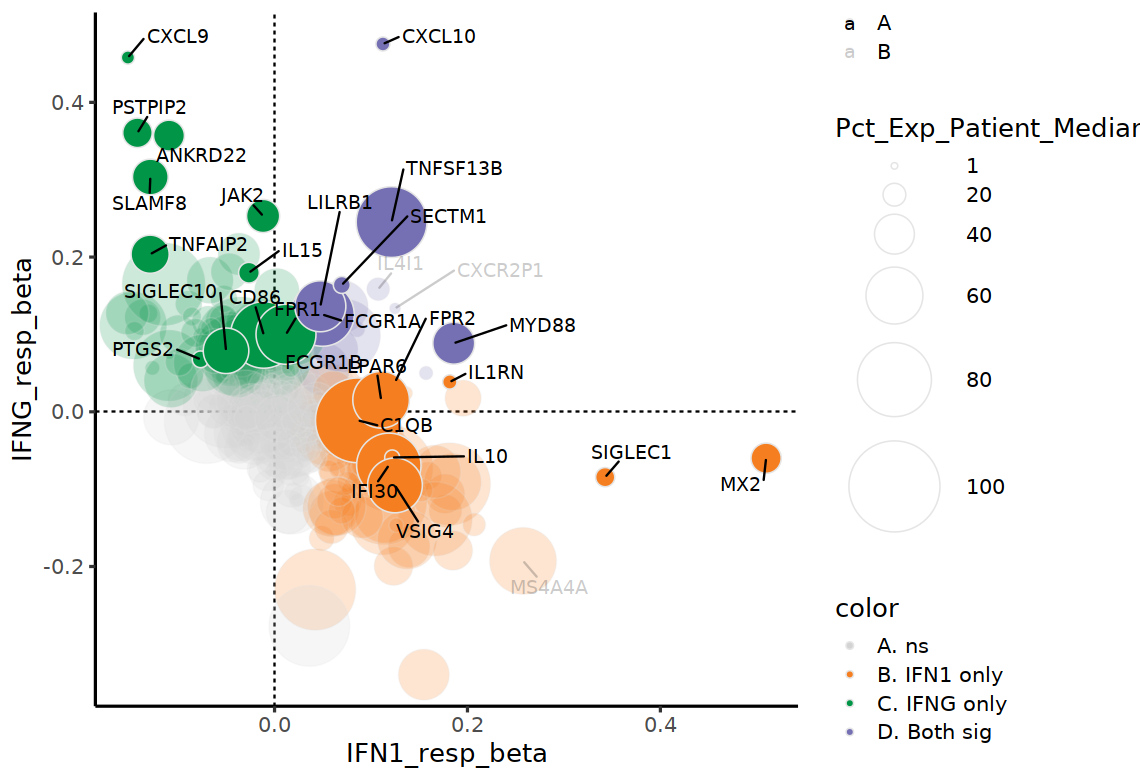

In [8]:
TAM = readRDS("../../Outputs/Manuscript_MixedEffects_Output_Stage_Corrected_EarlyLate/TAM_CytoSig_MixedEffects_Patient_Stage_Corrected_EarlyLate_Vargenes.RDS")
TAM = subset(TAM, gene %in% Reduced_TAM_cts)
TAM = left_join(TAM, TAM_stats, by = "gene")
head(TAM)

up_IFN1 = subset(TAM, IFN1_resp_p_adj_BH < 0.01 & IFN1_resp_beta > 0)$gene
up_IFNG = subset(TAM, IFNG_resp_p_adj_BH < 0.01 & IFNG_resp_beta > 0)$gene
up_IFN1_only = setdiff(up_IFN1, up_IFNG)
up_IFNG_only = setdiff(up_IFNG, up_IFN1)
up_both = intersect(up_IFN1, up_IFNG)
ns_IFN1 = subset(TAM, IFN1_resp_beta < 0 | (IFN1_resp_beta > 0 & IFN1_resp_p_adj_BH > 0.01))$gene
ns_IFNG = subset(TAM, IFNG_resp_beta < 0 | (IFNG_resp_beta > 0 & IFNG_resp_p_adj_BH > 0.01))$gene
ns_both = intersect(ns_IFN1, ns_IFNG)


TAM = mutate(TAM, color = ifelse(gene %in% ns_both,"A. ns",ifelse(gene %in% up_IFN1_only ,"B. IFN1 only",ifelse(gene %in% up_IFNG_only,"C. IFNG only",ifelse(gene %in% up_both ,"D. Both sig","None")))))
TAM = mutate(TAM, label = ifelse(gene %in% c(TAM_IFN1, TAM_IFNG) | IFN1_resp_beta > 0.25 | IFNG_resp_beta > 0.25 | IFN1_resp_beta > 0.1 & IFNG_resp_beta > 0.1 ,gene,""))
TAM = mutate(TAM, alpha = ifelse(gene %in% c(TAM_IFN1, TAM_IFNG),"A","B"))
#head(TAM)
table(TAM$color)

options(repr.plot.width=9.5, repr.plot.height=6.5)
ggplot(TAM %>% arrange(label), aes(y=IFNG_resp_beta, x=IFN1_resp_beta,label = label,fill = color,alpha = alpha)) + 
geom_vline(xintercept = 0,linetype = "dashed") +
geom_hline(yintercept = 0,linetype = "dashed")+
geom_point(aes(size = Pct_Exp_Patient_Median, alpha = alpha),shape = 21,color = "grey90") + theme_classic(base_size = 15) + 
scale_radius(range = c(1, 25),breaks = c(1,20,40,60,80,100),limits = c(0,100)) +
geom_text_repel(max.overlaps = Inf,box.padding = 0.7, color = "black",segment.color = "black") +
scale_alpha_manual(values = c(1, 0.2)) +
scale_fill_manual(values = c("lightgrey","#F57F20","#019547","#7570b3","black")) 
#ylim(c(-0.22,0.225)) +
#xlim(c(-0.075,0.17))
ggsave("../../Supp_Figures_Final/Figure_S10/FigureS10B_TAM_CTS_ISG_Scatter_w95_h65.pdf",width = 9.5, height = 6.5)

IFN1_resp_beta IFNG_resp_beta IFN1_resp_pval IFNG_resp_pval gene   
1 -0.12175930     0.42061864    6.628705e-18   4.719658e-185  C1S    
2  0.15440005     0.16976295    4.389826e-24    3.782746e-28  C1R    
3  0.02603952     0.18847867    8.423077e-02    6.915303e-35  CFB    
4 -0.02162656    -0.09366917    1.660030e-01    3.086750e-09  METTL7B
5  0.12004006    -0.16407332    1.908994e-15    7.422102e-27  PFKP   
6  0.03196427     0.09364651    4.425986e-02    5.765881e-09  SSPN   
  IFN1_resp_p_adj_BH IFNG_resp_p_adj_BH IFN1_resp_p_adj_Bonf
1 1.327463e-16       1.091657e-181      6.132878e-14        
2 1.153826e-22        2.447410e-26      4.061467e-20        
3 1.975420e-01        6.462665e-33      1.000000e+00        
4 3.305140e-01        4.504513e-08      1.000000e+00        
5 3.326179e-14        4.346157e-25      1.766201e-11        
6 1.194900e-01        8.094982e-08      1.000000e+00        
  IFNG_resp_p_adj_Bonf Total_Pct_Expressing Pct_Exp_Sample_Median
1 4.366628e-181        68.40028             45.00000             
2  3.499797e-24        61.18721             30.00000             
3  6.398038e-31        37.41970             38.41463             
4  2.855861e-05        24.02291             15.24390             
5  6.866928e-23        63.57867             73.03861             
6  5.334593e-05        43.43317             36.58537             
  Avg_Exp_Sample_Median Pct_Exp_Patient_Median Avg_Exp_Patient_Median
1 1.4542591             43.29268               1.3356231             
2 0.8917093             28.04878               0.8917093             
3 0.7813743             34.20765               0.7813743             
4 0.2502503             15.24390               0.2032726             
5 3.1827755             70.00000               3.1827755             
6 0.7837358             34.95245               0.7743827


       A. ns B. IFN1 only C. IFNG only  D. Both sig 
         350          186           41           13 

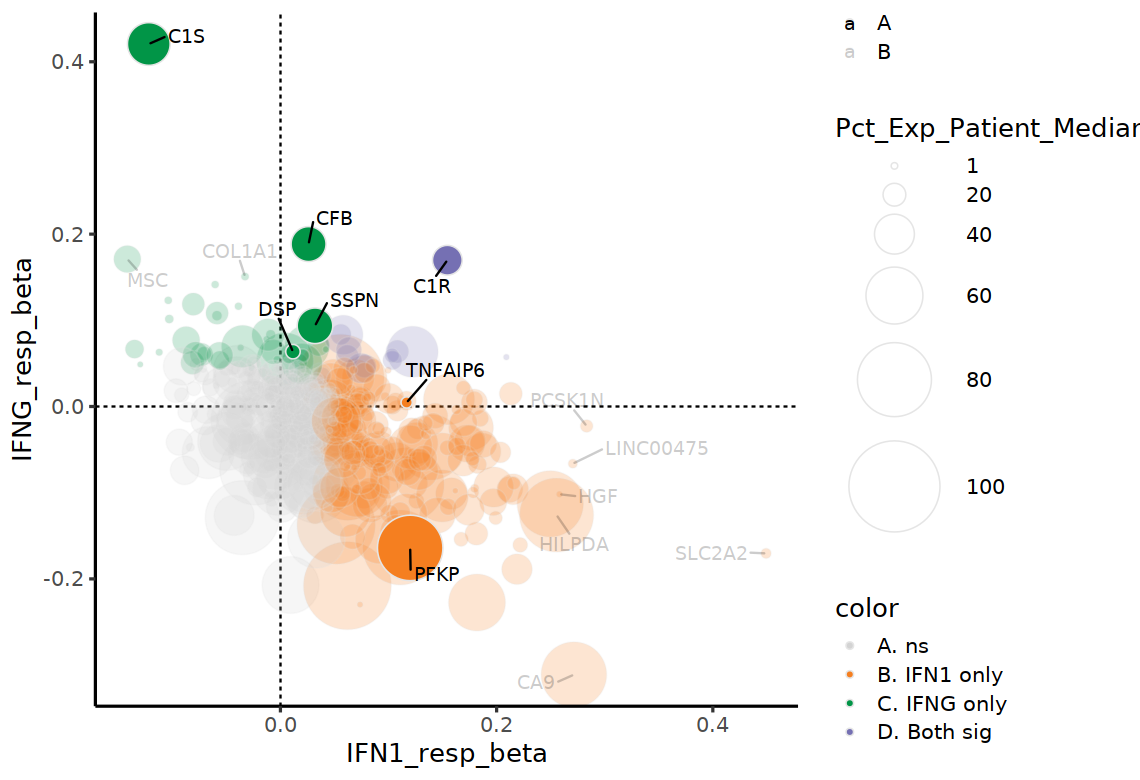

In [9]:
Tumor = readRDS("../../Outputs/Manuscript_MixedEffects_Output_Stage_Corrected_EarlyLate/Tumor_CytoSig_MixedEffects_Patient_Stage_Corrected_EarlyLate_Vargenes.RDS")
Tumor = subset(Tumor, gene %in% Reduced_Tumor_cts)
Tumor = left_join(Tumor, Tumor_stats, by = "gene")
head(Tumor)

up_IFN1 = subset(Tumor, IFN1_resp_p_adj_BH < 0.01 & IFN1_resp_beta > 0)$gene
up_IFNG = subset(Tumor, IFNG_resp_p_adj_BH < 0.01 & IFNG_resp_beta > 0)$gene
up_IFN1_only = setdiff(up_IFN1, up_IFNG)
up_IFNG_only = setdiff(up_IFNG, up_IFN1)
up_both = intersect(up_IFN1, up_IFNG)
ns_IFN1 = subset(Tumor, IFN1_resp_beta < 0 | (IFN1_resp_beta > 0 & IFN1_resp_p_adj_BH > 0.01))$gene
ns_IFNG = subset(Tumor, IFNG_resp_beta < 0 | (IFNG_resp_beta > 0 & IFNG_resp_p_adj_BH > 0.01))$gene
ns_both = intersect(ns_IFN1, ns_IFNG)


Tumor = mutate(Tumor, color = ifelse(gene %in% ns_both,"A. ns",ifelse(gene %in% up_IFN1_only ,"B. IFN1 only",ifelse(gene %in% up_IFNG_only,"C. IFNG only",ifelse(gene %in% up_both ,"D. Both sig","None")))))
Tumor = mutate(Tumor, label = ifelse(gene %in% c(Tumor_IFN1, Tumor_IFNG) | IFN1_resp_beta > 0.25 | IFNG_resp_beta > 0.15 | IFN1_resp_beta > 0.1 & IFNG_resp_beta > 0.1 ,gene,""))
Tumor = mutate(Tumor, alpha = ifelse(gene %in% c(Tumor_IFN1, Tumor_IFNG),"A","B"))
#head(Tumor)
table(Tumor$color)

options(repr.plot.width=9.5, repr.plot.height=6.5)
ggplot(Tumor %>% arrange(label), aes(y=IFNG_resp_beta, x=IFN1_resp_beta,label = label,fill = color,alpha = alpha)) + 
geom_vline(xintercept = 0,linetype = "dashed") +
geom_hline(yintercept = 0,linetype = "dashed")+
geom_point(aes(size = Pct_Exp_Patient_Median, alpha = alpha),shape = 21,color = "grey90") + theme_classic(base_size = 15) + 
scale_radius(range = c(1, 25),breaks = c(1,20,40,60,80,100),limits = c(0,100)) +
geom_text_repel(max.overlaps = Inf,box.padding = 0.7, color = "black",segment.color = "black") +
scale_alpha_manual(values = c(1, 0.2)) +
scale_fill_manual(values = c("lightgrey","#F57F20","#019547","#7570b3","black")) 
#ylim(c(-0.22,0.225)) +
#xlim(c(-0.075,0.17))
ggsave("../../Supp_Figures_Final/Figure_S10/FigureS10B_Tumor_CTS_ISG_Scatter_w95_h65.pdf",width = 9.5, height = 6.5)

### Score cells for expanded cell type-specific ISG signatures for visualization purposes <a name="2"></a>

### Rscripts/seur_full_notx_allstages_ISG_sigs_hacksig_zscore_expanded.R

In [ ]:
library(Seurat)
library(hacksig)
library(useful)

options(future.globals.maxSize= 100000*1024^2)

seur_full_notx_allstages = readRDS("/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/IFN_RCC_Manuscript_2024/Data_Objects/seur_full_BBK_notx_allstages_No_Omitted_Contam_Manuscript.RDS")
Idents(seur_full_notx_allstages) = "BBK_Broad_Celltype_DE"

ISG_sigs = readRDS("/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/IFN_RCC_Manuscript_2024/Signatures/ExpandedISG_50p_Final_Manuscript_Signatures_CTS_ISGs.RDS")
ISG_sigs$manuscript_myeloid_combined
ISG_sigs$manuscript_tumor_combined
ISG_sigs$manuscript_t_nk_combined

res = hack_sig(
  as.matrix(seur_full_notx_allstages@assays$RNA@data),
  signatures = ISG_sigs,
  method = "zscore")
head(res)

saveRDS(res, file = "/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/IFN_RCC_Manuscript_2024/Figures/Figure3/seur_full_notx_allstages_ISG_sigs_hacksig_zscore_expanded_scores.RDS")

### Define IFNG and IFN1 response high and low cells using CytoSig p-values for visualization purposes <a name="3"></a>

In [10]:
seur_full_notx_allstages = readRDS("../../Data_Objects/seur_full_BBK_notx_allstages_No_Omitted_Contam_Manuscript.RDS")
Idents(seur_full_notx_allstages) = "BBK_Broad_Celltype_DE"

### Add ISG signature scores to metadata

In [11]:
res = data.frame(readRDS("../../Figures/Figure3/seur_full_notx_allstages_ISG_sigs_hacksig_zscore_expanded_scores.RDS"))
res$barcode = res$sample_id
corner(res)

sample_id                   manuscript_IFN1_myeloid manuscript_IFN1_t_nk
1 GTTCTCGAGAGGTAGA-1.5pool1_2 -1.137770               -0.7190173          
2 CTAGAGTCATCAGTCA-1.5pool1_2 -0.896655               -1.6249262          
3 CGGCTAGAGGTAGCCA-1.5pool1_2 -1.137770               -1.6249262          
4 CTGCTGTAGTGTTTGC-1.5pool1_2 -1.137770               -1.6249262          
5 CCATGTCCATCGATGT-1.5pool1_2 -1.137770               -1.6249262          
  manuscript_IFN1_tumor manuscript_IFNG_myeloid
1  0.9040048            -0.9232331             
2  1.0402861            -0.9650270             
3 -0.4297300            -1.1841745             
4  3.3532442            -1.1841745             
5  2.2167324            -0.8357772

In [12]:
meta = seur_full_notx_allstages@meta.data
meta$barcode= row.names(meta)

meta_sig = left_join(meta, res, by = "barcode")
row.names(meta_sig) = row.names(meta)
corner(meta_sig)

seur_full_notx_allstages@meta.data = meta_sig

orig.ident    nCount_RNA nFeature_RNA Sample  
GTTCTCGAGAGGTAGA-1.5pool1_2 SeuratProject 17633      4215         5pool1_2
CTAGAGTCATCAGTCA-1.5pool1_2 SeuratProject 14519      4068         5pool1_2
CGGCTAGAGGTAGCCA-1.5pool1_2 SeuratProject 14443      3521         5pool1_2
CTGCTGTAGTGTTTGC-1.5pool1_2 SeuratProject 12982      3884         5pool1_2
CCATGTCCATCGATGT-1.5pool1_2 SeuratProject 12169      3542         5pool1_2
                            cell_id                    
GTTCTCGAGAGGTAGA-1.5pool1_2 GTTCTCGAGAGGTAGA-1.5pool1_2
CTAGAGTCATCAGTCA-1.5pool1_2 CTAGAGTCATCAGTCA-1.5pool1_2
CGGCTAGAGGTAGCCA-1.5pool1_2 CGGCTAGAGGTAGCCA-1.5pool1_2
CTGCTGTAGTGTTTGC-1.5pool1_2 CTGCTGTAGTGTTTGC-1.5pool1_2
CCATGTCCATCGATGT-1.5pool1_2 CCATGTCCATCGATGT-1.5pool1_2

In [13]:
subset(data.frame(table(colnames(seur_full_notx_allstages@meta.data))), Freq != 1)

Var1 Freq

### Add CytoSig scores to metadata

In [14]:
cytosig_binded_df = readRDS("../../Data_Objects/cytosig_binded_df_seur_full_notx_allstages.RDS")

length(intersect(row.names(cytosig_binded_df),row.names(seur_full_notx_allstages@meta.data)))
length(row.names(seur_full_notx_allstages@meta.data))

cytosig_binded_df_ordered = cytosig_binded_df[row.names(seur_full_notx_allstages@meta.data),]
dim(cytosig_binded_df_ordered)

[1] 143381

[1] 143381

[1] 143381     86

In [15]:
min(cytosig_binded_df_ordered)
max(cytosig_binded_df_ordered)

[1] -18.79981

[1] 23.98243

In [16]:
seur_full_notx_allstages@meta.data = cbind(seur_full_notx_allstages@meta.data, cytosig_binded_df_ordered)

### Define IFN1 and IFNG response high and low (CytoSig_Zscore > 0 and CytoSig_Pval < 0.05) 

In [17]:
metamut = seur_full_notx_allstages@meta.data

metamut = mutate(metamut, Figure3_IFN1_Pheno = ifelse(IFN1_CytoSig_Zscore > 0 & IFN1_CytoSig_Pval < 0.05, "IFN1_High",ifelse(IFN1_CytoSig_Zscore < 0 & IFN1_CytoSig_Pval < 0.05, "IFN1_Low","IFN1_NA")))
metamut = mutate(metamut, Figure3_IFNG_Pheno = ifelse(IFNG_CytoSig_Zscore > 0 & IFNG_CytoSig_Pval < 0.05, "IFNG_High",ifelse(IFNG_CytoSig_Zscore < 0 & IFNG_CytoSig_Pval < 0.05, "IFNG_Low","IFNG_NA")))

table(metamut$Figure3_IFN1_Pheno)
table(metamut$Figure3_IFNG_Pheno)

row.names(metamut) = row.names(seur_full_notx_allstages@meta.data)


IFN1_High  IFN1_Low   IFN1_NA 
    14668     16820    111893 


IFNG_High  IFNG_Low   IFNG_NA 
    18184     18861    106336 

In [18]:
seur_full_notx_allstages$Figure3_IFN1_Pheno = metamut$Figure3_IFN1_Pheno
seur_full_notx_allstages$Figure3_IFNG_Pheno = metamut$Figure3_IFNG_Pheno

In [19]:
plot_df_IFNG = subset(seur_full_notx_allstages,subset = Figure3_IFNG_Pheno != "IFNG_NA")@meta.data
plot_df_IFNG$Figure3_IFNG_Pheno = factor(plot_df_IFNG$Figure3_IFNG_Pheno, levels = c("IFNG_Low","IFNG_High"))

plot_df_IFN1 = subset(seur_full_notx_allstages,subset = Figure3_IFN1_Pheno != "IFN1_NA")@meta.data
plot_df_IFN1$Figure3_IFN1_Pheno = factor(plot_df_IFN1$Figure3_IFN1_Pheno, levels = c("IFN1_Low","IFN1_High"))

### Supp Fig 10A. Heatmap of type I and type II expanded cell type-specific ISGs <a name="4"></a>

In [20]:
ISG_sigs = readRDS("../../Signatures/ExpandedISG_50p_Final_Manuscript_Signatures_CTS_ISGs_FigureS10.RDS")

In [21]:
celltype_cols = readRDS(file = "../../Data_Objects//celltype_cols.RDS")
celltype_cols

celltype_cols_DE = celltype_cols
names(celltype_cols_DE) = replace(names(celltype_cols_DE), names(celltype_cols_DE) == "Perivascular cell","Perivascular.and.Fibroblast")
celltype_cols_DE = celltype_cols_DE[unique(as.character(seur_full_notx_allstages@meta.data$BBK_Broad_Celltype_DE))]
celltype_cols_DE["Perivascular.and.Fibroblast"] = "#766458"
celltype_cols_DE

Tumor               TAM               CD8       Plasma cell 
        "#A0BAAC"         "#7FC97F"         "#C2AFCE"         "#E4B9A3" 
               DC       Endothelial          T-Helper                NK 
        "#FDC988"         "#FEEB93"         "#D1DD9E"         "#658DAA" 
         Monocyte             T-reg            B cell       CD8 NK-like 
        "#704BA0"         "#D31286"         "#DD2456"         "#C2541E" 
       Fibroblast Perivascular cell            Contam           Omitted 
        "#95603B"         "#666666"          "grey95"          "grey95"

Tumor                    Monocyte 
                  "#A0BAAC"                   "#704BA0" 
                        TAM                         CD8 
                  "#7FC97F"                   "#C2AFCE" 
                Plasma cell                 CD8 NK-like 
                  "#E4B9A3"                   "#C2541E" 
                         DC                 Endothelial 
                  "#FDC988"                   "#FEEB93" 
                      T-reg                          NK 
                  "#D31286"                   "#658DAA" 
                   T-Helper                      B cell 
                  "#D1DD9E"                   "#DD2456" 
                       <NA> Perivascular.and.Fibroblast 
                         NA                   "#766458"

In [22]:
Idents(seur_full_notx_allstages) = "BBK_Broad_Celltype_DE"
seur_full_notx_allstages = RenameIdents(seur_full_notx_allstages,"Perivascular_and_Fibroblast"="Perivascular.and.Fibroblast")
Idents(seur_full_notx_allstages) = factor(Idents(seur_full_notx_allstages), levels = c("Tumor","Perivascular.and.Fibroblast","Endothelial","TAM","Monocyte","DC","CD8","CD8 NK-like","NK","T-Helper","T-reg","B cell","Plasma cell"))
seur_full_notx_allstages$BBK_Broad_Celltype_DE = Idents(seur_full_notx_allstages)

table(Idents(seur_full_notx_allstages))
table(seur_full_notx_allstages$BBK_Broad_Celltype_DE)


                      Tumor Perivascular.and.Fibroblast 
                      12921                         786 
                Endothelial                         TAM 
                       1127                       13929 
                   Monocyte                          DC 
                      11243                        2580 
                        CD8                 CD8 NK-like 
                      51211                       10928 
                         NK                    T-Helper 
                      17431                       14026 
                      T-reg                      B cell 
                       5106                        1592 
                Plasma cell 
                        501 


                      Tumor Perivascular.and.Fibroblast 
                      12921                         786 
                Endothelial                         TAM 
                       1127                       13929 
                   Monocyte                          DC 
                      11243                        2580 
                        CD8                 CD8 NK-like 
                      51211                       10928 
                         NK                    T-Helper 
                      17431                       14026 
                      T-reg                      B cell 
                       5106                        1592 
                Plasma cell 
                        501 

Centering and scaling data matrix



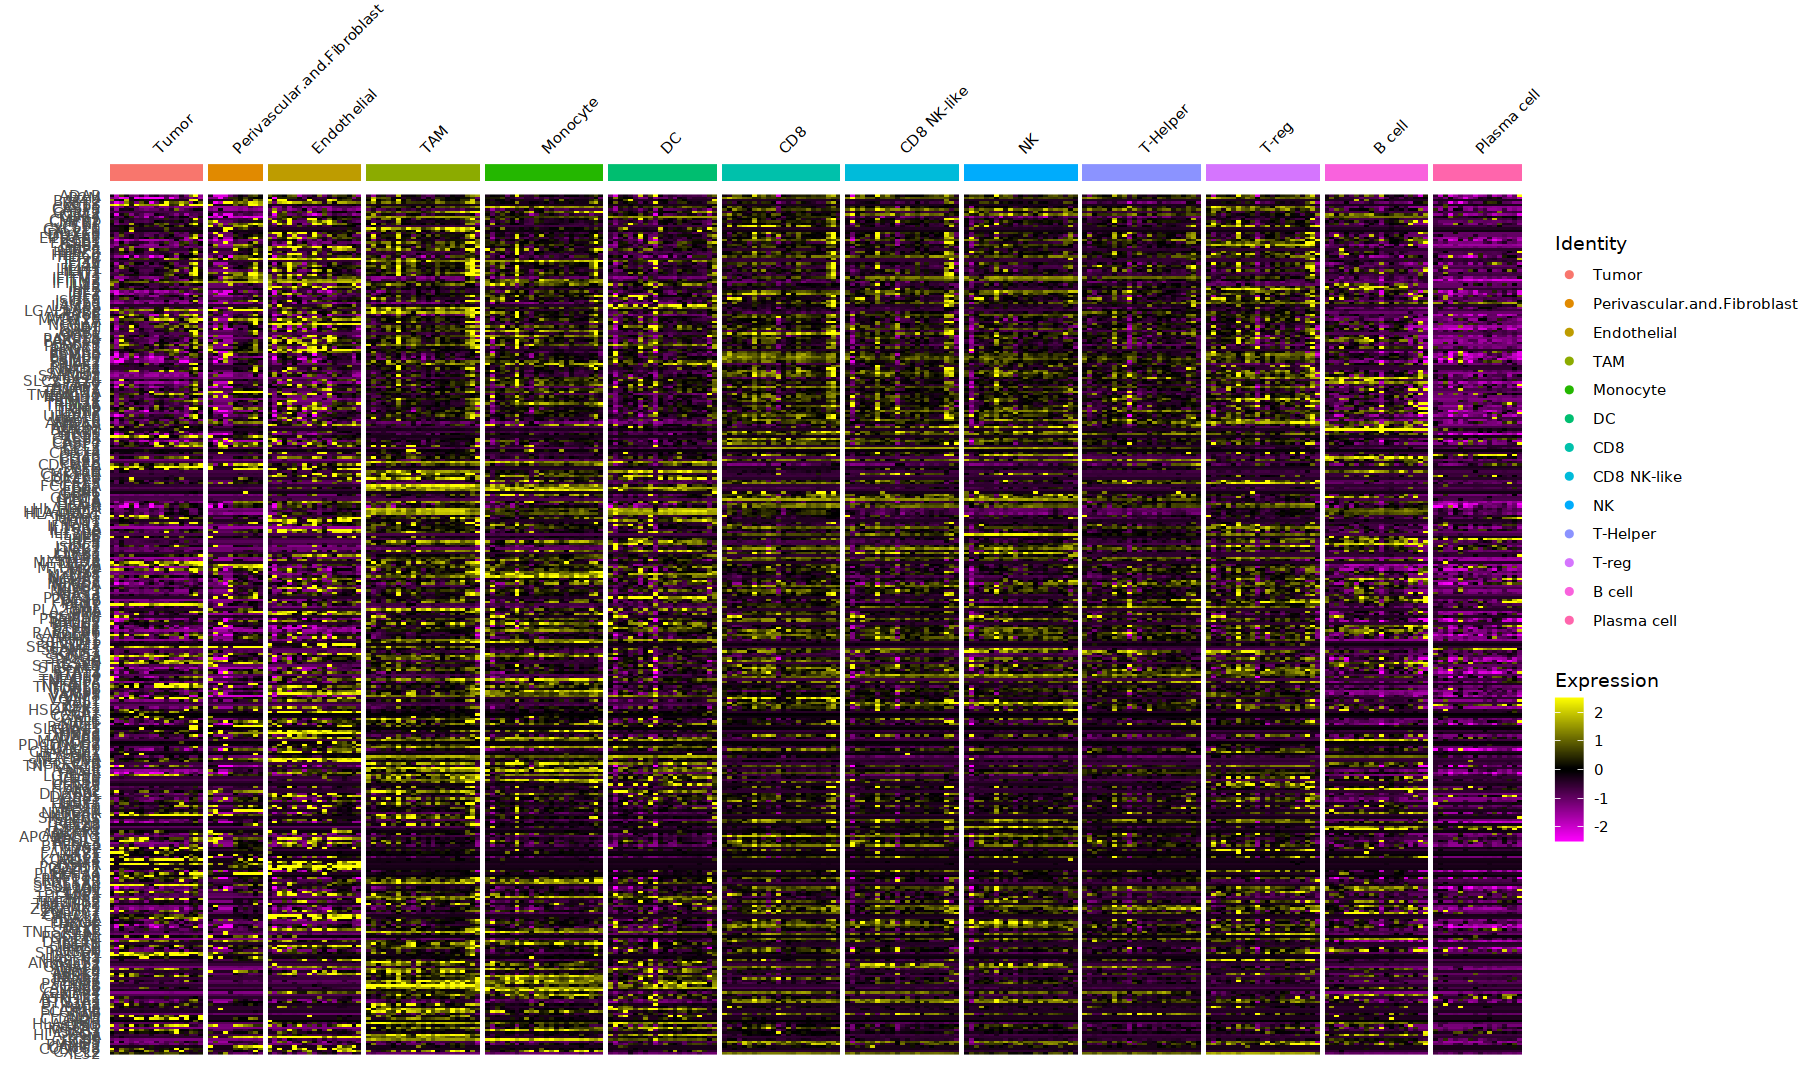

In [23]:
options(repr.plot.width=15, repr.plot.height=9)

seur_full_notx_allstages$Sample = factor(seur_full_notx_allstages$Sample)
seur_full_notx_allstages$Cohort = factor(seur_full_notx_allstages$Cohort)

seur_full_notx_allstages$BBK_Broad_Celltype_DE_Sample = paste(seur_full_notx_allstages$BBK_Broad_Celltype_DE,seur_full_notx_allstages$Sample,sep = "_")

cluster.averages <- AverageExpression(seur_full_notx_allstages, return.seurat = TRUE, group.by = c("BBK_Broad_Celltype_DE","Sample"))
Idents(cluster.averages) = factor(Idents(cluster.averages), levels = levels(Idents(seur_full_notx_allstages)))

DoHeatmap(cluster.averages, features = intersect(goi, row.names(seur_full_notx_allstages@assays$RNA@data)), size = 3, 
    draw.lines = TRUE)

In [24]:
head(cluster.averages@meta.data)
cluster.averages$BBK_Broad_Celltype_DE_Sample = row.names(cluster.averages@meta.data)
cluster.averages@meta.data = left_join(cluster.averages@meta.data, distinct(seur_full_notx_allstages@meta.data[,c("Cohort","Sample","Stage_Corrected","Biopsy","IO_Treated","BBK_Broad_Celltype_DE_Sample","BBK_Broad_Celltype_DE")]),by = "BBK_Broad_Celltype_DE_Sample")
row.names(cluster.averages@meta.data) = cluster.averages$BBK_Broad_Celltype_DE_Sample
head(cluster.averages@meta.data)

orig.ident nCount_RNA nFeature_RNA
Tumor_5pool1_2           Tumor      10000      18069       
Tumor_Bi_0600916_T1      Tumor      10000       3093       
Tumor_Bi_DFCI_0600876_T1 Tumor      10000      21445       
Tumor_Bi_DFCI_0600890_T1 Tumor      10000      25586       
Tumor_Pool70-10          Tumor      10000      12026       
Tumor_Pool70-6           Tumor      10000      16561

orig.ident nCount_RNA nFeature_RNA
Tumor_5pool1_2           Tumor      10000      18069       
Tumor_Bi_0600916_T1      Tumor      10000       3093       
Tumor_Bi_DFCI_0600876_T1 Tumor      10000      21445       
Tumor_Bi_DFCI_0600890_T1 Tumor      10000      25586       
Tumor_Pool70-10          Tumor      10000      12026       
Tumor_Pool70-6           Tumor      10000      16561       
                         BBK_Broad_Celltype_DE_Sample Cohort Sample            
Tumor_5pool1_2           Tumor_5pool1_2               Braun  5pool1_2          
Tumor_Bi_0600916_T1      Tumor_Bi_0600916_T1          Bi     Bi_0600916_T1     
Tumor_Bi_DFCI_0600876_T1 Tumor_Bi_DFCI_0600876_T1     Bi     Bi_DFCI_0600876_T1
Tumor_Bi_DFCI_0600890_T1 Tumor_Bi_DFCI_0600890_T1     Bi     Bi_DFCI_0600890_T1
Tumor_Pool70-10          Tumor_Pool70-10              Braun  Pool70-10         
Tumor_Pool70-6           Tumor_Pool70-6               Braun  Pool70-6          
                         Stage_Corrected Biopsy     IO_Treated
Tumor_5pool1_2           I               Kidney     IO Naive  
Tumor_Bi_0600916_T1      IV              Lymph_node IO Naive  
Tumor_Bi_DFCI_0600876_T1 IV              Kidney     IO Naive  
Tumor_Bi_DFCI_0600890_T1 I               Kidney     IO Naive  
Tumor_Pool70-10          IV              Adrenal    IO Naive  
Tumor_Pool70-6           I               Kidney     IO Naive  
                         BBK_Broad_Celltype_DE
Tumor_5pool1_2           Tumor                
Tumor_Bi_0600916_T1      Tumor                
Tumor_Bi_DFCI_0600876_T1 Tumor                
Tumor_Bi_DFCI_0600890_T1 Tumor                
Tumor_Pool70-10          Tumor                
Tumor_Pool70-6           Tumor

In [25]:
ISG_sigs_plot = unique(c(ISG_sigs$manuscript_IFNG_tumor,ISG_sigs$manuscript_IFN1_tumor,ISG_sigs$manuscript_IFNG_myeloid,ISG_sigs$manuscript_IFN1_myeloid,ISG_sigs$manuscript_IFNG_t_nk,ISG_sigs$manuscript_IFN1_t_nk))
ISG_sigs_plot

[1] "C1S"      "C1R"      "CFB"      "SSPN"     "DSP"      "PFKP"    
 [7] "TNFAIP6"  "CD86"     "FCGR1A"   "FPR1"     "MYD88"    "SIGLEC10"
[13] "LILRB1"   "TNFSF13B" "SLAMF8"   "ANKRD22"  "PSTPIP2"  "FCGR1B"  
[19] "SECTM1"   "JAK2"     "CXCL10"   "CXCL9"    "TNFAIP2"  "PTGS2"   
[25] "IL15"     "GCH1"     "FPR2"     "MX2"      "LAMP3"    "NFKB1"   
[31] "IFI30"    "LPAR6"    "VSIG4"    "IL10"     "IL1RN"    "C1QB"    
[37] "SIGLEC1"  "CCL5"     "GZMA"     "IL2RB"    "NLRC5"    "OASL"    
[43] "STAT4"    "SOCS1"    "XCL1"

In [26]:
setdiff(ISG_sigs$manuscript_IFNG_tumor,ISG_sigs$manuscript_IFN1_tumor)
setdiff(ISG_sigs$manuscript_IFN1_tumor,ISG_sigs$manuscript_IFNG_tumor)
intersect(ISG_sigs$manuscript_IFN1_tumor,ISG_sigs$manuscript_IFNG_tumor)

tumor_ISGs = c(setdiff(ISG_sigs$manuscript_IFNG_tumor,ISG_sigs$manuscript_IFN1_tumor),setdiff(ISG_sigs$manuscript_IFN1_tumor,ISG_sigs$manuscript_IFNG_tumor),intersect(ISG_sigs$manuscript_IFN1_tumor,ISG_sigs$manuscript_IFNG_tumor))
tumor_ISGs

[1] "C1S"  "CFB"  "SSPN" "DSP"

[1] "PFKP"    "TNFAIP6"

[1] "C1R"

[1] "C1S"     "CFB"     "SSPN"    "DSP"     "PFKP"    "TNFAIP6" "C1R"

In [27]:
setdiff(ISG_sigs$manuscript_IFNG_myeloid,ISG_sigs$manuscript_IFN1_myeloid)
setdiff(ISG_sigs$manuscript_IFN1_myeloid,ISG_sigs$manuscript_IFNG_myeloid)
intersect(ISG_sigs$manuscript_IFN1_myeloid,ISG_sigs$manuscript_IFNG_myeloid)

myeloid_ISGs = c(setdiff(ISG_sigs$manuscript_IFNG_myeloid,ISG_sigs$manuscript_IFN1_myeloid),setdiff(ISG_sigs$manuscript_IFN1_myeloid,ISG_sigs$manuscript_IFNG_myeloid),intersect(ISG_sigs$manuscript_IFN1_myeloid,ISG_sigs$manuscript_IFNG_myeloid))
myeloid_ISGs

[1] "FPR1"    "SLAMF8"  "PSTPIP2" "FCGR1B"  "JAK2"    "CXCL9"   "TNFAIP2"
 [8] "PTGS2"   "IL15"    "LAMP3"   "NFKB1"

[1] "IFI30"   "LPAR6"   "VSIG4"   "IL10"    "IL1RN"   "C1QB"    "SIGLEC1"

[1] "FCGR1A"   "MYD88"    "LILRB1"   "TNFSF13B" "SECTM1"   "MX2"     
 [7] "FPR2"     "CXCL10"   "CD86"     "GCH1"     "SIGLEC10" "ANKRD22"

[1] "FPR1"     "SLAMF8"   "PSTPIP2"  "FCGR1B"   "JAK2"     "CXCL9"   
 [7] "TNFAIP2"  "PTGS2"    "IL15"     "LAMP3"    "NFKB1"    "IFI30"   
[13] "LPAR6"    "VSIG4"    "IL10"     "IL1RN"    "C1QB"     "SIGLEC1" 
[19] "FCGR1A"   "MYD88"    "LILRB1"   "TNFSF13B" "SECTM1"   "MX2"     
[25] "FPR2"     "CXCL10"   "CD86"     "GCH1"     "SIGLEC10" "ANKRD22"

In [28]:
setdiff(ISG_sigs$manuscript_IFNG_t_nk,ISG_sigs$manuscript_IFN1_t_nk)
setdiff(ISG_sigs$manuscript_IFN1_t_nk,ISG_sigs$manuscript_IFNG_t_nk)
intersect(ISG_sigs$manuscript_IFN1_t_nk,ISG_sigs$manuscript_IFNG_t_nk)

t_nk_ISGs = c(setdiff(ISG_sigs$manuscript_IFNG_t_nk,ISG_sigs$manuscript_IFN1_t_nk),setdiff(ISG_sigs$manuscript_IFN1_t_nk,ISG_sigs$manuscript_IFNG_t_nk),intersect(ISG_sigs$manuscript_IFN1_t_nk,ISG_sigs$manuscript_IFNG_t_nk))
t_nk_ISGs

[1] "SOCS1"

[1] "XCL1"

[1] "NLRC5" "OASL"  "IL2RB" "GZMA"  "STAT4" "CCL5"

[1] "SOCS1" "XCL1"  "NLRC5" "OASL"  "IL2RB" "GZMA"  "STAT4" "CCL5"

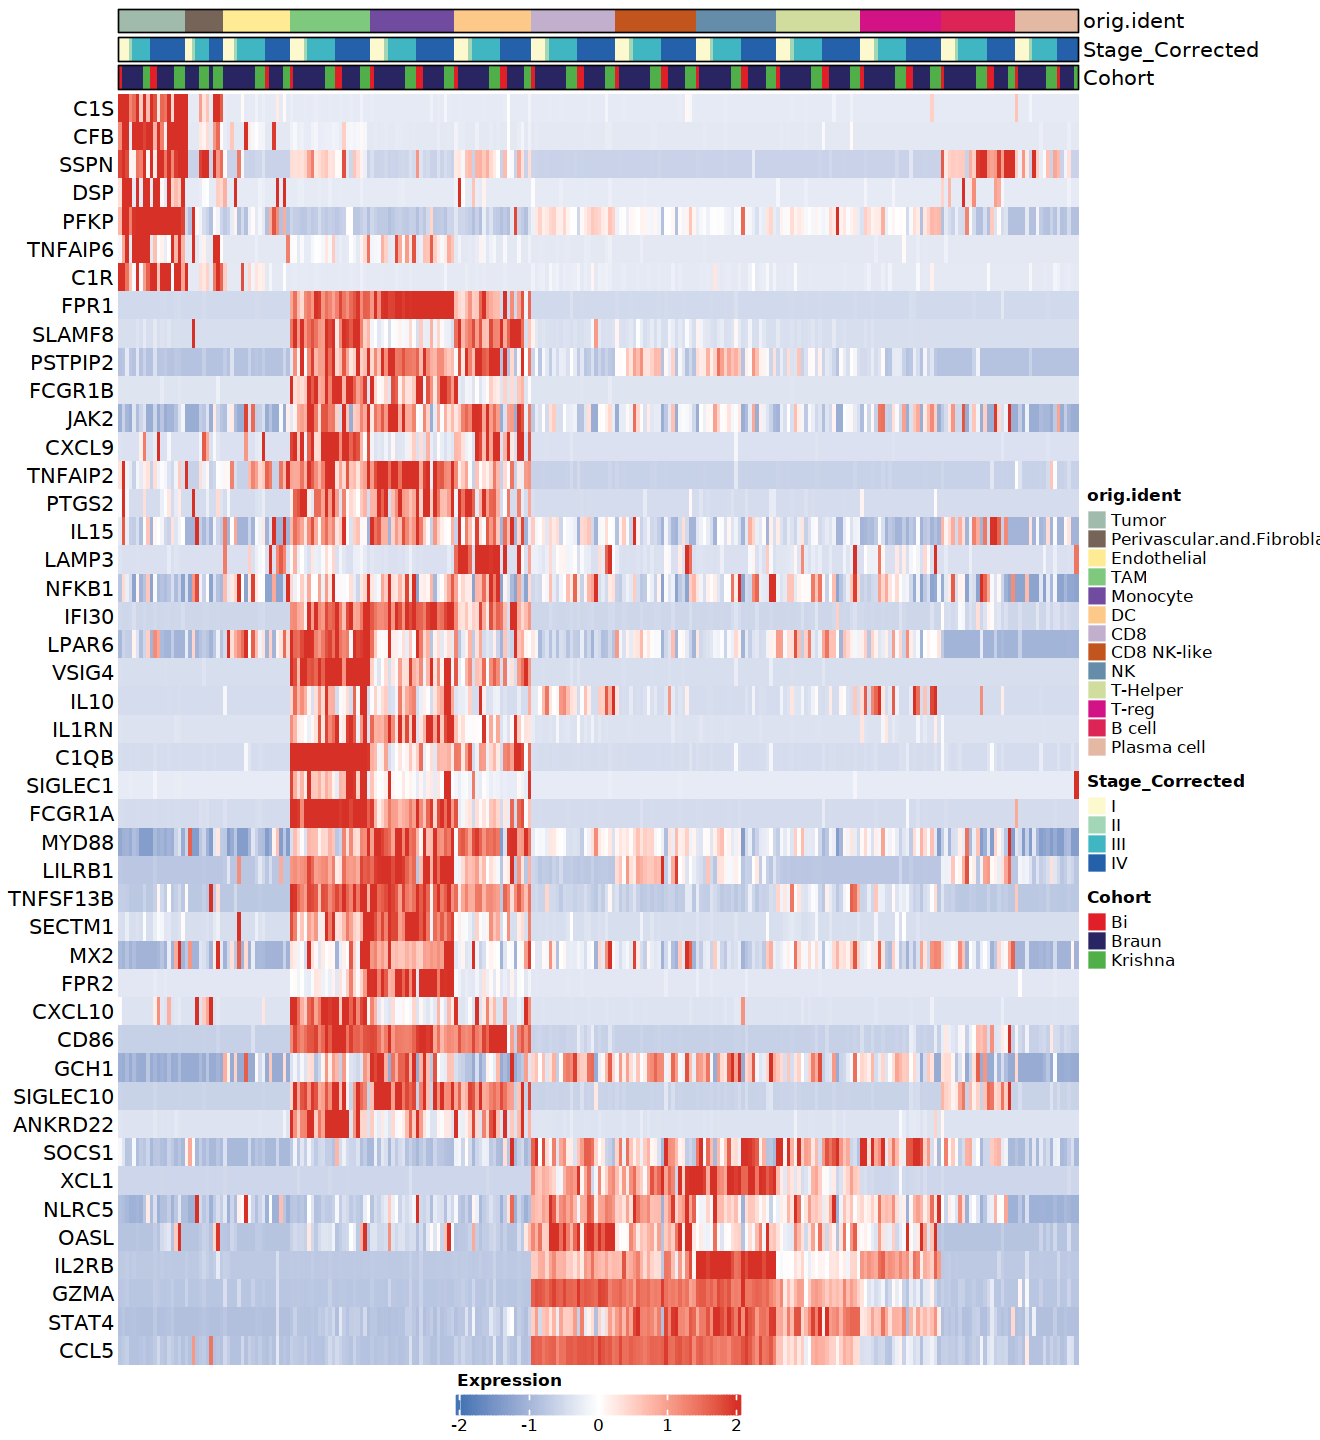

In [29]:
cluster.averages$orig.ident = factor(cluster.averages$orig.ident, levels = c("Tumor","Perivascular.and.Fibroblast","Endothelial","TAM","Monocyte","DC","CD8","CD8 NK-like","NK","T-Helper","T-reg","B cell","Plasma cell"))

options(repr.plot.width=11, repr.plot.height=12)
colors <- list(celltype_cols_DE[levels(cluster.averages$orig.ident)], c("#FCF9CF","#A3D6B4","#41B6C3","#2560AA"),c("#E11F28","#292562","#50AF48"))

DefaultAssay(cluster.averages) = "RNA"
plot_heatmap(dataset = cluster.averages, 
              markers = c(tumor_ISGs, myeloid_ISGs, t_nk_ISGs),
              sort_var = c("orig.ident","Stage_Corrected","Cohort"),
              anno_var = c("orig.ident","Stage_Corrected","Cohort"),
              anno_colors = colors)

In [30]:
pdf("../../Supp_Figures_Final/Figure_S10/FigureS10A_Expanded_ISGs_Heatmap.pdf", width = 10, height = 7, useDingbats = F)

cluster.averages$orig.ident = factor(cluster.averages$orig.ident, levels = c("Tumor","Perivascular.and.Fibroblast","Endothelial","TAM","Monocyte","DC","CD8","CD8 NK-like","NK","T-Helper","T-reg","B cell","Plasma cell"))

options(repr.plot.width=11, repr.plot.height=12)
colors <- list(celltype_cols_DE[levels(cluster.averages$orig.ident)], c("#FCF9CF","#A3D6B4","#41B6C3","#2560AA"),c("#E11F28","#292562","#50AF48"))

DefaultAssay(cluster.averages) = "RNA"
plot_heatmap(dataset = cluster.averages, 
              markers = c(tumor_ISGs, myeloid_ISGs, t_nk_ISGs),
              sort_var = c("orig.ident","Stage_Corrected","Cohort"),
              anno_var = c("orig.ident","Stage_Corrected","Cohort"),
              anno_colors = colors)

dev.off()

pdf 
  2

### Make heatmap of expanded ISG signature scores

In [31]:
meta = seur_full_notx_allstages@meta.data

agg_tbl <- meta %>% group_by(BBK_Broad_Celltype_DE_Sample) %>% 
  summarise(median_manuscript_IFNG_tumor=median(manuscript_IFNG_tumor),
            median_manuscript_IFNG_myeloid=median(manuscript_IFNG_myeloid),
            median_manuscript_IFNG_t_nk=median(manuscript_IFNG_t_nk),
            median_manuscript_IFN1_tumor=median(manuscript_IFN1_tumor),
            median_manuscript_IFN1_myeloid=median(manuscript_IFN1_myeloid),
            median_manuscript_IFN1_t_nk=median(manuscript_IFN1_t_nk),
            .groups = 'drop')

In [32]:
head(agg_tbl)
length(intersect(agg_tbl$BBK_Broad_Celltype_DE_Sample,row.names(cluster.averages@meta.data)))

agg_tbl = data.frame(agg_tbl)
row.names(agg_tbl) = agg_tbl$BBK_Broad_Celltype_DE_Sample

agg_tbl = agg_tbl[row.names(cluster.averages@meta.data),]
head(agg_tbl)

BBK_Broad_Celltype_DE_Sample median_manuscript_IFNG_tumor
1 B cell_5pool1_2              -0.4307583                  
2 B cell_Bi_0600916_T1         -0.4307583                  
3 B cell_Bi_DFCI_0600876_T1    -0.4307583                  
4 B cell_Bi_DFCI_0600890_T1    -0.4307583                  
5 B cell_Pool70-10             -0.4307583                  
6 B cell_Pool70-6              -0.4307583                  
  median_manuscript_IFNG_myeloid median_manuscript_IFNG_t_nk
1 -1.1841745                     -1.681933                  
2 -0.6950739                     -1.681933                  
3 -0.4278448                     -1.681933                  
4 -1.1841745                     -1.681933                  
5 -0.2860416                     -1.456024                  
6 -1.1841745                     -1.681933                  
  median_manuscript_IFN1_tumor median_manuscript_IFN1_myeloid
1 -0.42973                     -1.1377696                    
2 -0.42973                     -0.5996420                    
3 -0.42973                     -0.4976214                    
4 -0.42973                     -1.1377696                    
5 -0.42973                     -0.6292363                    
6 -0.42973                     -1.1377696                    
  median_manuscript_IFN1_t_nk
1 -1.624926                  
2 -1.624926                  
3 -1.624926                  
4 -1.624926                  
5 -1.624926                  
6 -1.624926

[1] 274

BBK_Broad_Celltype_DE_Sample
Tumor_5pool1_2           Tumor_5pool1_2              
Tumor_Bi_0600916_T1      Tumor_Bi_0600916_T1         
Tumor_Bi_DFCI_0600876_T1 Tumor_Bi_DFCI_0600876_T1    
Tumor_Bi_DFCI_0600890_T1 Tumor_Bi_DFCI_0600890_T1    
Tumor_Pool70-10          Tumor_Pool70-10             
Tumor_Pool70-6           Tumor_Pool70-6              
                         median_manuscript_IFNG_tumor
Tumor_5pool1_2            3.0534422                  
Tumor_Bi_0600916_T1       3.7086855                  
Tumor_Bi_DFCI_0600876_T1 -0.4307583                  
Tumor_Bi_DFCI_0600890_T1  2.7803555                  
Tumor_Pool70-10          -0.4307583                  
Tumor_Pool70-6            2.3615383                  
                         median_manuscript_IFNG_myeloid
Tumor_5pool1_2           -0.2799583                    
Tumor_Bi_0600916_T1      -1.1841745                    
Tumor_Bi_DFCI_0600876_T1 -1.1841745                    
Tumor_Bi_DFCI_0600890_T1 -1.1841745                    
Tumor_Pool70-10          -1.1841745                    
Tumor_Pool70-6           -1.1841745                    
                         median_manuscript_IFNG_t_nk
Tumor_5pool1_2           -1.681933                  
Tumor_Bi_0600916_T1      -1.681933                  
Tumor_Bi_DFCI_0600876_T1 -1.681933                  
Tumor_Bi_DFCI_0600890_T1 -1.681933                  
Tumor_Pool70-10          -1.681933                  
Tumor_Pool70-6           -1.681933                  
                         median_manuscript_IFN1_tumor
Tumor_5pool1_2            1.703319                   
Tumor_Bi_0600916_T1       2.372979                   
Tumor_Bi_DFCI_0600876_T1 -0.429730                   
Tumor_Bi_DFCI_0600890_T1  1.510535                   
Tumor_Pool70-10          -0.429730                   
Tumor_Pool70-6            1.506469                   
                         median_manuscript_IFN1_myeloid
Tumor_5pool1_2           -1.13777                      
Tumor_Bi_0600916_T1      -1.13777                      
Tumor_Bi_DFCI_0600876_T1 -1.13777                      
Tumor_Bi_DFCI_0600890_T1 -1.13777                      
Tumor_Pool70-10          -1.13777                      
Tumor_Pool70-6           -1.13777                      
                         median_manuscript_IFN1_t_nk
Tumor_5pool1_2           -1.624926                  
Tumor_Bi_0600916_T1      -1.624926                  
Tumor_Bi_DFCI_0600876_T1 -1.624926                  
Tumor_Bi_DFCI_0600890_T1 -1.624926                  
Tumor_Pool70-10          -1.624926                  
Tumor_Pool70-6           -1.624926

In [33]:
setequal(cluster.averages$BBK_Broad_Celltype_DE_Sample, agg_tbl$BBK_Broad_Celltype_DE_Sample)

[1] TRUE

In [34]:
cluster.averages$median_manuscript_IFNG_tumor = agg_tbl$median_manuscript_IFNG_tumor
cluster.averages$median_manuscript_IFNG_myeloid = agg_tbl$median_manuscript_IFNG_myeloid
cluster.averages$median_manuscript_IFNG_t_nk= agg_tbl$median_manuscript_IFNG_t_nk

cluster.averages$median_manuscript_IFN1_tumor = agg_tbl$median_manuscript_IFN1_tumor
cluster.averages$median_manuscript_IFN1_myeloid = agg_tbl$median_manuscript_IFN1_myeloid
cluster.averages$median_manuscript_IFN1_t_nk= agg_tbl$median_manuscript_IFN1_t_nk

In [35]:
sigmat = as.matrix(data.frame(t(scale(cluster.averages@meta.data[,c("median_manuscript_IFNG_tumor","median_manuscript_IFNG_myeloid","median_manuscript_IFNG_t_nk","median_manuscript_IFN1_tumor","median_manuscript_IFN1_myeloid","median_manuscript_IFN1_t_nk")])), check.names = F))
length(intersect(colnames(sigmat), row.names(cluster.averages@meta.data)))
setdiff(colnames(sigmat), row.names(cluster.averages@meta.data))
setdiff(row.names(cluster.averages@meta.data),colnames(sigmat))

[1] 274

character(0)

character(0)

In [36]:
cluster.averages@assays$RNA@data = sigmat
cluster.averages@assays$RNA@scale.data = sigmat
corner(cluster.averages@assays$RNA@scale.data)

Tumor_5pool1_2 Tumor_Bi_0600916_T1
median_manuscript_IFNG_tumor    2.7798506      3.3549928         
median_manuscript_IFNG_myeloid -0.1681548     -0.7083335         
median_manuscript_IFNG_t_nk    -0.8459841     -0.8459841         
median_manuscript_IFN1_tumor    2.5394661      3.4282721         
median_manuscript_IFN1_myeloid -0.6253220     -0.6253220         
                               Tumor_Bi_DFCI_0600876_T1
median_manuscript_IFNG_tumor   -0.2784196              
median_manuscript_IFNG_myeloid -0.7083335              
median_manuscript_IFNG_t_nk    -0.8459841              
median_manuscript_IFN1_tumor   -0.2916226              
median_manuscript_IFN1_myeloid -0.6253220              
                               Tumor_Bi_DFCI_0600890_T1 Tumor_Pool70-10
median_manuscript_IFNG_tumor    2.5401477               -0.2784196     
median_manuscript_IFNG_myeloid -0.7083335               -0.7083335     
median_manuscript_IFNG_t_nk    -0.8459841               -0.8459841     
median_manuscript_IFN1_tumor    2.2835929               -0.2916226     
median_manuscript_IFN1_myeloid -0.6253220               -0.6253220

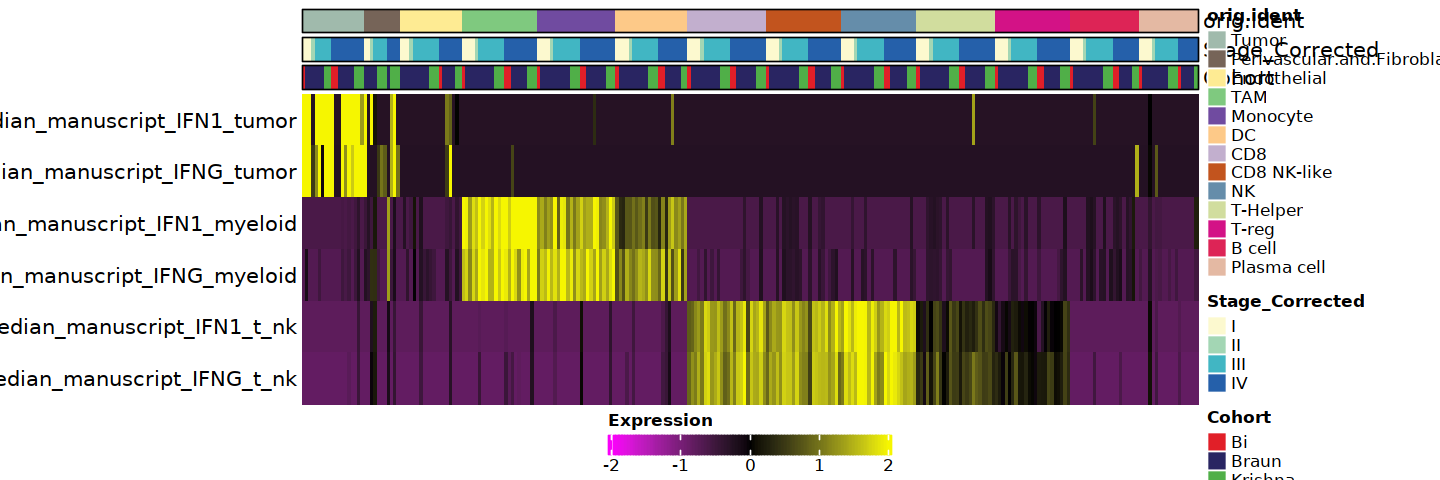

In [37]:
cluster.averages$orig.ident = factor(cluster.averages$orig.ident, levels = c("Tumor","Perivascular.and.Fibroblast","Endothelial","TAM","Monocyte","DC","CD8","CD8 NK-like","NK","T-Helper","T-reg","B cell","Plasma cell"))

options(repr.plot.width=12, repr.plot.height=4)
colors <- list(celltype_cols_DE[levels(cluster.averages$orig.ident)], c("#FCF9CF","#A3D6B4","#41B6C3","#2560AA"),c("#E11F28","#292562","#50AF48"))

DefaultAssay(cluster.averages) = "RNA"
plot_heatmap(dataset = cluster.averages, 
              markers = c("median_manuscript_IFN1_tumor","median_manuscript_IFNG_tumor","median_manuscript_IFN1_myeloid","median_manuscript_IFNG_myeloid","median_manuscript_IFN1_t_nk","median_manuscript_IFNG_t_nk"),
              sort_var = c("orig.ident","Stage_Corrected","Cohort"),
              anno_var = c("orig.ident","Stage_Corrected","Cohort"),
              anno_colors = colors,hm_colors = c("#F900F9","black","#F6F600"))

### Supp Fig 10C-D. Violin plots of expanded ISG signature scores in IFN1 and IFNG response high and low cells in samples from treated patients<a name="5"></a>

### Score cells from treated patients with expanded ISG signatures

### Rscripts/seur_full_treated_ISG_Sigs_hacksig_zscore.R

In [ ]:
library(Seurat)
library(hacksig)
library(useful)

options(future.globals.maxSize= 100000*1024^2)

seur_full = readRDS("/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/IFN_RCC_Manuscript_2024/Data_Objects/seur_full_BBK_Manuscript.RDS")
Idents(seur_full) = "BBK_Broad_Celltype_DE"

seur_full = subset(seur_full, idents = c("Contam","Omitted"), invert = T)

seur_full_treated = subset(seur_full, subset = IO_Treated == "IO Exposed" )
seur_full_treated

ISG_sigs = readRDS("/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/IFN_RCC_Manuscript_2024/Signatures/ExpandedISG_50p_Final_Manuscript_Signatures_CTS_ISGs.RDS")
ISG_sigs$manuscript_myeloid_combined
ISG_sigs$manuscript_tumor_combined
ISG_sigs$manuscript_t_nk_combined

res = hack_sig(
  as.matrix(seur_full_treated@assays$RNA@data),
  signatures = ISG_sigs,
  method = "zscore")
head(res)

saveRDS(res, file = "/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/IFN_RCC_Manuscript_2024/Figures/Figure3/seur_full_treated_ISG_Sigs_scores_hacksig_zscore_expanded.RDS")

### Retrieve treated subset

In [38]:
seur_full = readRDS("/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/IFN_RCC_Manuscript_2024/Data_Objects/seur_full_BBK_Manuscript.RDS")
seur_full

Idents(seur_full) = "BBK_Broad_Celltype_DE"

seur_full = subset(seur_full, idents = c("Contam","Omitted"), invert = T)

seur_full_treated = subset(seur_full, subset = IO_Treated == "IO Exposed" )
seur_full_treated

table(seur_full_treated$BBK_Broad_Celltype_DE)
table(Idents(seur_full_treated))

An object of class Seurat 
39619 features across 288768 samples within 1 assay 
Active assay: RNA (39619 features, 2000 variable features)
 3 dimensional reductions calculated: pca, harmony, umap

An object of class Seurat 
39619 features across 84990 samples within 1 assay 
Active assay: RNA (39619 features, 2000 variable features)
 3 dimensional reductions calculated: pca, harmony, umap


                      Tumor Perivascular_and_Fibroblast 
                       6073                        1182 
                Endothelial                         TAM 
                        654                       13755 
                   Monocyte                          DC 
                       3829                        1942 
                        CD8                 CD8 NK-like 
                      37246                        2635 
                         NK                    T-Helper 
                       2991                        8630 
                      T-reg                      B cell 
                       3512                        1738 
                Plasma cell                      Contam 
                        803                           0 
                    Omitted 
                          0 


                      Tumor Perivascular_and_Fibroblast 
                       6073                        1182 
                Endothelial                         TAM 
                        654                       13755 
                   Monocyte                          DC 
                       3829                        1942 
                        CD8                 CD8 NK-like 
                      37246                        2635 
                         NK                    T-Helper 
                       2991                        8630 
                      T-reg                      B cell 
                       3512                        1738 
                Plasma cell 
                        803 

### Add expanded ISG signature scores to metadata

In [39]:
ISG_sigs = readRDS("/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/IFN_RCC_Manuscript_2024/Signatures/ExpandedISG_50p_Final_Manuscript_Signatures_CTS_ISGs_FigureS10.RDS")
ISG_sigs$manuscript_myeloid_combined
ISG_sigs$manuscript_tumor_combined
ISG_sigs$manuscript_t_nk_combined

[1] "IFI30"    "LPAR6"    "FCGR1A"   "MYD88"    "VSIG4"    "LILRB1"  
 [7] "IL10"     "IL1RN"    "C1QB"     "TNFSF13B" "SIGLEC1"  "SECTM1"  
[13] "MX2"      "FPR2"     "CXCL10"   "CD86"     "GCH1"     "SIGLEC10"
[19] "ANKRD22"  "FPR1"     "SLAMF8"   "PSTPIP2"  "FCGR1B"   "JAK2"    
[25] "CXCL9"    "TNFAIP2"  "PTGS2"    "IL15"     "LAMP3"    "NFKB1"

[1] "C1R"     "PFKP"    "TNFAIP6" "C1S"     "CFB"     "SSPN"    "DSP"

[1] "NLRC5" "OASL"  "IL2RB" "XCL1"  "GZMA"  "STAT4" "CCL5"  "SOCS1"

In [40]:
res = data.frame(readRDS("../../Figures/Figure3/seur_full_treated_ISG_Sigs_scores_hacksig_zscore_expanded.RDS"))
res$barcode = res$sample_id
corner(res)

sample_id                        manuscript_IFN1_myeloid manuscript_IFN1_t_nk
1 AAAGCAAAGTGGTCCC-1.Bi_0600855_T3 -0.8291642              -0.807697184        
2 CCGGGATAGGTGATTA-1.Bi_0600855_T3 -0.7631453               0.001557434        
3 TGAAAGACAAGGGTCA-1.Bi_0600855_T3 -0.4404637              -0.864965161        
4 TTTGCGCAGCTGAACG-1.Bi_0600855_T3 -1.1143487              -1.421944314        
5 CTACGTCCACATCTTT-1.Bi_0600855_T3 -1.1402863              -1.421944314        
  manuscript_IFN1_tumor manuscript_IFNG_myeloid
1 7.877889              -0.6906667             
2 8.372138              -0.6882368             
3 8.104624              -0.2994232             
4 5.557065              -1.1560854             
5 4.517918              -0.7709096

In [41]:
meta = seur_full_treated@meta.data
meta$barcode= row.names(meta)

meta_sig = left_join(meta, res, by = "barcode")
row.names(meta_sig) = row.names(meta)
corner(meta_sig)

seur_full_treated@meta.data = meta_sig

orig.ident    nCount_RNA nFeature_RNA
AAAGCAAAGTGGTCCC-1.Bi_0600855_T3 SeuratProject 65967      7059        
CCGGGATAGGTGATTA-1.Bi_0600855_T3 SeuratProject 37778      6448        
TGAAAGACAAGGGTCA-1.Bi_0600855_T3 SeuratProject 37049      5646        
TTTGCGCAGCTGAACG-1.Bi_0600855_T3 SeuratProject 32594      4799        
CTACGTCCACATCTTT-1.Bi_0600855_T3 SeuratProject 30893      4946        
                                 Sample        cell_id                         
AAAGCAAAGTGGTCCC-1.Bi_0600855_T3 Bi_0600855_T3 AAAGCAAAGTGGTCCC-1.Bi_0600855_T3
CCGGGATAGGTGATTA-1.Bi_0600855_T3 Bi_0600855_T3 CCGGGATAGGTGATTA-1.Bi_0600855_T3
TGAAAGACAAGGGTCA-1.Bi_0600855_T3 Bi_0600855_T3 TGAAAGACAAGGGTCA-1.Bi_0600855_T3
TTTGCGCAGCTGAACG-1.Bi_0600855_T3 Bi_0600855_T3 TTTGCGCAGCTGAACG-1.Bi_0600855_T3
CTACGTCCACATCTTT-1.Bi_0600855_T3 Bi_0600855_T3 CTACGTCCACATCTTT-1.Bi_0600855_T3

### Add CytoSig scores to metadata

In [42]:
cytosig_binded_df = readRDS(file = "../../Data_Objects/cytosig_binded_df_seur_full_treated.RDS")

length(intersect(row.names(cytosig_binded_df),row.names(seur_full_treated@meta.data)))
length(row.names(seur_full_treated@meta.data))

cytosig_binded_df_ordered = cytosig_binded_df[row.names(seur_full_treated@meta.data),]
dim(cytosig_binded_df_ordered)

[1] 84990

[1] 84990

[1] 84990    86

In [43]:
min(cytosig_binded_df_ordered)
max(cytosig_binded_df_ordered)

[1] -20.06902

[1] 20.98164

In [44]:
seur_full_treated@meta.data = cbind(seur_full_treated@meta.data, cytosig_binded_df_ordered)

### Define IFN1 and IFNG response high and low (CytoSig_Zscore > 0 and CytoSig_Pval < 0.05)

In [45]:
metamut = seur_full_treated@meta.data

metamut = mutate(metamut, Figure3_IFN1_Pheno = ifelse(IFN1_CytoSig_Zscore > 0 & IFN1_CytoSig_Pval < 0.05, "IFN1_High",ifelse(IFN1_CytoSig_Zscore < 0 & IFN1_CytoSig_Pval < 0.05, "IFN1_Low","IFN1_NA")))
metamut = mutate(metamut, Figure3_IFNG_Pheno = ifelse(IFNG_CytoSig_Zscore > 0 & IFNG_CytoSig_Pval < 0.05, "IFNG_High",ifelse(IFNG_CytoSig_Zscore < 0 & IFNG_CytoSig_Pval < 0.05, "IFNG_Low","IFNG_NA")))

table(metamut$Figure3_IFN1_Pheno)
table(metamut$Figure3_IFNG_Pheno)

row.names(metamut) = row.names(seur_full_treated@meta.data)


IFN1_High  IFN1_Low   IFN1_NA 
     8740      8045     68205 


IFNG_High  IFNG_Low   IFNG_NA 
    12899     13700     58391 

In [46]:
seur_full_treated$Figure3_IFN1_Pheno = metamut$Figure3_IFN1_Pheno
seur_full_treated$Figure3_IFNG_Pheno = metamut$Figure3_IFNG_Pheno

In [47]:
plot_df_IFNG = subset(seur_full_treated,subset = Figure3_IFNG_Pheno != "IFNG_NA")@meta.data
plot_df_IFNG$Figure3_IFNG_Pheno = factor(plot_df_IFNG$Figure3_IFNG_Pheno, levels = c("IFNG_Low","IFNG_High"))

plot_df_IFN1 = subset(seur_full_treated,subset = Figure3_IFN1_Pheno != "IFN1_NA")@meta.data
plot_df_IFN1$Figure3_IFN1_Pheno = factor(plot_df_IFN1$Figure3_IFN1_Pheno, levels = c("IFN1_Low","IFN1_High"))

In [48]:
signif_cutoffs = list(cutpoints = c(0, 0.001, 0.01, 0.05, Inf), symbols = c("***", "**", "*", "ns"))

In [49]:
plot_df_IFNG = mutate(plot_df_IFNG, BBK_Broad_Celltype_DE_Myeloid = ifelse(as.character(BBK_Broad_Celltype_DE) %in% c("TAM","Monocyte","DC"),as.character(BBK_Broad_Celltype_DE),"Other"))
plot_df_IFNG$BBK_Broad_Celltype_DE_Myeloid = factor(plot_df_IFNG$BBK_Broad_Celltype_DE_Myeloid, levels = c("TAM","Monocyte","DC","Other"))
table(plot_df_IFNG$BBK_Broad_Celltype_DE_Myeloid)

plot_df_IFNG = mutate(plot_df_IFNG, BBK_Broad_Celltype_DE_Tumor = ifelse(as.character(BBK_Broad_Celltype_DE) %in% c("Tumor","Perivascular_and_Fibroblast"),as.character(BBK_Broad_Celltype_DE),"Other"))
plot_df_IFNG$BBK_Broad_Celltype_DE_Tumor = factor(plot_df_IFNG$BBK_Broad_Celltype_DE_Tumor, levels = c("Tumor","Perivascular_and_Fibroblast","Other"))
table(plot_df_IFNG$BBK_Broad_Celltype_DE_Tumor)

plot_df_IFNG = mutate(plot_df_IFNG, BBK_Broad_Celltype_DE_T_NK = ifelse(as.character(BBK_Broad_Celltype_DE) %in% c("CD8","CD8 NK-like","NK","T-Helper","T-reg"),as.character(BBK_Broad_Celltype_DE),"Other"))
plot_df_IFNG$BBK_Broad_Celltype_DE_T_NK = factor(plot_df_IFNG$BBK_Broad_Celltype_DE_T_NK, levels = c("CD8","CD8 NK-like","NK","T-Helper","T-reg","Other"))
table(plot_df_IFNG$BBK_Broad_Celltype_DE_T_NK)


     TAM Monocyte       DC    Other 
    8017     1481      892    16209 


                      Tumor Perivascular_and_Fibroblast 
                       2105                         443 
                      Other 
                      24051 


        CD8 CD8 NK-like          NK    T-Helper       T-reg       Other 
       9037         590         580        1834         906       13652 

In [50]:
plot_df_IFN1 = mutate(plot_df_IFN1, BBK_Broad_Celltype_DE_Myeloid = ifelse(as.character(BBK_Broad_Celltype_DE) %in% c("TAM","Monocyte","DC"),as.character(BBK_Broad_Celltype_DE),"Other"))
plot_df_IFN1$BBK_Broad_Celltype_DE_Myeloid = factor(plot_df_IFN1$BBK_Broad_Celltype_DE_Myeloid, levels = c("TAM","Monocyte","DC","Other"))
table(plot_df_IFN1$BBK_Broad_Celltype_DE_Myeloid)

plot_df_IFN1 = mutate(plot_df_IFN1, BBK_Broad_Celltype_DE_Tumor = ifelse(as.character(BBK_Broad_Celltype_DE) %in% c("Tumor","Perivascular_and_Fibroblast"),as.character(BBK_Broad_Celltype_DE),"Other"))
plot_df_IFN1$BBK_Broad_Celltype_DE_Tumor = factor(plot_df_IFN1$BBK_Broad_Celltype_DE_Tumor, levels = c("Tumor","Perivascular_and_Fibroblast","Other"))
table(plot_df_IFN1$BBK_Broad_Celltype_DE_Tumor)

plot_df_IFN1 = mutate(plot_df_IFN1, BBK_Broad_Celltype_DE_T_NK = ifelse(as.character(BBK_Broad_Celltype_DE) %in% c("CD8","CD8 NK-like","NK","T-Helper","T-reg"),as.character(BBK_Broad_Celltype_DE),"Other"))
plot_df_IFN1$BBK_Broad_Celltype_DE_T_NK = factor(plot_df_IFN1$BBK_Broad_Celltype_DE_T_NK, levels = c("CD8","CD8 NK-like","NK","T-Helper","T-reg","Other"))
table(plot_df_IFN1$BBK_Broad_Celltype_DE_T_NK)


     TAM Monocyte       DC    Other 
    4906     1039      505    10335 


                      Tumor Perivascular_and_Fibroblast 
                       1675                         398 
                      Other 
                      14712 


        CD8 CD8 NK-like          NK    T-Helper       T-reg       Other 
       5503         292         265         968         520        9237 

### Calculate median expanded IFNG score per sample, grouped down by Sample and IFNG response high and low

In [51]:
plot_df_IFNG$Figure3_IFNG_Pheno_Sample = paste(plot_df_IFNG$Figure3_IFNG_Pheno,plot_df_IFNG$Sample, sep = ".")

###

plot_df_IFNG_Myeloid = plot_df_IFNG %>%
  group_by(Figure3_IFNG_Pheno_Sample, BBK_Broad_Celltype_DE_Myeloid, Figure3_IFNG_Pheno, Sample) %>%
  summarise(median_manuscript_IFNG_Myeloid = median(manuscript_IFNG_myeloid))

plot_df_IFNG_Tumor = plot_df_IFNG %>%
  group_by(Figure3_IFNG_Pheno_Sample, BBK_Broad_Celltype_DE_Tumor, Figure3_IFNG_Pheno, Sample) %>%
  summarise(median_manuscript_IFNG_Tumor = median(manuscript_IFNG_tumor))

`summarise()` has grouped output by 'Figure3_IFNG_Pheno_Sample',
'BBK_Broad_Celltype_DE_Myeloid', 'Figure3_IFNG_Pheno'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'Figure3_IFNG_Pheno_Sample',
'BBK_Broad_Celltype_DE_Tumor', 'Figure3_IFNG_Pheno'. You can override using the
`.groups` argument.


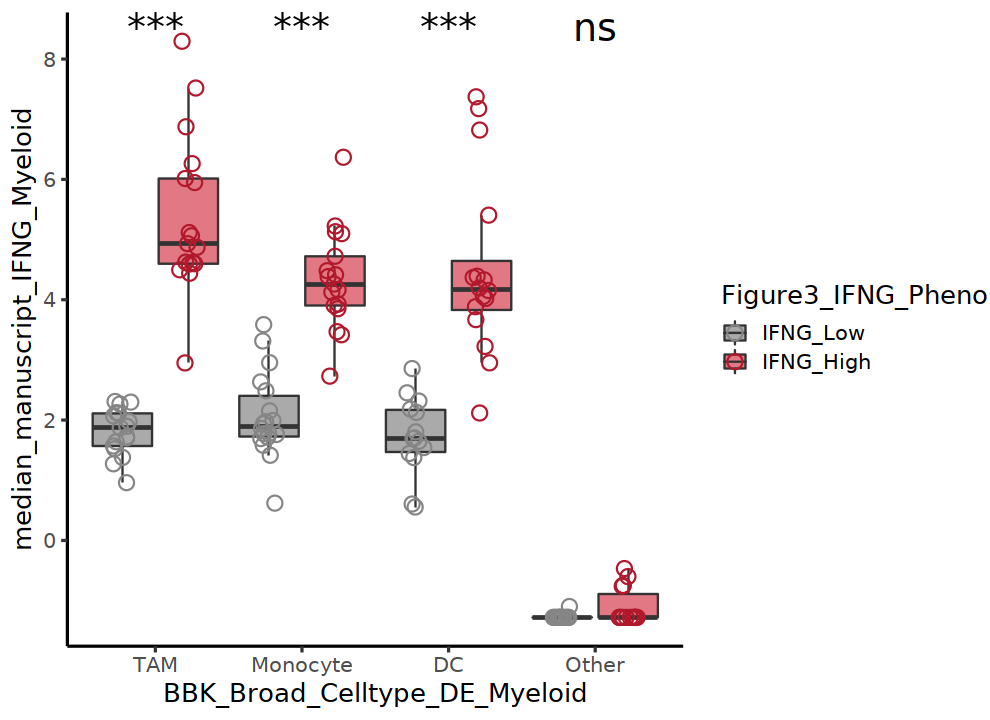

In [52]:
options(repr.plot.width=8.25, repr.plot.height=6)

IFNG = ggplot(plot_df_IFNG_Myeloid, aes(x=BBK_Broad_Celltype_DE_Myeloid, y=median_manuscript_IFNG_Myeloid, fill=Figure3_IFNG_Pheno)) + 
    geom_boxplot(alpha = 0.7, outlier.shape = NA, width = 0.9) + scale_fill_manual(values = c("gray52","#d53e4f")) +
scale_color_manual(values = c("gray52","#b2182b")) +
geom_jitter(aes(color = Figure3_IFNG_Pheno,group = Figure3_IFNG_Pheno),shape = 1, size = 3.5, stroke=0.7, alpha=1,position = position_jitterdodge(jitter.width = 0.25,dodge.width = 0.9)) +
stat_compare_means(aes(group = Figure3_IFNG_Pheno), label = "p.signif",size = 8,,symnum.args = signif_cutoffs) + theme_classic(base_size = 15)

IFNG

ggsave("../../Supp_Figures_Final/Figure_S10/FigureS10C_Myeloid_IFNG_Median_Boxplots_Treated.pdf",width = 8.25, height = 6)


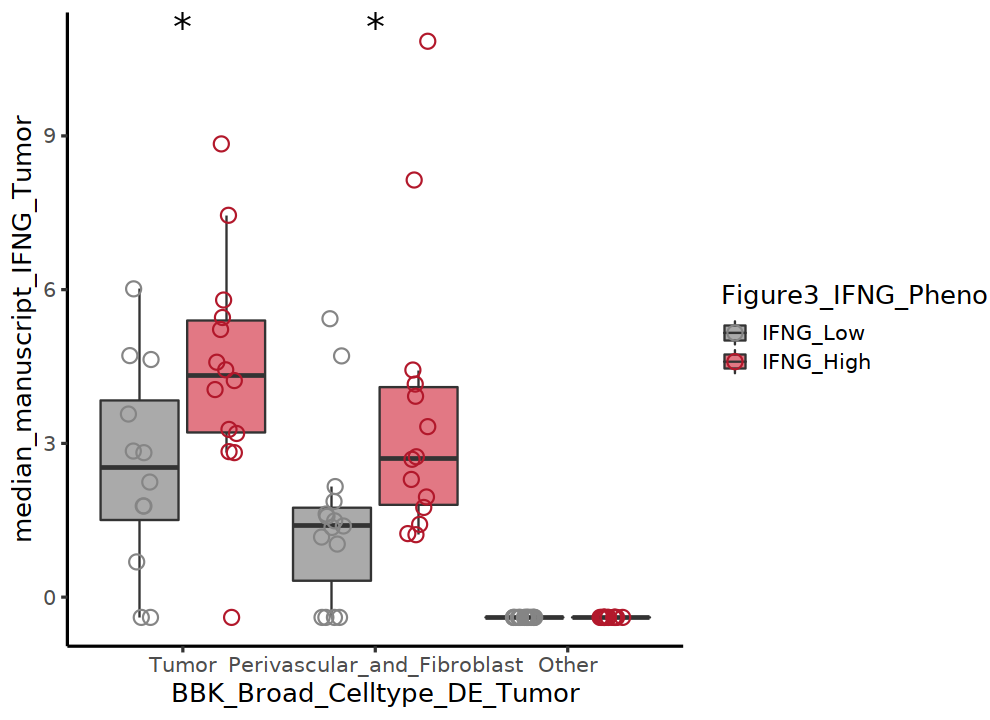

In [53]:
options(repr.plot.width=8.25, repr.plot.height=6)

IFNG = ggplot(plot_df_IFNG_Tumor, aes(x=BBK_Broad_Celltype_DE_Tumor, y=median_manuscript_IFNG_Tumor, fill=Figure3_IFNG_Pheno)) + 
    geom_boxplot(alpha = 0.7, outlier.shape = NA, width = 0.9) + scale_fill_manual(values = c("gray52","#d53e4f")) +
scale_color_manual(values = c("gray52","#b2182b")) +
geom_jitter(aes(color = Figure3_IFNG_Pheno,group = Figure3_IFNG_Pheno),shape = 1, size = 3.5, stroke=0.7, alpha=1,position = position_jitterdodge(jitter.width = 0.25,dodge.width = 0.9)) +
stat_compare_means(aes(group = Figure3_IFNG_Pheno), label = "p.signif",size = 8,,symnum.args = signif_cutoffs) + theme_classic(base_size = 15)

IFNG

ggsave("../../Supp_Figures_Final/Figure_S10/FigureS10C_Tumor_IFNG_Median_Boxplots_Treated.pdf",width = 8.25, height = 6)

In [54]:
a = subset(plot_df_IFNG_Tumor, BBK_Broad_Celltype_DE_Tumor == "Other" & Figure3_IFNG_Pheno == "IFNG_High")$median_manuscript_IFNG_Tumor
b = subset(plot_df_IFNG_Tumor, BBK_Broad_Celltype_DE_Tumor == "Other" & Figure3_IFNG_Pheno == "IFNG_Low")$median_manuscript_IFNG_Tumor

In [55]:
wilcox.test(a,b)

Warning message in wilcox.test.default(a, b):
"cannot compute exact p-value with ties"



	Wilcoxon rank sum test with continuity correction

data:  a and b
W = 162, p-value = NA
alternative hypothesis: true location shift is not equal to 0


### Calculate median expanded IFN1 score per sample, grouped down by Sample and IFN1 response high and low

In [56]:
plot_df_IFN1$Figure3_IFN1_Pheno_Sample = paste(plot_df_IFN1$Figure3_IFN1_Pheno,plot_df_IFN1$Sample, sep = ".")

###

plot_df_IFN1_Myeloid = plot_df_IFN1 %>%
  group_by(Figure3_IFN1_Pheno_Sample, BBK_Broad_Celltype_DE_Myeloid, Figure3_IFN1_Pheno, Sample) %>%
  summarise(median_manuscript_IFN1_Myeloid = median(manuscript_IFN1_myeloid))

plot_df_IFN1_Tumor = plot_df_IFN1 %>%
  group_by(Figure3_IFN1_Pheno_Sample, BBK_Broad_Celltype_DE_Tumor, Figure3_IFN1_Pheno, Sample) %>%
  summarise(median_manuscript_IFN1_Tumor = median(manuscript_IFN1_tumor))

`summarise()` has grouped output by 'Figure3_IFN1_Pheno_Sample',
'BBK_Broad_Celltype_DE_Myeloid', 'Figure3_IFN1_Pheno'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'Figure3_IFN1_Pheno_Sample',
'BBK_Broad_Celltype_DE_Tumor', 'Figure3_IFN1_Pheno'. You can override using the
`.groups` argument.


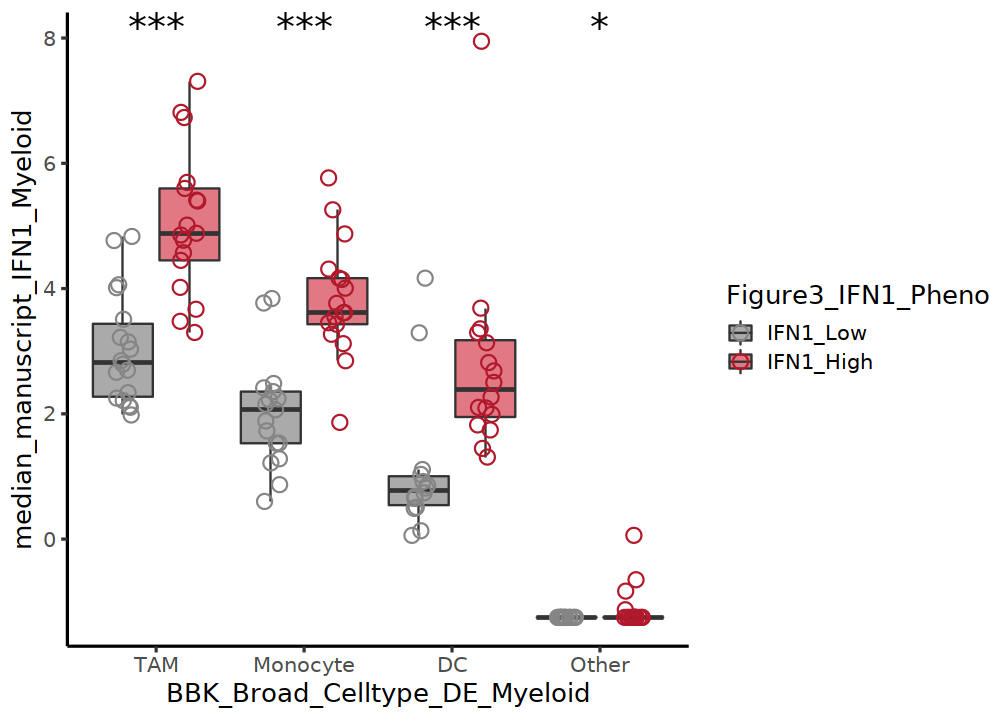

In [57]:
options(repr.plot.width=8.25, repr.plot.height=6)

IFN1 = ggplot(plot_df_IFN1_Myeloid, aes(x=BBK_Broad_Celltype_DE_Myeloid, y=median_manuscript_IFN1_Myeloid, fill=Figure3_IFN1_Pheno)) + 
    geom_boxplot(alpha = 0.7, outlier.shape = NA, width = 0.9) + scale_fill_manual(values = c("gray52","#d53e4f")) +
scale_color_manual(values = c("gray52","#b2182b")) +
geom_jitter(aes(color = Figure3_IFN1_Pheno,group = Figure3_IFN1_Pheno),shape = 1, size = 3.5, stroke=0.7, alpha=1,position = position_jitterdodge(jitter.width = 0.25,dodge.width = 0.9)) +
stat_compare_means(aes(group = Figure3_IFN1_Pheno), label = "p.signif",size = 8,,symnum.args = signif_cutoffs) + theme_classic(base_size = 15)

IFN1

ggsave("../../Supp_Figures_Final/Figure_S10/FigureS10D_Myeloid_IFN1_Median_Boxplots_Treated.pdf",width = 8.25, height = 6)

### Score IMM151 and JAV101 bulk RNA-Seq for expanded ISG signatures and add CIBERSORTx fractions <a name="6"></a>

In [58]:
ISG_sigs_expanded = readRDS("/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/IFN_RCC_Manuscript_2024/Signatures/ExpandedISG_50p_Final_Manuscript_Signatures_CTS_ISGs_FigureS10.RDS")
ISG_sigs_expanded$manuscript_myeloid_combined
ISG_sigs_expanded$manuscript_tumor_combined
ISG_sigs_expanded$manuscript_t_nk_combined

[1] "IFI30"    "LPAR6"    "FCGR1A"   "MYD88"    "VSIG4"    "LILRB1"  
 [7] "IL10"     "IL1RN"    "C1QB"     "TNFSF13B" "SIGLEC1"  "SECTM1"  
[13] "MX2"      "FPR2"     "CXCL10"   "CD86"     "GCH1"     "SIGLEC10"
[19] "ANKRD22"  "FPR1"     "SLAMF8"   "PSTPIP2"  "FCGR1B"   "JAK2"    
[25] "CXCL9"    "TNFAIP2"  "PTGS2"    "IL15"     "LAMP3"    "NFKB1"

[1] "C1R"     "PFKP"    "TNFAIP6" "C1S"     "CFB"     "SSPN"    "DSP"

[1] "NLRC5" "OASL"  "IL2RB" "XCL1"  "GZMA"  "STAT4" "CCL5"  "SOCS1"

In [59]:
length(ISG_sigs)

[1] 240

### IMM151

In [60]:
imm151_rna = readRDS("../../Trial_Cohorts/IMM151/IMM151_RNASeq_TPM.RDS")
imm151_clin = readRDS("../../Trial_Cohorts/IMM151/IMM151_Clinical_Metadata.RDS")

dim(imm151_rna)
dim(imm151_clin)

[1] 25297   823

[1] 823  92

In [61]:
options(future.globals.maxSize= 50000*1024^2)

imm151_gs = hack_sig(
  imm151_rna,
  signatures = ISG_sigs_expanded,
  method = "zscore")

In [62]:
imm151_gs_final = data.frame(imm151_gs[,2:ncol(imm151_gs)])
row.names(imm151_gs_final) = imm151_gs$sample_id

In [63]:
corner(imm151_gs_final)

setequal(row.names(imm151_gs_final),row.names(imm151_clin))

manuscript_IFN1_myeloid manuscript_IFN1_t_nk
EA-37ce247b1d -5.9239054              -3.5229063          
EA-c98e425b64  0.1779914               1.9489467          
EA-bb52459cfb  4.9135564               1.4646782          
EA-7e3f099861  1.3893247               1.7376840          
EA-080ae948aa  0.5608664              -0.7538771          
              manuscript_IFN1_tumor manuscript_IFNG_myeloid
EA-37ce247b1d -0.5651403            -7.1088788             
EA-c98e425b64  0.7658367             1.8400287             
EA-bb52459cfb  1.9194814             4.2962275             
EA-7e3f099861  0.6346561             2.5565770             
EA-080ae948aa  0.2212405             0.4300865             
              manuscript_IFNG_t_nk
EA-37ce247b1d -3.6849959          
EA-c98e425b64  2.2322537          
EA-bb52459cfb  2.0395606          
EA-7e3f099861  1.5752130          
EA-080ae948aa -0.3709755

[1] TRUE

In [64]:
clin_imm151_full = cbind(imm151_clin, imm151_gs_final)
clin_imm151_full = cbind(clin_imm151_full, data.frame(t(imm151_rna),check.names = F))

cib = read.table("../../Trial_Cohorts/IMM151/IMM151_CIBERSORTx_Res_2024.txt", header = T, row.names = 1, check.names = F, sep = '\t')
colnames(cib) = paste(colnames(cib),"_CS", sep = "")
library(stringr)
colnames(cib) = str_replace_all(colnames(cib)," ","_")
colnames(cib) = str_replace_all(colnames(cib),"-","_")
colnames(cib)
corner(cib)
dim(cib)
cib

setequal(row.names(clin_imm151_full), row.names(cib))

clin_imm151_full = cbind(clin_imm151_full, cib)


cyt = clin_imm151_full[,c("GZMA","PRF1")]
corner(cyt)

calc_cyt = function(vec){
    cyt = exp(mean(log(as.numeric(vec))))
    return(cyt)
}

cyt$CYT = apply(cyt, 1, calc_cyt)
corner(cyt)

clin_imm151_full$CYT = cyt$CYT

clin_imm151_full$SEX = factor(clin_imm151_full$SEX)
clin_imm151_full$MSKCC_RISK_SCORE = factor(clin_imm151_full$MSKCC_RISK_SCORE, levels = c("High","Intermediate","Low"))
clin_imm151_full$LIVER_METASTASES = factor(clin_imm151_full$LIVER_METASTASES)
clin_imm151_full$SARCOMATOID = factor(clin_imm151_full$SARCOMATOID)

class(clin_imm151_full$AGE)
class(clin_imm151_full$SEX)
class(clin_imm151_full$MSKCC_RISK_SCORE)
class(clin_imm151_full$LIVER_METASTASES)
class(clin_imm151_full$SARCOMATOID)


[1] "Tumor_CS"             "Plasma_cell_CS"       "CD8_NK_like_CS"      
 [4] "DC_CS"                "Endothelial_CS"       "TAM_CS"              
 [7] "T_reg_CS"             "NK_CS"                "Monocyte_CS"         
[10] "B_cell_CS"            "T_Helper_CS"          "CD8_CS"              
[13] "Perivascular_cell_CS" "Fibroblast_CS"        "P_value_CS"          
[16] "Correlation_CS"       "RMSE_CS"

Tumor_CS  Plasma_cell_CS CD8_NK_like_CS DC_CS     Endothelial_CS
EA-37ce247b1d 0.3741540 0.002787644    0.108806410    0.0000000 0.06391776    
EA-c98e425b64 0.3210770 0.125897588    0.004743981    0.0000000 0.04912354    
EA-bb52459cfb 0.2226262 0.004689752    0.000000000    0.0000000 0.02894587    
EA-7e3f099861 0.3114670 0.013640173    0.000000000    0.1018227 0.11147735    
EA-080ae948aa 0.1884054 0.011215563    0.000000000    0.0000000 0.16511876

[1] 823  17

Tumor_CS    Plasma_cell_CS CD8_NK_like_CS DC_CS     
EA-37ce247b1d 0.37415399  0.002787644    0.108806410    0.00000000
EA-c98e425b64 0.32107701  0.125897588    0.004743981    0.00000000
EA-bb52459cfb 0.22262616  0.004689752    0.000000000    0.00000000
EA-7e3f099861 0.31146699  0.013640173    0.000000000    0.10182266
EA-080ae948aa 0.18840539  0.011215563    0.000000000    0.00000000
EA-95851271dc 0.33252487  0.003504400    0.023752578    0.09683716
EA-fd3db26e4b 0.15947267  0.035437873    0.057200539    0.00000000
EA-8bcd048f13 0.35752898  0.041763465    0.000000000    0.00000000
EA-50a17b762a 0.39309840  0.035418376    0.000000000    0.00000000
EA-503b2e1876 0.51773139  0.012295442    0.000000000    0.00000000
EA-9be3b7c254 0.36630275  0.007574916    0.040372838    0.03026457
EA-fd72b64a6f 0.09201716  0.031908568    0.094585491    0.00000000
EA-cce8886053 0.16650712  0.044982122    0.061698418    0.06459728
EA-858e45ba5f 0.37386960  0.023425252    0.059441590    0.00000000
EA-5b0306cbbf 0.36019279  0.012242288    0.003084419    0.00000000
EA-23cd27556d 0.35517180  0.024161325    0.014109040    0.01500481
EA-d18965cbb2 0.14844789  0.100923231    0.033027136    0.04200395
EA-23df98b862 0.31867461  0.016090490    0.022273076    0.03847177
EA-525b274a40 0.01245405  0.002486428    0.000000000    0.00000000
EA-a6aae0959a 0.41768524  0.007989614    0.008120942    0.01560820
EA-bfef4c66ae 0.29965470  0.035081711    0.028029475    0.00000000
EA-c91d690b0f 0.25753153  0.018452641    0.036641490    0.05887168
EA-6723cce304 0.16588133  0.046450891    0.000000000    0.00000000
EA-7ab2f8ad2f 0.39033795  0.009869296    0.000000000    0.00000000
EA-f3980a7341 0.16235506  0.059422660    0.000000000    0.00000000
EA-3b9ac186c2 0.38697945  0.132521372    0.014821736    0.00000000
EA-d72c718ec7 0.05793412  0.029021046    0.000000000    0.00000000
EA-23fffd3c5e 0.25743611  0.013284549    0.003895886    0.00000000
EA-52b3547343 0.18853202  0.052957738    0.009229863    0.00000000
EA-538f97cadc 0.35743386  0.026780911    0.082236600    0.07078258
...           ...         ...            ...            ...       
EA-c942cdbd6d 0.239893205 0.0811546134   0.042564867    0.00000000
EA-568c0f7d91 0.451759563 0.0266055556   0.015262318    0.00000000
EA-8278b36a68 0.559724686 0.0005682576   0.000000000    0.00269058
EA-054c0dfe3f 0.073274980 0.0440083993   0.019300918    0.00000000
EA-b879db0aa8 0.208598893 0.0025804640   0.147417001    0.09659709
EA-08882c1356 0.004915472 0.1734972043   0.033492693    0.00000000
EA-486295f621 0.303233908 0.0192961834   0.031988889    0.00000000
EA-0f5ab757ff 0.154395826 0.0028912183   0.033259150    0.00000000
EA-baab84f3a5 0.424741233 0.0126334473   0.056904189    0.00000000
EA-5af8a72e80 0.335546148 0.0236638302   0.000000000    0.01188152
EA-bde6ab8ffc 0.415277537 0.0059301531   0.000000000    0.00000000
EA-be353731b6 0.309770446 0.1006212524   0.030264550    0.00000000
EA-8c6b1ded9d 0.311064080 0.0139764947   0.000000000    0.05236108
EA-a5fb7c0b2a 0.289836704 0.0327730102   0.040019431    0.01347893
EA-f426f94bf5 0.218100261 0.0157832082   0.047690856    0.11557235
EA-f43c0f908c 0.295622706 0.0205805449   0.002468563    0.00000000
EA-af196d3f17 0.125426404 0.0032127765   0.052731444    0.00000000
EA-36c2723404 0.107625721 0.0256848193   0.000000000    0.00000000
EA-a38e9bcd51 0.237396116 0.0349870790   0.029597552    0.00000000
EA-398415b35c 0.405601757 0.0016877908   0.011882480    0.00000000
EA-d35943bc56 0.099304031 0.0166727069   0.000000000    0.00000000
EA-239f544121 0.022389394 0.1113054399   0.080275473    0.00000000
EA-e808c2a7bb 0.335543211 0.0042324966   0.029131842    0.00000000
EA-bb771171f8 0.224429823 0.0056650333   0.000000000    0.00000000
EA-92021354b2 0.216866033 0.0259446851   0.000000000    0.00000000
EA-9598d4fe3c 0.330653585 0.0036822898   0.000000000    0.00000000
EA-794aef4de2 0.221799764 0.0448074579   0.011135229    0.00000000
EA-635c23d2d7 0.354420930 0.0131800182   0.000000000    0.000

[1] TRUE

GZMA     PRF1    
EA-37ce247b1d 2.221848 2.986173
EA-c98e425b64 5.203718 4.667844
EA-bb52459cfb 6.390406 6.034415
EA-7e3f099861 6.183439 5.110688
EA-080ae948aa 4.742241 3.910845

GZMA     PRF1     CYT     
EA-37ce247b1d 2.221848 2.986173 2.575815
EA-c98e425b64 5.203718 4.667844 4.928503
EA-bb52459cfb 6.390406 6.034415 6.209860
EA-7e3f099861 6.183439 5.110688 5.621533
EA-080ae948aa 4.742241 3.910845 4.306526

[1] "integer"

[1] "factor"

[1] "factor"

[1] "factor"

[1] "factor"

In [65]:
saveRDS(clin_imm151_full, file = "../../Trial_Cohorts/IMM151/IMM151_Clinical_Metadata_with_SigScores_CIBERSORTx_ExpandedISGs_FigureS10.RDS")

### JAV101

In [66]:
jav101_rna = readRDS("../../Trial_Cohorts/JAV101/JAV101_RNASeq_TPM_log2.RDS")
jav101_clin = readRDS("../../Trial_Cohorts/JAV101/JAV101_Clinical_Metadata.RDS")

dim(jav101_rna)
dim(jav101_clin)

[1] 40032   728

[1] 728  69

In [67]:
options(future.globals.maxSize= 50000*1024^2)

jav101_gs = hack_sig(
  jav101_rna,
  signatures = ISG_sigs_expanded,
  method = "zscore")

In [68]:
jav101_gs_final = data.frame(jav101_gs[,2:ncol(jav101_gs)])
row.names(jav101_gs_final) = jav101_gs$sample_id

In [69]:
corner(jav101_gs_final)

setequal(row.names(jav101_gs_final),row.names(jav101_clin))

manuscript_IFN1_myeloid manuscript_IFN1_t_nk
10011001_6203185783 -2.4199477              -1.0827914          
10011004_6204067375 -0.6422772              -3.5230931          
10011006_6204067377  0.1913410              -0.9528208          
10011007_6204067220  1.7530315               0.3263469          
10011008_6204067223  1.2021022               0.5665004          
                    manuscript_IFN1_tumor manuscript_IFNG_myeloid
10011001_6203185783 -0.17562036           -2.2724100             
10011004_6204067375  0.52433393           -2.7673842             
10011006_6204067377  0.29489663            0.6319431             
10011007_6204067220 -0.04649198            2.0557016             
10011008_6204067223  1.37561854            1.3456514             
                    manuscript_IFNG_t_nk
10011001_6203185783 -0.48011561         
10011004_6204067375 -3.54282924         
10011006_6204067377 -0.27285987         
10011007_6204067220  0.26343838         
10011008_6204067223  0.09528641

[1] TRUE

In [70]:
clin_jav101_full = cbind(jav101_clin, jav101_gs_final)
clin_jav101_full = cbind(clin_jav101_full, data.frame(t(jav101_rna)))

cib = read.table("../../Trial_Cohorts/JAV101/JAV101_CIBERSORTx_Res_2024.txt", header = T, row.names = 1, check.names = F, sep = '\t')
colnames(cib) = paste(colnames(cib),"_CS", sep = "")
library(stringr)
colnames(cib) = str_replace_all(colnames(cib)," ","_")
colnames(cib) = str_replace_all(colnames(cib),"-","_")
colnames(cib)
corner(cib)
dim(cib)

setequal(row.names(clin_jav101_full), row.names(cib))

clin_jav101_full = cbind(clin_jav101_full, cib)

clin_jav101_full$MSKCC = factor(clin_jav101_full$MSKCC, levels = c("POOR","INTERMEDIATE","FAVORABLE"))

cyt = clin_jav101_full[,c("GZMA","PRF1")]
corner(cyt)

calc_cyt = function(vec){
    cyt = exp(mean(log(as.numeric(vec))))
    return(cyt)
}

cyt$CYT = apply(cyt, 1, calc_cyt)
corner(cyt)

clin_jav101_full$CYT = cyt$CYT

[1] "Tumor_CS"             "Plasma_cell_CS"       "CD8_NK_like_CS"      
 [4] "DC_CS"                "Endothelial_CS"       "TAM_CS"              
 [7] "T_reg_CS"             "NK_CS"                "Monocyte_CS"         
[10] "B_cell_CS"            "T_Helper_CS"          "CD8_CS"              
[13] "Perivascular_cell_CS" "Fibroblast_CS"        "P_value_CS"          
[16] "Correlation_CS"       "RMSE_CS"

Tumor_CS  Plasma_cell_CS CD8_NK_like_CS DC_CS     
10011001_6203185783 0.4298872 0.02941799     0.00000000     0.01711993
10011004_6204067375 0.3695604 0.01732244     0.00000000     0.00000000
10011006_6204067377 0.2219636 0.03354051     0.00646338     0.00000000
10011007_6204067220 0.2126105 0.20342298     0.01963458     0.00000000
10011008_6204067223 0.3465823 0.03603397     0.11652607     0.00000000
                    Endothelial_CS
10011001_6203185783 0.08387205    
10011004_6204067375 0.07735827    
10011006_6204067377 0.15136374    
10011007_6204067220 0.07499591    
10011008_6204067223 0.06215872

[1] 728  17

[1] TRUE

GZMA     PRF1    
10011001_6203185783 3.424922 2.910733
10011004_6204067375 1.565597 1.735522
10011006_6204067377 3.407353 3.799087
10011007_6204067220 3.538538 4.031219
10011008_6204067223 4.139142 4.016140

GZMA     PRF1     CYT     
10011001_6203185783 3.424922 2.910733 3.157377
10011004_6204067375 1.565597 1.735522 1.648372
10011006_6204067377 3.407353 3.799087 3.597893
10011007_6204067220 3.538538 4.031219 3.776853
10011008_6204067223 4.139142 4.016140 4.077177

In [71]:
saveRDS(clin_jav101_full, file = "../../Trial_Cohorts/JAV101/JAV101_Clinical_Metadata_with_SigScores_CIBERSORTx_ExpandedISGs_FigureS10.RDS")

### Supp Fig 10E-F. Violin plots of expanded ISG signature scores in IMM151 and JAV101 in samples grouped by IFNG expression and cell type fractions <a name="7"></a>

### IMM151

In [72]:
clin_imm151_full = readRDS(file = "../../Trial_Cohorts/IMM151/IMM151_Clinical_Metadata_with_SigScores_CIBERSORTx_ExpandedISGs_FigureS10.RDS")

In [73]:
df = data.frame(table(colnames(clin_imm151_full)))
subset(df, Freq > 1)

clin_imm151_full = subset(clin_imm151_full, select = -c(IFIT3) )

Var1  Freq
8604 IFIT3 2

In [74]:
clin_imm151_full$IFNG_2ntile = ntile(clin_imm151_full$IFNG,n = 2)
clin_imm151_full = mutate(clin_imm151_full, IFNG_2ntile_group = ifelse(IFNG_2ntile == 1, "IFNG_Low","IFNG_High"))

clin_imm151_full$TAM_CS_2ntile = ntile(clin_imm151_full$TAM_CS,n = 2)
clin_imm151_full = mutate(clin_imm151_full, TAM_CS_2ntile_group = ifelse(TAM_CS_2ntile == 1, "TAM_Low","TAM_High"))

clin_imm151_full$Tumor_CS_2ntile = ntile(clin_imm151_full$Tumor_CS,n = 2)
clin_imm151_full = mutate(clin_imm151_full, Tumor_CS_2ntile_group = ifelse(Tumor_CS_2ntile == 1, "Tumor_Low","Tumor_High"))

clin_imm151_full$Tumor_Fib_CS = clin_imm151_full$Tumor_CS + clin_imm151_full$Fibroblast_CS
clin_imm151_full$Tumor_Fib_CS_2ntile = ntile(clin_imm151_full$Tumor_Fib_CS,n = 2)
clin_imm151_full = mutate(clin_imm151_full, Tumor_Fib_CS_2ntile_group = ifelse(Tumor_Fib_CS_2ntile == 1, "Tumor_Fib_Low","Tumor_Fib_High"))

clin_imm151_full$CD8_CS_2ntile = ntile(clin_imm151_full$CD8_CS,n = 2)
clin_imm151_full = mutate(clin_imm151_full, CD8_CS_2ntile_group = ifelse(CD8_CS_2ntile == 1, "CD8_Low","CD8_High"))

In [75]:
clin_imm151_full$IFNG_TAM_Group = paste(clin_imm151_full$IFNG_2ntile_group, clin_imm151_full$TAM_CS_2ntile_group, sep = ".")
table(clin_imm151_full$IFNG_TAM_Group)

clin_imm151_full$IFNG_Tumor_Group = paste(clin_imm151_full$IFNG_2ntile_group, clin_imm151_full$Tumor_CS_2ntile_group, sep = ".")
table(clin_imm151_full$IFNG_Tumor_Group)

clin_imm151_full$IFNG_Tumor_Fib_Group = paste(clin_imm151_full$IFNG_2ntile_group, clin_imm151_full$Tumor_Fib_CS_2ntile_group, sep = ".")
table(clin_imm151_full$IFNG_Tumor_Fib_Group)

clin_imm151_full$IFNG_CD8_Group = paste(clin_imm151_full$IFNG_2ntile_group, clin_imm151_full$CD8_CS_2ntile_group, sep = ".")
table(clin_imm151_full$IFNG_CD8_Group)


IFNG_High.TAM_High  IFNG_High.TAM_Low  IFNG_Low.TAM_High   IFNG_Low.TAM_Low 
               226                185                185                227 


IFNG_High.Tumor_High  IFNG_High.Tumor_Low  IFNG_Low.Tumor_High 
                 152                  259                  259 
  IFNG_Low.Tumor_Low 
                 153 


IFNG_High.Tumor_Fib_High  IFNG_High.Tumor_Fib_Low  IFNG_Low.Tumor_Fib_High 
                     148                      263                      263 
  IFNG_Low.Tumor_Fib_Low 
                     149 


IFNG_High.CD8_High  IFNG_High.CD8_Low  IFNG_Low.CD8_High   IFNG_Low.CD8_Low 
               327                 84                 84                328 

In [76]:
clin_imm151_full$IFNG_TAM_Group = factor(clin_imm151_full$IFNG_TAM_Group, levels = c("IFNG_Low.TAM_Low","IFNG_Low.TAM_High","IFNG_High.TAM_Low","IFNG_High.TAM_High"))

clin_imm151_full$IFNG_Tumor_Group = factor(clin_imm151_full$IFNG_Tumor_Group, levels = c("IFNG_Low.Tumor_Low","IFNG_Low.Tumor_High","IFNG_High.Tumor_Low","IFNG_High.Tumor_High"))

clin_imm151_full$IFNG_Tumor_Fib_Group = factor(clin_imm151_full$IFNG_Tumor_Fib_Group, levels = c("IFNG_Low.Tumor_Fib_Low","IFNG_Low.Tumor_Fib_High","IFNG_High.Tumor_Fib_Low","IFNG_High.Tumor_Fib_High"))

clin_imm151_full$IFNG_CD8_Group = factor(clin_imm151_full$IFNG_CD8_Group, levels = c("IFNG_Low.CD8_Low","IFNG_Low.CD8_High","IFNG_High.CD8_Low","IFNG_High.CD8_High"))

### Expanded IFNG_myeloid score by IFNG and TAM fraction groups

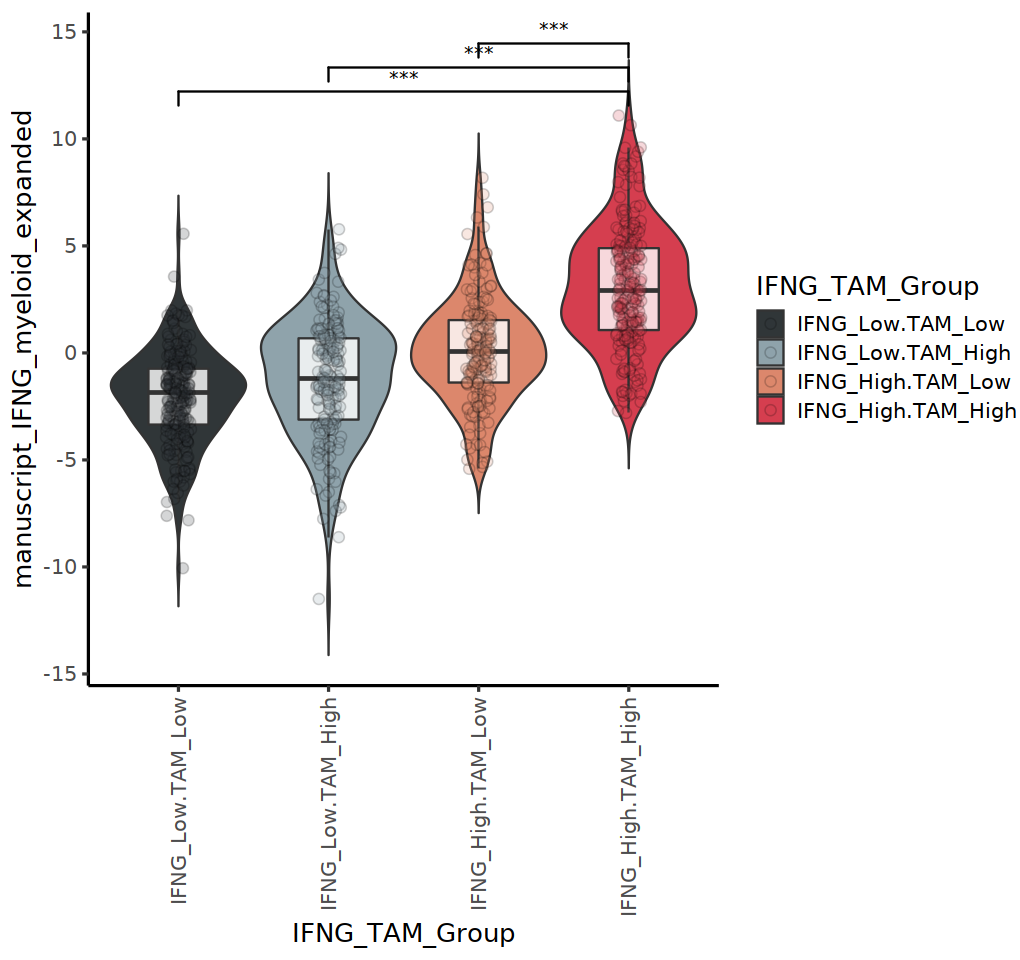

In [77]:
options(repr.plot.width=8.5, repr.plot.height=8)

ggplot(clin_imm151_full, aes(x=IFNG_TAM_Group, y=manuscript_IFNG_myeloid, fill=IFNG_TAM_Group)) + 
geom_violin(trim = F,scale = 'width') +
    geom_boxplot(fill = "white",width = 0.4,alpha = 0.8, outlier.shape = NA) +
# scale_fill_manual(values = c("gray52","#d53e4f")) +
#scale_color_manual(values = c("gray52","#d53e4f")) +
geom_jitter(aes(fill = IFNG_TAM_Group),color = "black",shape = 21, size = 2.5, alpha=0.2,position = position_jitterdodge(jitter.width = 0.5)) +
#stat_compare_means(aes(group = Figure3_IFNG_Pheno), label = "p.signif",size = 8) + 
theme_classic(base_size = 15) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
geom_signif(comparisons = list(c(1,4),c(2,4),c(3,4)),map_signif_level=TRUE,step_increase = 0.05) +
scale_color_manual(values = c("#303638FF","#8FA3ABFF","#DC876CFF","#d53e4f")) +
scale_fill_manual(values = c("#303638FF","#8FA3ABFF","#DC876CFF","#d53e4f")) + ylab("manuscript_IFNG_myeloid_expanded")

ggsave("../../Supp_Figures_Final/Figure_S10/FigureS10E_TAM_manuscript_IFNG_myeloid_imm151_Violins.pdf",width = 8.5, height = 8)

### Expanded IFNG_tumor score by IFNG and Tumor + Fibroblast fraction groups

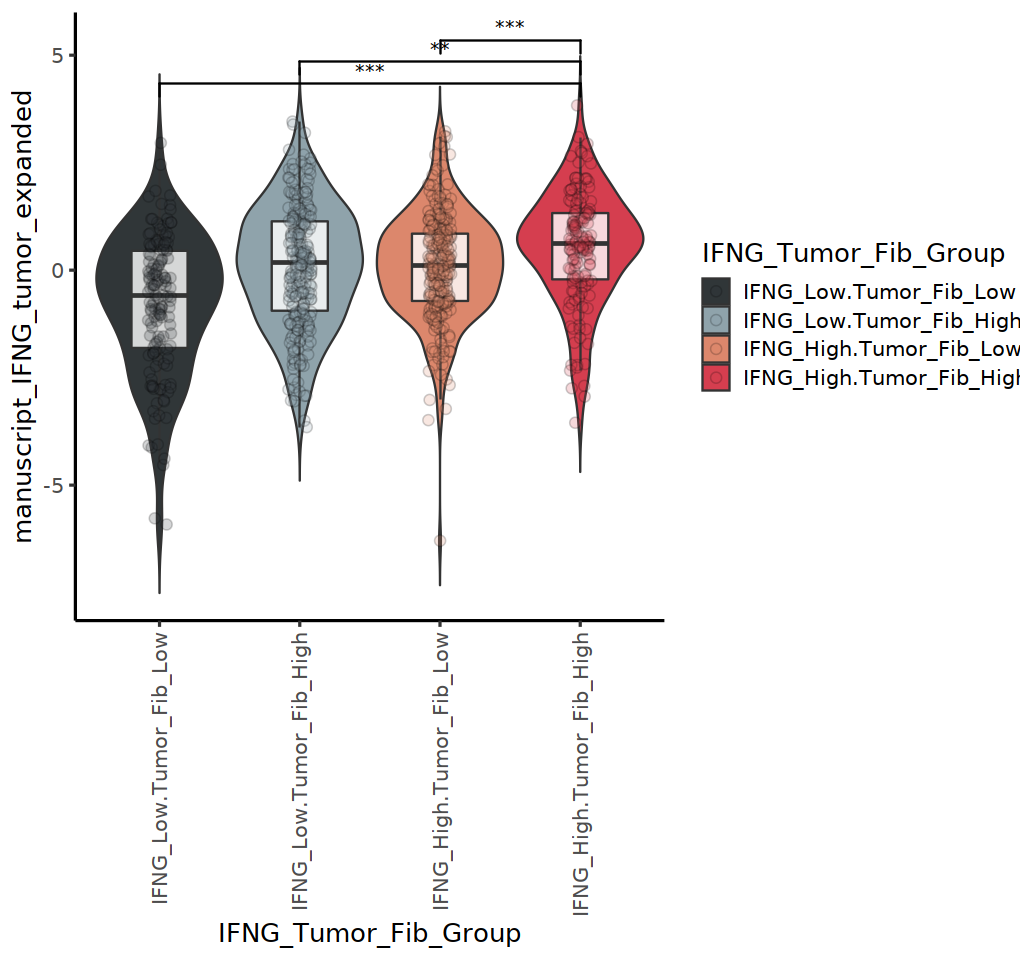

In [78]:
options(repr.plot.width=8.5, repr.plot.height=8)

ggplot(clin_imm151_full, aes(x=IFNG_Tumor_Fib_Group, y=manuscript_IFNG_tumor, fill=IFNG_Tumor_Fib_Group)) + 
geom_violin(trim = F,scale = 'width') +
    geom_boxplot(fill = "white",width = 0.4,alpha = 0.8, outlier.shape = NA) +
# scale_fill_manual(values = c("gray52","#d53e4f")) +
#scale_color_manual(values = c("gray52","#d53e4f")) +
geom_jitter(aes(fill = IFNG_Tumor_Fib_Group),color = "black",shape = 21, size = 2.5, alpha=0.2,position = position_jitterdodge(jitter.width = 0.5)) +
#stat_compare_means(aes(group = Figure3_IFNG_Pheno), label = "p.signif",size = 8) + 
theme_classic(base_size = 15) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
geom_signif(comparisons = list(c(1,4),c(2,4),c(3,4)),map_signif_level=TRUE,step_increase = 0.05) +
scale_color_manual(values = c("#303638FF","#8FA3ABFF","#DC876CFF","#d53e4f")) +
scale_fill_manual(values = c("#303638FF","#8FA3ABFF","#DC876CFF","#d53e4f")) + ylab("manuscript_IFNG_tumor_expanded")

#Palette red: #ED3F39FF

ggsave("../../Supp_Figures_Final/Figure_S10/FigureS10F_Tumor_Fib_manuscript_IFNG_myeloid_imm151_Violins.pdf",width = 8.5, height = 8)

### JAV101

In [79]:
clin_jav101_full = readRDS(file = "../../Trial_Cohorts/JAV101/JAV101_Clinical_Metadata_with_SigScores_CIBERSORTx_ExpandedISGs_FigureS10.RDS")

In [80]:
df = data.frame(table(colnames(clin_jav101_full)))
subset(df, Freq > 1)

Var1        Freq
14682 CD8A        2   
17979 Eosinophils 2   
21236 IFIT3       2   
27495 Neutrophils 2

In [81]:
clin_jav101_full = subset(clin_jav101_full, select = -c(CD8A,Eosinophils,IFIT3, Neutrophils) )

In [82]:
clin_jav101_full$IFNG_2ntile = ntile(clin_jav101_full$IFNG,n = 2)
clin_jav101_full = mutate(clin_jav101_full, IFNG_2ntile_group = ifelse(IFNG_2ntile == 1, "IFNG_Low","IFNG_High"))

clin_jav101_full$TAM_CS_2ntile = ntile(clin_jav101_full$TAM_CS,n = 2)
clin_jav101_full = mutate(clin_jav101_full, TAM_CS_2ntile_group = ifelse(TAM_CS_2ntile == 1, "TAM_Low","TAM_High"))

clin_jav101_full$Tumor_CS_2ntile = ntile(clin_jav101_full$Tumor_CS,n = 2)
clin_jav101_full = mutate(clin_jav101_full, Tumor_CS_2ntile_group = ifelse(Tumor_CS_2ntile == 1, "Tumor_Low","Tumor_High"))

clin_jav101_full$Tumor_Fib_CS = clin_jav101_full$Tumor_CS + clin_jav101_full$Fibroblast_CS
clin_jav101_full$Tumor_Fib_CS_2ntile = ntile(clin_jav101_full$Tumor_Fib_CS,n = 2)
clin_jav101_full = mutate(clin_jav101_full, Tumor_Fib_CS_2ntile_group = ifelse(Tumor_Fib_CS_2ntile == 1, "Tumor_Fib_Low","Tumor_Fib_High"))

clin_jav101_full$CD8_CS_2ntile = ntile(clin_jav101_full$CD8_CS,n = 2)
clin_jav101_full = mutate(clin_jav101_full, CD8_CS_2ntile_group = ifelse(CD8_CS_2ntile == 1, "CD8_Low","CD8_High"))

In [83]:
clin_jav101_full$IFNG_TAM_Group = paste(clin_jav101_full$IFNG_2ntile_group, clin_jav101_full$TAM_CS_2ntile_group, sep = ".")
table(clin_jav101_full$IFNG_TAM_Group)

clin_jav101_full$IFNG_Tumor_Group = paste(clin_jav101_full$IFNG_2ntile_group, clin_jav101_full$Tumor_CS_2ntile_group, sep = ".")
table(clin_jav101_full$IFNG_Tumor_Group)

clin_jav101_full$IFNG_Tumor_Fib_Group = paste(clin_jav101_full$IFNG_2ntile_group, clin_jav101_full$Tumor_Fib_CS_2ntile_group, sep = ".")
table(clin_jav101_full$IFNG_Tumor_Fib_Group)

clin_jav101_full$IFNG_CD8_Group = paste(clin_jav101_full$IFNG_2ntile_group, clin_jav101_full$CD8_CS_2ntile_group, sep = ".")
table(clin_jav101_full$IFNG_CD8_Group)


IFNG_High.TAM_High  IFNG_High.TAM_Low  IFNG_Low.TAM_High   IFNG_Low.TAM_Low 
               219                145                145                219 


IFNG_High.Tumor_High  IFNG_High.Tumor_Low  IFNG_Low.Tumor_High 
                 134                  230                  230 
  IFNG_Low.Tumor_Low 
                 134 


IFNG_High.Tumor_Fib_High  IFNG_High.Tumor_Fib_Low  IFNG_Low.Tumor_Fib_High 
                     129                      235                      235 
  IFNG_Low.Tumor_Fib_Low 
                     129 


IFNG_High.CD8_High  IFNG_High.CD8_Low  IFNG_Low.CD8_High   IFNG_Low.CD8_Low 
               249                115                115                249 

In [84]:
clin_jav101_full$IFNG_TAM_Group = factor(clin_jav101_full$IFNG_TAM_Group, levels = c("IFNG_Low.TAM_Low","IFNG_Low.TAM_High","IFNG_High.TAM_Low","IFNG_High.TAM_High"))

clin_jav101_full$IFNG_Tumor_Group = factor(clin_jav101_full$IFNG_Tumor_Group, levels = c("IFNG_Low.Tumor_Low","IFNG_Low.Tumor_High","IFNG_High.Tumor_Low","IFNG_High.Tumor_High"))

clin_jav101_full$IFNG_Tumor_Fib_Group = factor(clin_jav101_full$IFNG_Tumor_Fib_Group, levels = c("IFNG_Low.Tumor_Fib_Low","IFNG_Low.Tumor_Fib_High","IFNG_High.Tumor_Fib_Low","IFNG_High.Tumor_Fib_High"))

clin_jav101_full$IFNG_CD8_Group = factor(clin_jav101_full$IFNG_CD8_Group, levels = c("IFNG_Low.CD8_Low","IFNG_Low.CD8_High","IFNG_High.CD8_Low","IFNG_High.CD8_High"))

### Expanded IFNG_myeloid score by IFNG and TAM fraction groups

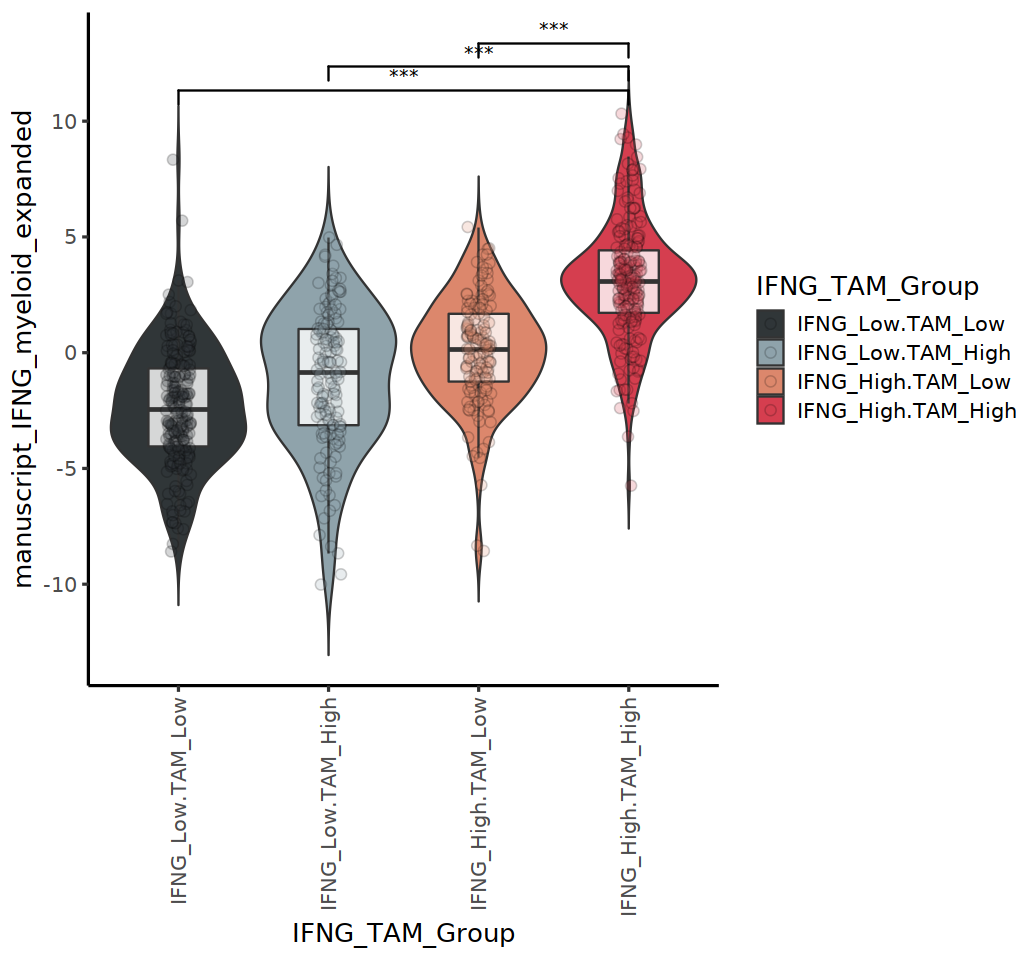

In [85]:
options(repr.plot.width=8.5, repr.plot.height=8)

ggplot(clin_jav101_full, aes(x=IFNG_TAM_Group, y=manuscript_IFNG_myeloid, fill=IFNG_TAM_Group)) + 
geom_violin(trim = F,scale = 'width') +
    geom_boxplot(fill = "white",width = 0.4,alpha = 0.8, outlier.shape = NA) +
# scale_fill_manual(values = c("gray52","#d53e4f")) +
#scale_color_manual(values = c("gray52","#d53e4f")) +
geom_jitter(aes(fill = IFNG_TAM_Group),color = "black",shape = 21, size = 2.5, alpha=0.2,position = position_jitterdodge(jitter.width = 0.5)) +
#stat_compare_means(aes(group = Figure3_IFNG_Pheno), label = "p.signif",size = 8) + 
theme_classic(base_size = 15) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
geom_signif(comparisons = list(c(1,4),c(2,4),c(3,4)),map_signif_level=TRUE,step_increase = 0.05) +
scale_color_manual(values = c("#303638FF","#8FA3ABFF","#DC876CFF","#d53e4f")) +
scale_fill_manual(values = c("#303638FF","#8FA3ABFF","#DC876CFF","#d53e4f")) + ylab("manuscript_IFNG_myeloid_expanded")

ggsave("../../Supp_Figures_Final/Figure_S10/FigureS10E_TAM_manuscript_IFNG_myeloid_jav101_Violins.pdf",width = 8.5, height = 8)

### Expanded IFNG_tumor score by IFNG and Tumor + Fibroblast fraction groups

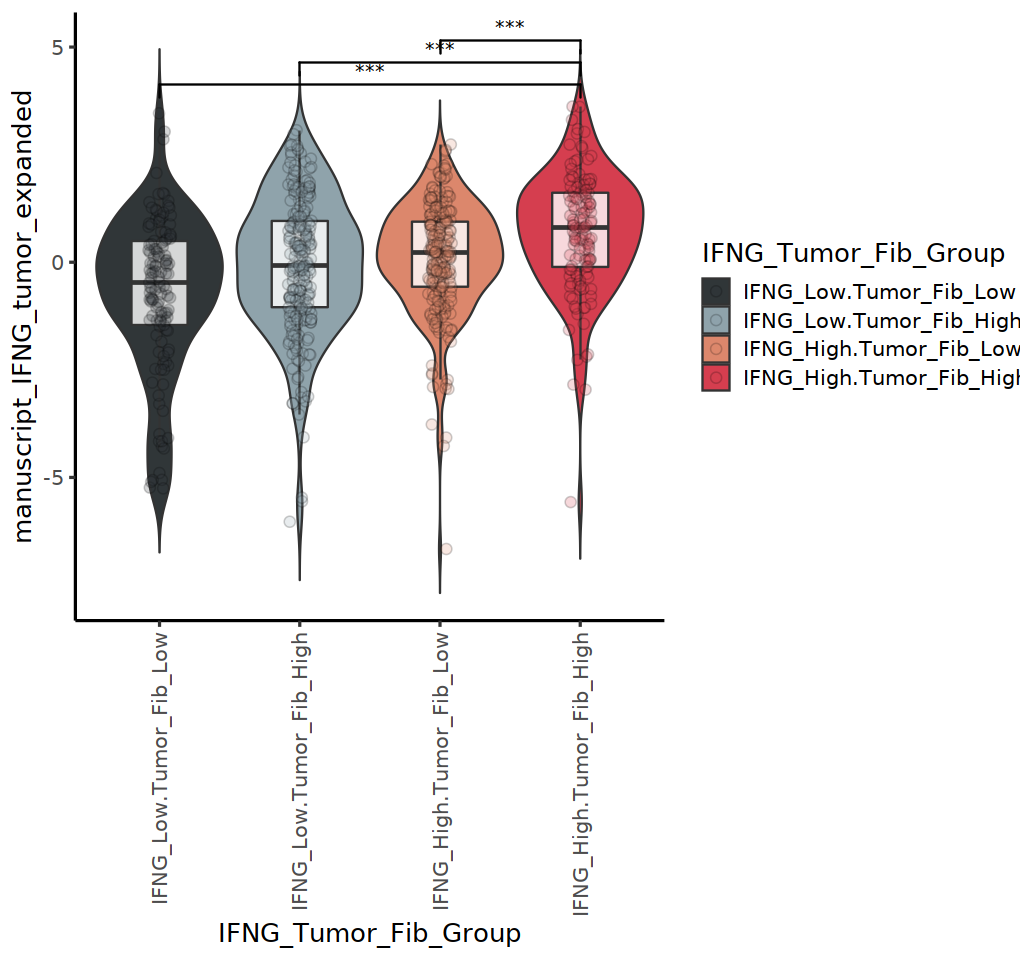

In [86]:
options(repr.plot.width=8.5, repr.plot.height=8)

ggplot(clin_jav101_full, aes(x=IFNG_Tumor_Fib_Group, y=manuscript_IFNG_tumor, fill=IFNG_Tumor_Fib_Group)) + 
geom_violin(trim = F,scale = 'width') +
    geom_boxplot(fill = "white",width = 0.4,alpha = 0.8, outlier.shape = NA) +
# scale_fill_manual(values = c("gray52","#d53e4f")) +
#scale_color_manual(values = c("gray52","#d53e4f")) +
geom_jitter(aes(fill = IFNG_Tumor_Fib_Group),color = "black",shape = 21, size = 2.5, alpha=0.2,position = position_jitterdodge(jitter.width = 0.5)) +
#stat_compare_means(aes(group = Figure3_IFNG_Pheno), label = "p.signif",size = 8) + 
theme_classic(base_size = 15) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
geom_signif(comparisons = list(c(1,4),c(2,4),c(3,4)),map_signif_level=TRUE,step_increase = 0.05) +
scale_color_manual(values = c("#303638FF","#8FA3ABFF","#DC876CFF","#d53e4f")) +
scale_fill_manual(values = c("#303638FF","#8FA3ABFF","#DC876CFF","#d53e4f")) + ylab("manuscript_IFNG_tumor_expanded")

#Palette red: #ED3F39FF

ggsave("../../Supp_Figures_Final/Figure_S10/FigureS10F_Tumor_Fib_manuscript_IFNG_myeloid_jav101_Violins.pdf",width = 8.5, height = 8)

### Supp Fig. 10G-J Cox models for PFS and logistic regression models for CB vs NCB in IO+VEGF arms of IMM151 and JAV101 (expanded IFNG signatures) <a name="8"></a>

### Set panels for forest_model plots

In [87]:
panels_cox <- list(
  list(width = 0.01),
  list(width = 0.18, display = ~variable, fontface = "bold", heading = "Variable"),
  list(width = 0.1, display = ~level),
  list(width = 0.05, display = ~n, hjust = 1, heading = "N"),
  list(width = 0.03, item = "vline", hjust = 0.5),
  list(
    width = 0.23, item = "forest", hjust = 0.5, heading = "Hazard ratio", linetype = "dashed",
    line_x = 0
  ),
  list(width = 0.03, item = "vline", hjust = 0.5),
  list(width = 0.12, display = ~ ifelse(reference, "Reference", sprintf(
    "%0.2f (%0.2f, %0.2f)",
    trans(estimate), trans(conf.low), trans(conf.high)
  )), display_na = NA),
  list(
    width = 0.075,
    display = ~ ifelse(reference, "", format.pval(p.value, digits = 1,nsmall = 3, eps = 0.001)),
    display_na = NA, hjust = 1, heading = "p"
  ),
  list(width = 0.01)
)

In [88]:
panels_lr <- list(
  list(width = 0.01),
  list(width = 0.18, display = ~variable, fontface = "bold", heading = "Variable"),
  list(width = 0.1, display = ~level),
  list(width = 0.05, display = ~n, hjust = 1, heading = "N"),
  list(width = 0.03, item = "vline", hjust = 0.5),
  list(
    width = 0.15, item = "forest", hjust = 0.5, heading = "Odds ratio", linetype = "dashed",
    line_x = 0
  ),
  list(width = 0.03, item = "vline", hjust = 0.5),
  list(width = 0.12, display = ~ ifelse(reference, "Reference", sprintf(
    "%0.2f (%0.2f, %0.2f)",
    trans(estimate), trans(conf.low), trans(conf.high)
  )), display_na = NA),
  list(
    width = 0.075,
    display = ~ ifelse(reference, "", format.pval(p.value, digits = 1,nsmall = 3, eps = 0.001)),
    display_na = NA, hjust = 1, heading = "p"
  ),
  list(width = 0.01)
)

### IMM151

In [90]:
clin_imm151_full = readRDS("../../Trial_Cohorts/IMM151/IMM151_Clinical_Metadata_with_SigScores_CIBERSORTx_ExpandedISGs_FigureS10.RDS")

df = data.frame(table(colnames(clin_imm151_full)))
subset(df, Freq > 1)

clin_imm151_full = subset(clin_imm151_full, select = -c(IFIT3) )

Var1  Freq
8604 IFIT3 2

### Expanded IFNg signatures in atezo_bev arm


 CB NCB 
263 117 

GVIF     Df GVIF^(1/(2*Df))
scale(manuscript_IFNG_myeloid)      4.762862 1  2.182398       
scale(TAM_CS)                       1.962450 1  1.400875       
scale(Monocyte_CS)                  1.804055 1  1.343151       
scale(DC_CS)                        1.318697 1  1.148345       
scale(Krishna_CD8A_Tissue_resident) 7.113703 1  2.667153       
scale(CD8_CS)                       2.507188 1  1.583410       
scale(manuscript_IFNG_tumor)        1.760066 1  1.326675       
scale(Tumor_CS)                     4.924539 1  2.219130       
scale(Fibroblast_CS)                1.952600 1  1.397355       
scale(AGE)                          1.148366 1  1.071618       
SEX                                 1.111497 1  1.054275       
MSKCC_RISK_SCORE                    1.137831 2  1.032808       
PDL1_IHC                            1.325266 1  1.151202

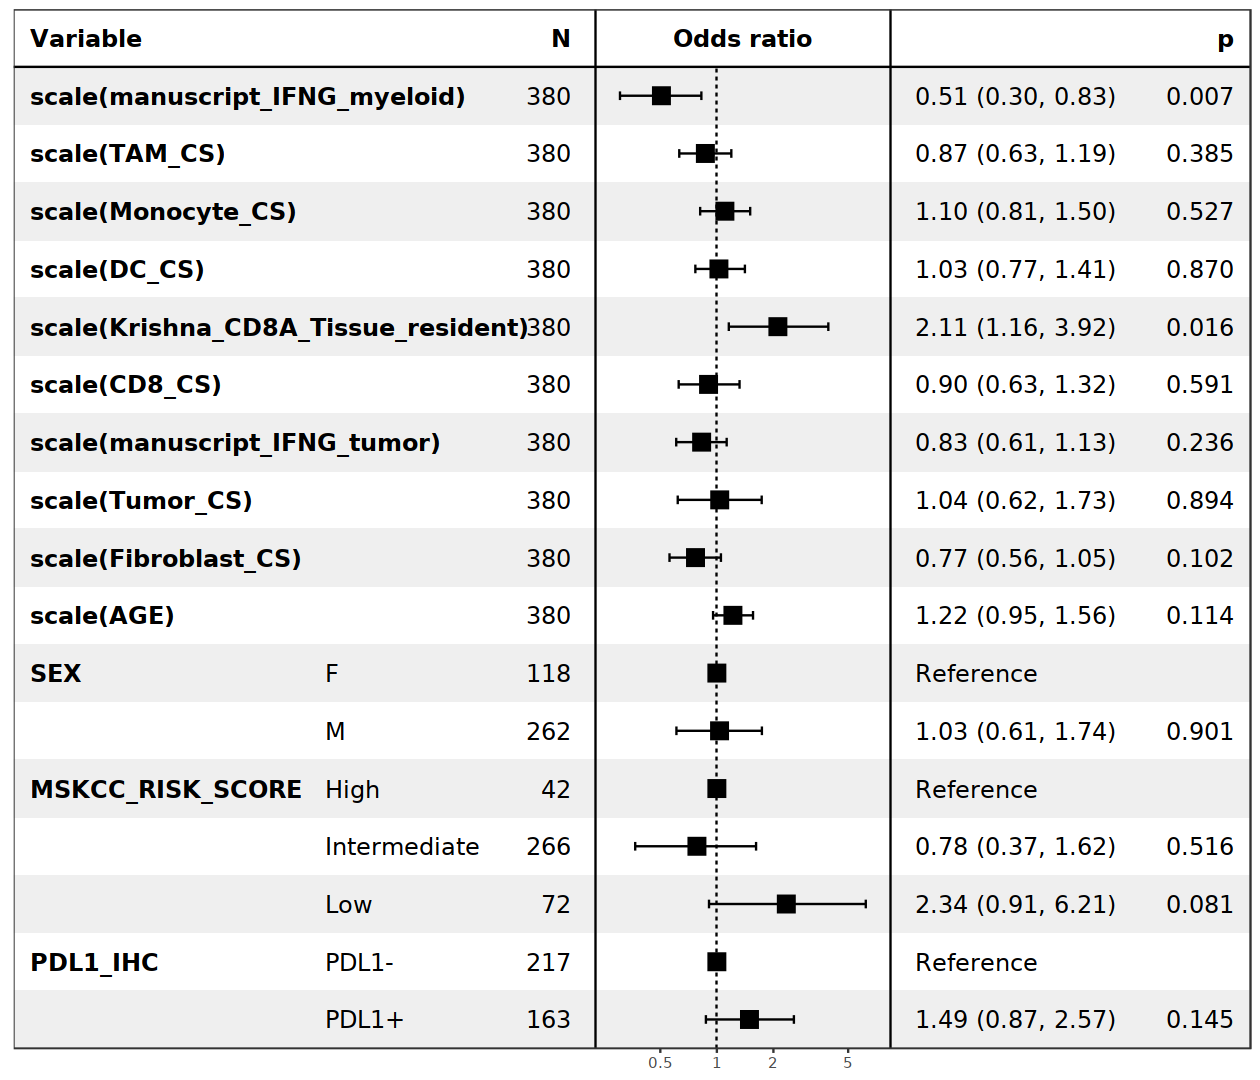

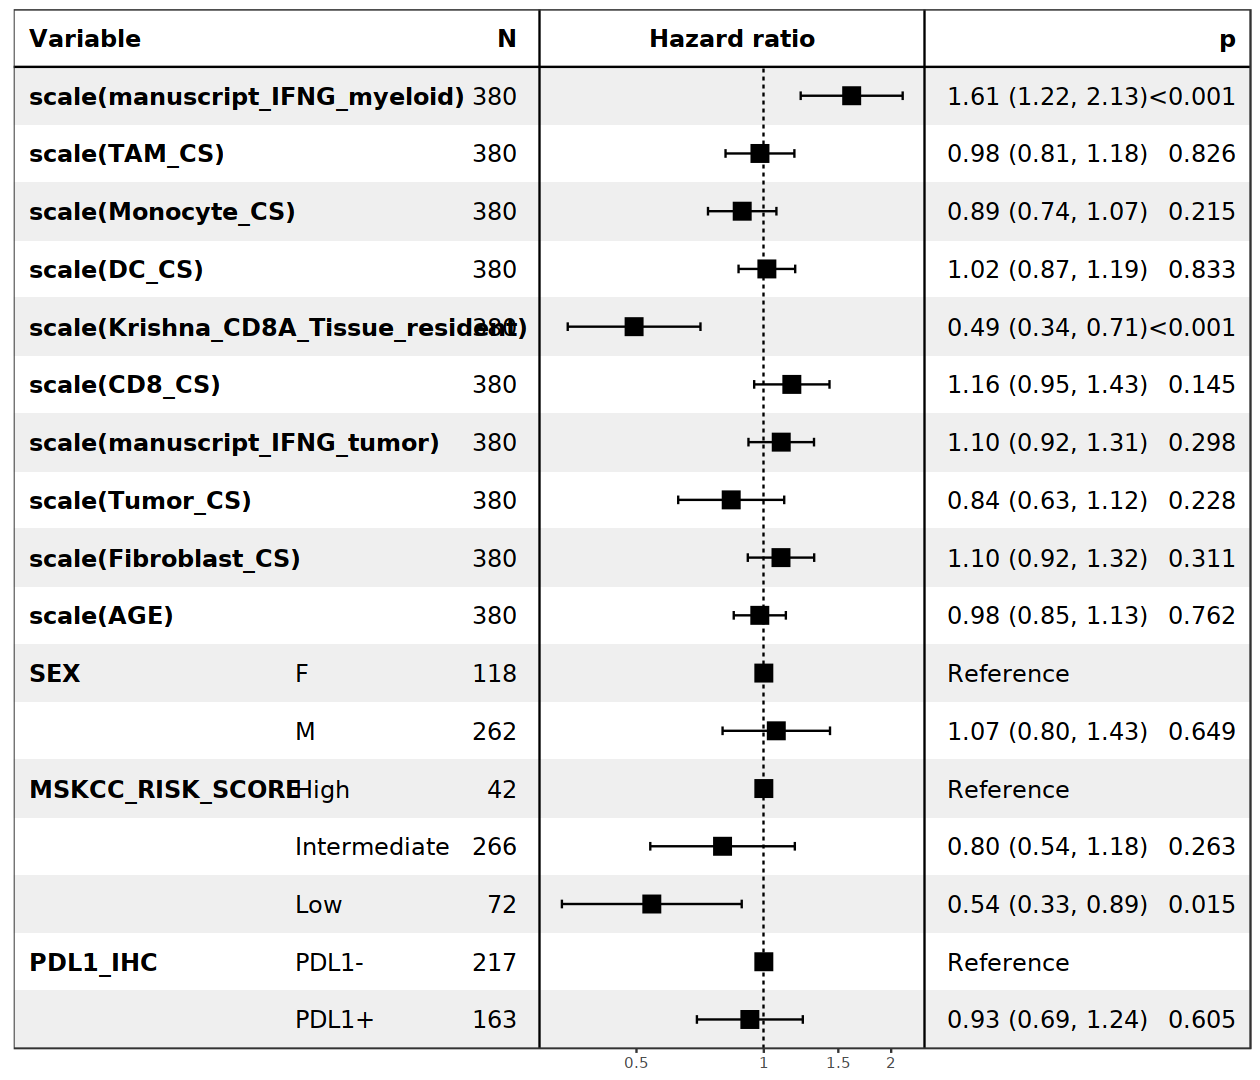

In [91]:
options(repr.plot.width=10.5, repr.plot.height=9)

clin_imm151_full$PDL1_IHC = relevel(factor(clin_imm151_full$PDL1_IHC), ref = "PDL1-")
atezo_bev = subset(clin_imm151_full, ARM == "atezo_bev")

atezo_bev = subset(atezo_bev, OBJECTIVE_RESPONSE %in% c("CR","PD","PR","SD"))
atezo_bev = mutate(atezo_bev, Benefit = ifelse(OBJECTIVE_RESPONSE == "CR","CB",ifelse(OBJECTIVE_RESPONSE == "PR","CB",ifelse(OBJECTIVE_RESPONSE == "PD","NCB",ifelse(OBJECTIVE_RESPONSE == "SD" & PFS_MONTHS >= 6,"CB","NCB")))))
table(atezo_bev$Benefit)

atezo_bev = mutate(atezo_bev, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~ scale(manuscript_IFNG_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, family = "binomial", data = atezo_bev)
#summary(mylogit)
vif(mylogit)
imm151_ifng_lr_io = forest_model(mylogit, panels_lr,recalculate_width = F)
imm151_ifng_lr_io

res.cox <- coxph(Surv(PFS_MONTHS, PFS_CENSOR) ~ scale(manuscript_IFNG_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, data = atezo_bev)
imm151_ifng_cox_io = forest_model(res.cox, panels_cox,recalculate_width = F)
imm151_ifng_cox_io

### Expanded IFN1 signatures in atezo_bev arm


 CB NCB 
263 117 

GVIF     Df GVIF^(1/(2*Df))
scale(manuscript_IFN1_myeloid)      5.207600 1  2.282017       
scale(TAM_CS)                       2.262314 1  1.504099       
scale(Monocyte_CS)                  1.901306 1  1.378879       
scale(DC_CS)                        1.301044 1  1.140633       
scale(Krishna_CD8A_Tissue_resident) 6.607978 1  2.570599       
scale(CD8_CS)                       2.530835 1  1.590860       
scale(manuscript_IFN1_tumor)        2.078050 1  1.441544       
scale(Tumor_CS)                     4.258067 1  2.063508       
scale(Fibroblast_CS)                1.714497 1  1.309388       
scale(AGE)                          1.166389 1  1.079995       
SEX                                 1.082451 1  1.040409       
MSKCC_RISK_SCORE                    1.131049 2  1.031265       
PDL1_IHC                            1.305647 1  1.142649

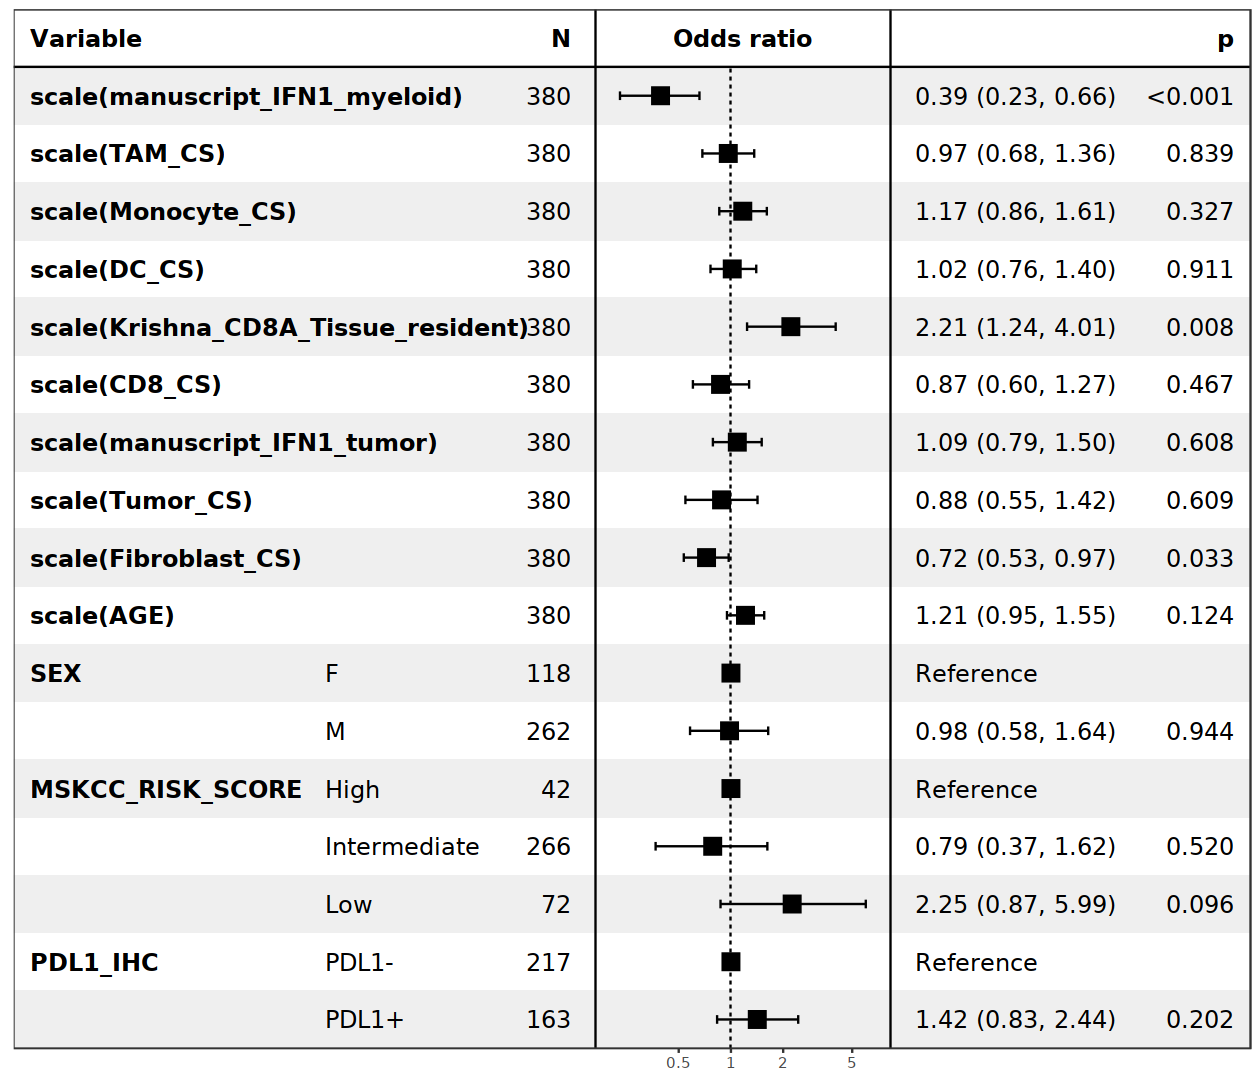

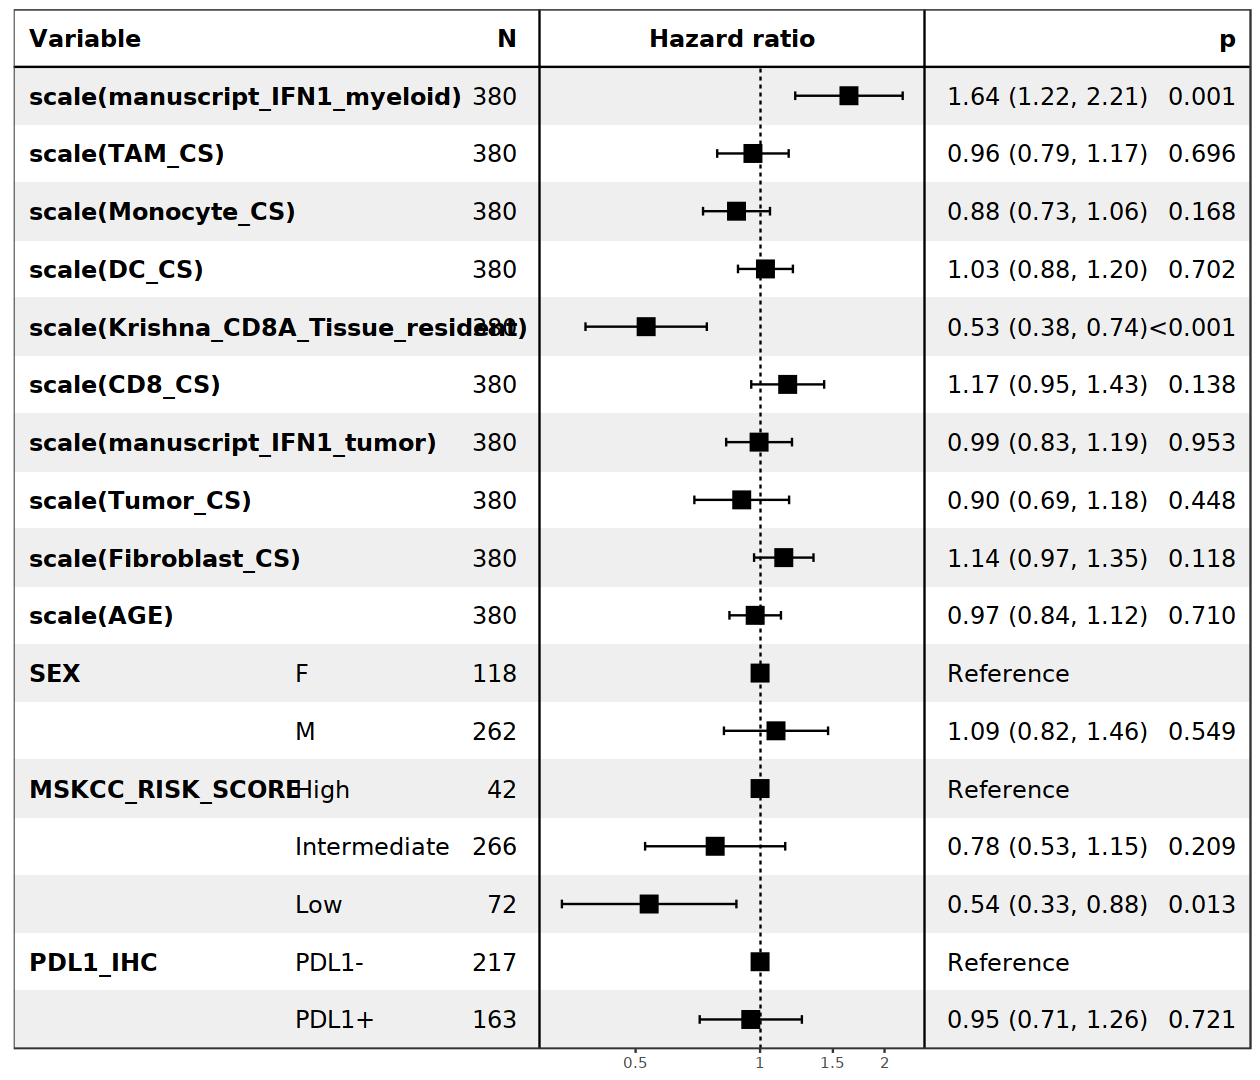

In [92]:
options(repr.plot.width=10.5, repr.plot.height=9)

clin_imm151_full$PDL1_IHC = relevel(factor(clin_imm151_full$PDL1_IHC), ref = "PDL1-")
atezo_bev = subset(clin_imm151_full, ARM == "atezo_bev")

atezo_bev = subset(atezo_bev, OBJECTIVE_RESPONSE %in% c("CR","PD","PR","SD"))
atezo_bev = mutate(atezo_bev, Benefit = ifelse(OBJECTIVE_RESPONSE == "CR","CB",ifelse(OBJECTIVE_RESPONSE == "PR","CB",ifelse(OBJECTIVE_RESPONSE == "PD","NCB",ifelse(OBJECTIVE_RESPONSE == "SD" & PFS_MONTHS >= 6,"CB","NCB")))))
table(atezo_bev$Benefit)

atezo_bev = mutate(atezo_bev, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~ scale(manuscript_IFN1_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFN1_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, family = "binomial", data = atezo_bev)
#summary(mylogit)
vif(mylogit)
imm151_ifn1_lr_io = forest_model(mylogit, panels_lr,recalculate_width = F)
imm151_ifn1_lr_io

res.cox <- coxph(Surv(PFS_MONTHS, PFS_CENSOR) ~ scale(manuscript_IFN1_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFN1_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, data = atezo_bev)
imm151_ifn1_cox_io = forest_model(res.cox, panels_cox,recalculate_width = F)
imm151_ifn1_cox_io

### Expanded combined signatures in atezo_bev arm


 CB NCB 
263 117 

GVIF     Df GVIF^(1/(2*Df))
scale(manuscript_myeloid_combined)  5.159003 1  2.271344       
scale(TAM_CS)                       2.022491 1  1.422143       
scale(Monocyte_CS)                  1.825898 1  1.351258       
scale(DC_CS)                        1.306837 1  1.143170       
scale(Krishna_CD8A_Tissue_resident) 7.118423 1  2.668037       
scale(CD8_CS)                       2.576237 1  1.605066       
scale(manuscript_tumor_combined)    2.101166 1  1.449540       
scale(Tumor_CS)                     5.078865 1  2.253634       
scale(Fibroblast_CS)                1.850058 1  1.360168       
scale(AGE)                          1.155943 1  1.075148       
SEX                                 1.090400 1  1.044222       
MSKCC_RISK_SCORE                    1.135338 2  1.032241       
PDL1_IHC                            1.314111 1  1.146347

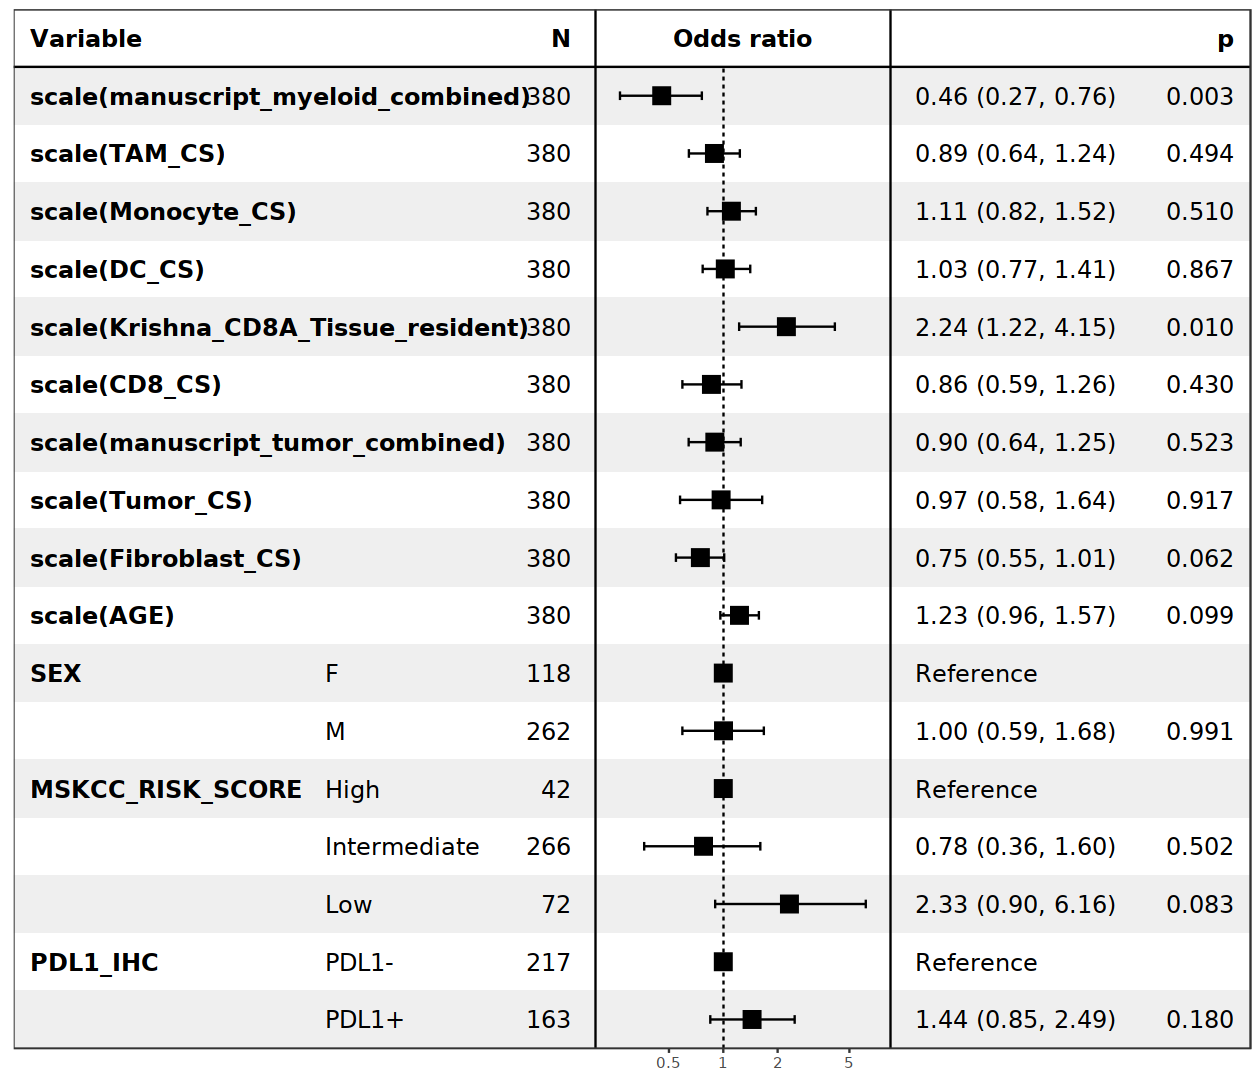

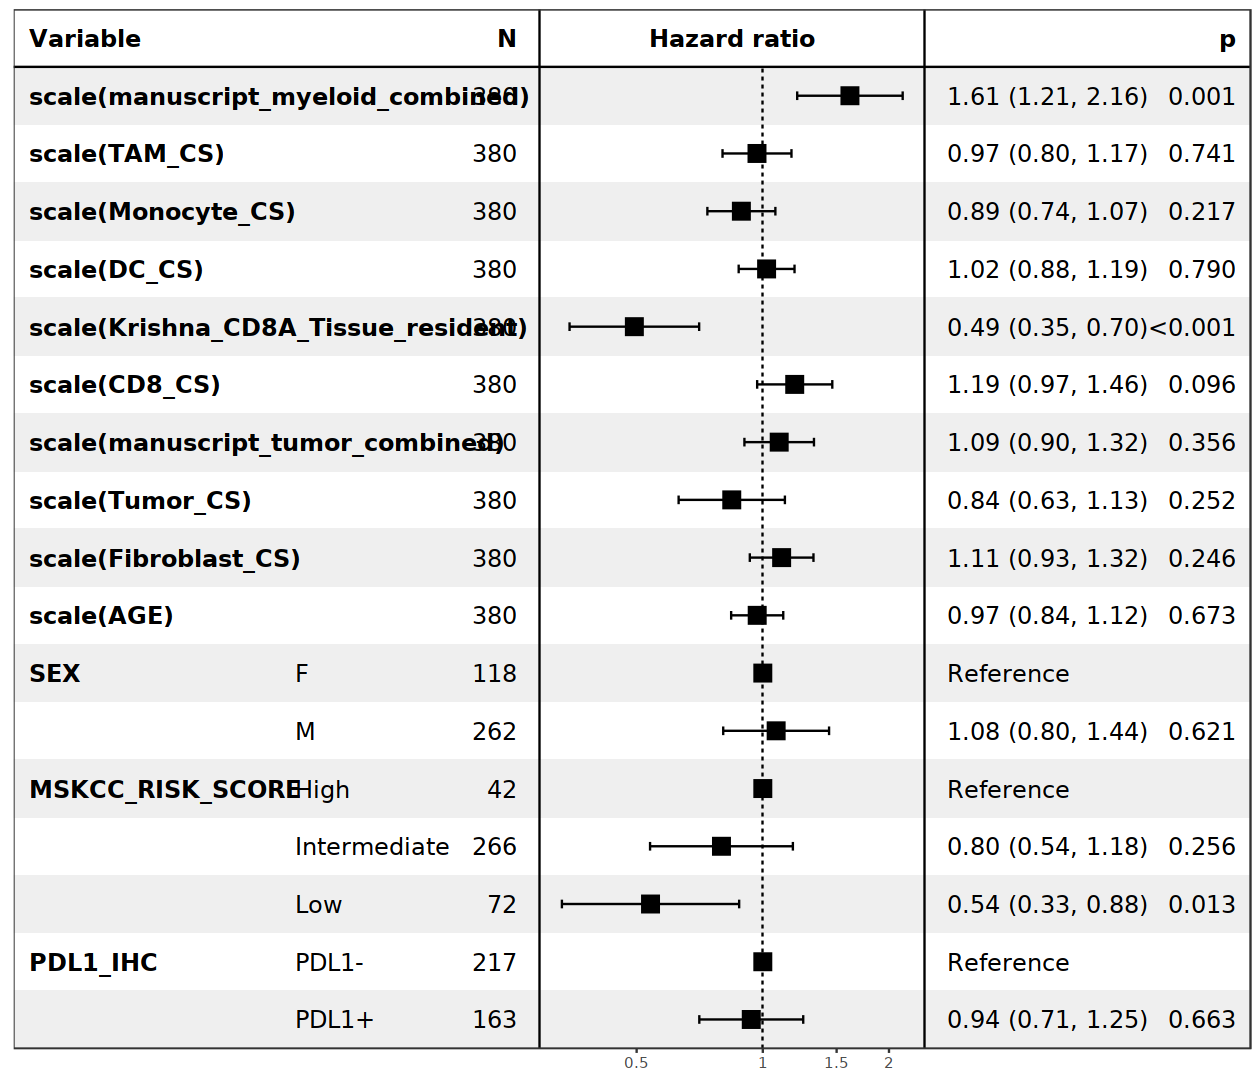

In [93]:
options(repr.plot.width=10.5, repr.plot.height=9)

clin_imm151_full$PDL1_IHC = relevel(factor(clin_imm151_full$PDL1_IHC), ref = "PDL1-")
atezo_bev = subset(clin_imm151_full, ARM == "atezo_bev")

atezo_bev = subset(atezo_bev, OBJECTIVE_RESPONSE %in% c("CR","PD","PR","SD"))
atezo_bev = mutate(atezo_bev, Benefit = ifelse(OBJECTIVE_RESPONSE == "CR","CB",ifelse(OBJECTIVE_RESPONSE == "PR","CB",ifelse(OBJECTIVE_RESPONSE == "PD","NCB",ifelse(OBJECTIVE_RESPONSE == "SD" & PFS_MONTHS >= 6,"CB","NCB")))))
table(atezo_bev$Benefit)

atezo_bev = mutate(atezo_bev, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~ scale(manuscript_myeloid_combined) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_tumor_combined)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, family = "binomial", data = atezo_bev)
#summary(mylogit)
vif(mylogit)
imm151_comb_lr_io = forest_model(mylogit, panels_lr,recalculate_width = F)
imm151_comb_lr_io

res.cox <- coxph(Surv(PFS_MONTHS, PFS_CENSOR) ~ scale(manuscript_myeloid_combined) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_tumor_combined)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, data = atezo_bev)
imm151_comb_cox_io = forest_model(res.cox, panels_cox,recalculate_width = F)
imm151_comb_cox_io

### Expanded IFNg signatures in sunitinib arm


 CB NCB 
255 123 

GVIF     Df GVIF^(1/(2*Df))
scale(manuscript_IFNG_myeloid)      5.105675 1  2.259574       
scale(TAM_CS)                       1.843334 1  1.357694       
scale(Monocyte_CS)                  1.525722 1  1.235201       
scale(DC_CS)                        1.492936 1  1.221858       
scale(Krishna_CD8A_Tissue_resident) 7.254303 1  2.693381       
scale(CD8_CS)                       3.048847 1  1.746095       
scale(manuscript_IFNG_tumor)        1.581527 1  1.257588       
scale(Tumor_CS)                     3.865473 1  1.966081       
scale(Fibroblast_CS)                1.815365 1  1.347355       
scale(AGE)                          1.074379 1  1.036523       
SEX                                 1.138665 1  1.067082       
MSKCC_RISK_SCORE                    1.071099 2  1.017320       
PDL1_IHC                            1.425448 1  1.193921

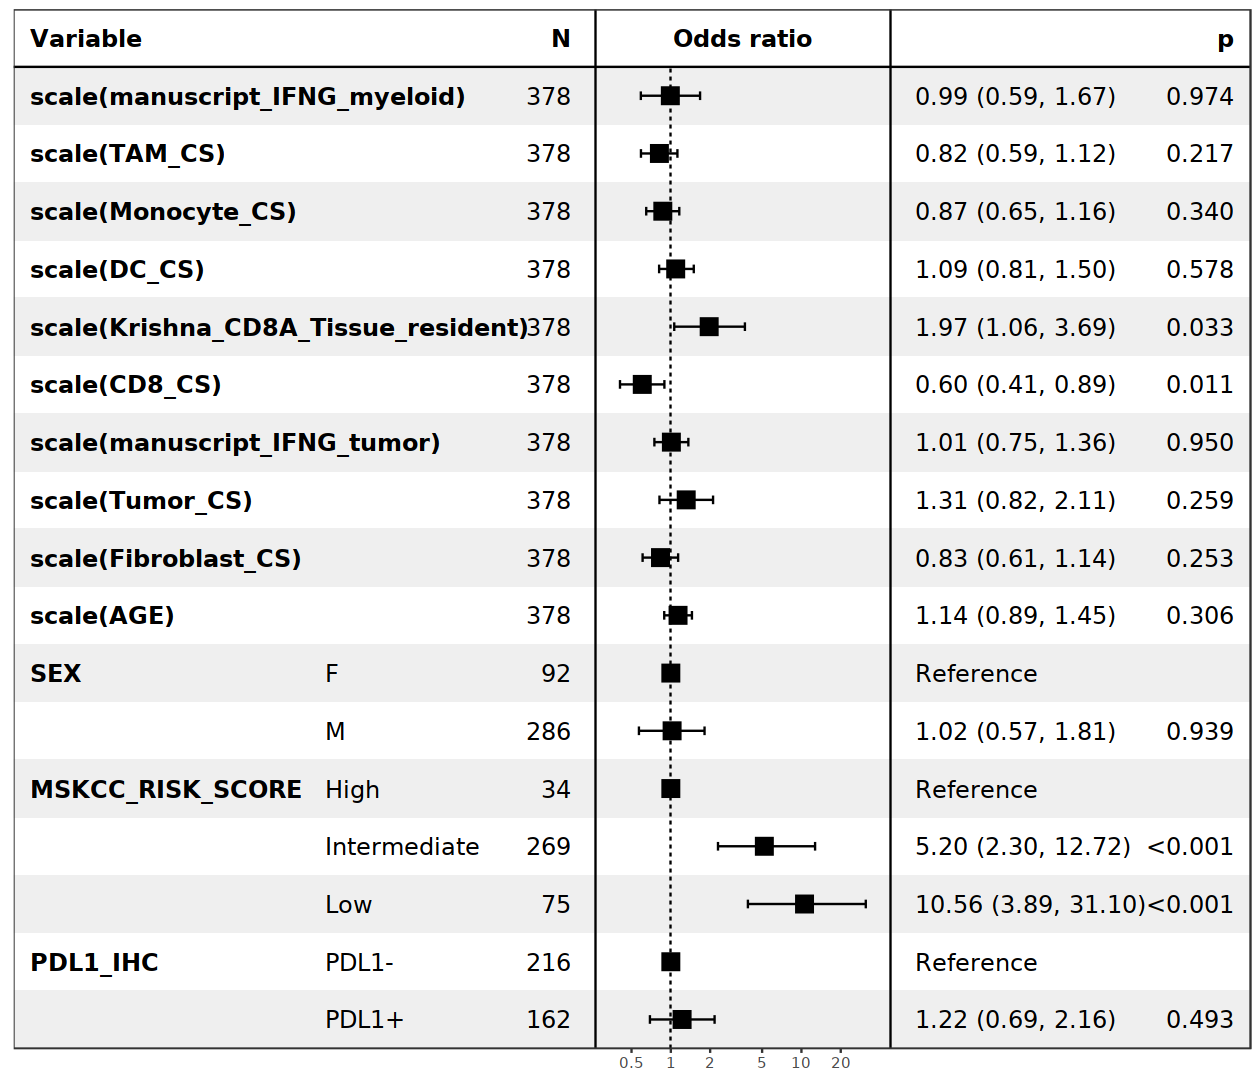

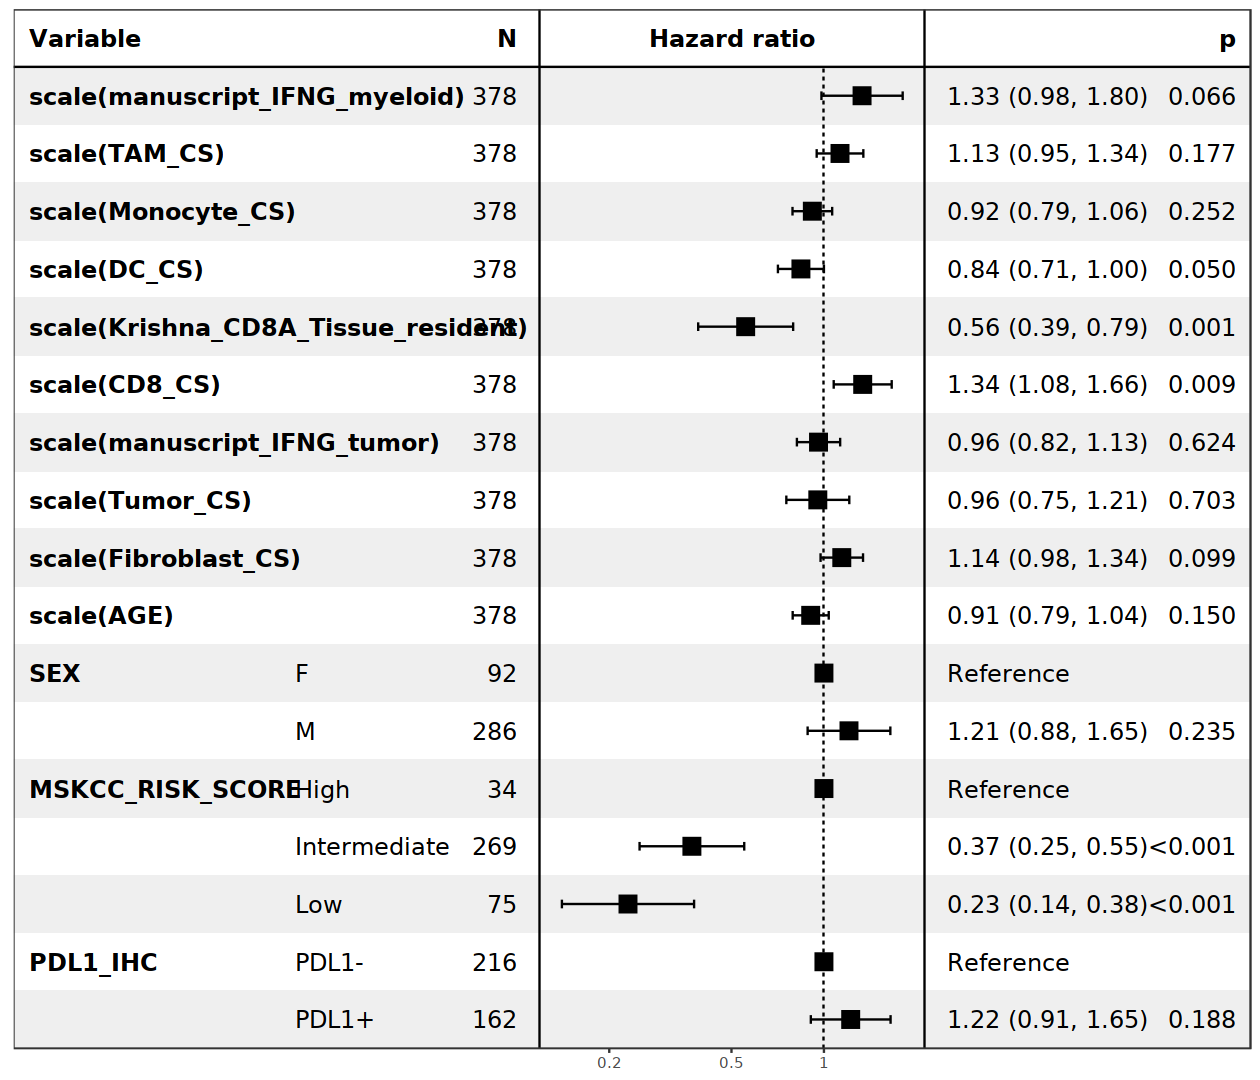

In [94]:
options(repr.plot.width=10.5, repr.plot.height=9)

clin_imm151_full$PDL1_IHC = relevel(factor(clin_imm151_full$PDL1_IHC), ref = "PDL1-")
sunitinib = subset(clin_imm151_full, ARM == "sunitinib")

sunitinib = subset(sunitinib, OBJECTIVE_RESPONSE %in% c("CR","PD","PR","SD"))
sunitinib = mutate(sunitinib, Benefit = ifelse(OBJECTIVE_RESPONSE == "CR","CB",ifelse(OBJECTIVE_RESPONSE == "PR","CB",ifelse(OBJECTIVE_RESPONSE == "PD","NCB",ifelse(OBJECTIVE_RESPONSE == "SD" & PFS_MONTHS >= 6,"CB","NCB")))))
table(sunitinib$Benefit)

sunitinib = mutate(sunitinib, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~ scale(manuscript_IFNG_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, family = "binomial", data = sunitinib)
#summary(mylogit)
vif(mylogit)
imm151_ifng_lr_tki = forest_model(mylogit, panels_lr,recalculate_width = F)
imm151_ifng_lr_tki

res.cox <- coxph(Surv(PFS_MONTHS, PFS_CENSOR) ~ scale(manuscript_IFNG_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, data = sunitinib)
imm151_ifng_cox_tki = forest_model(res.cox, panels_cox,recalculate_width = F)
imm151_ifng_cox_tki

### Expanded IFN1 signatures in sunitinib arm


 CB NCB 
255 123 

GVIF     Df GVIF^(1/(2*Df))
scale(manuscript_IFN1_myeloid)      5.292341 1  2.300509       
scale(TAM_CS)                       2.158750 1  1.469268       
scale(Monocyte_CS)                  1.525953 1  1.235295       
scale(DC_CS)                        1.423028 1  1.192908       
scale(Krishna_CD8A_Tissue_resident) 6.110778 1  2.471999       
scale(CD8_CS)                       3.052552 1  1.747155       
scale(manuscript_IFN1_tumor)        2.017767 1  1.420481       
scale(Tumor_CS)                     4.757921 1  2.181266       
scale(Fibroblast_CS)                1.691094 1  1.300421       
scale(AGE)                          1.068788 1  1.033822       
SEX                                 1.119854 1  1.058232       
MSKCC_RISK_SCORE                    1.080627 2  1.019574       
PDL1_IHC                            1.394161 1  1.180746

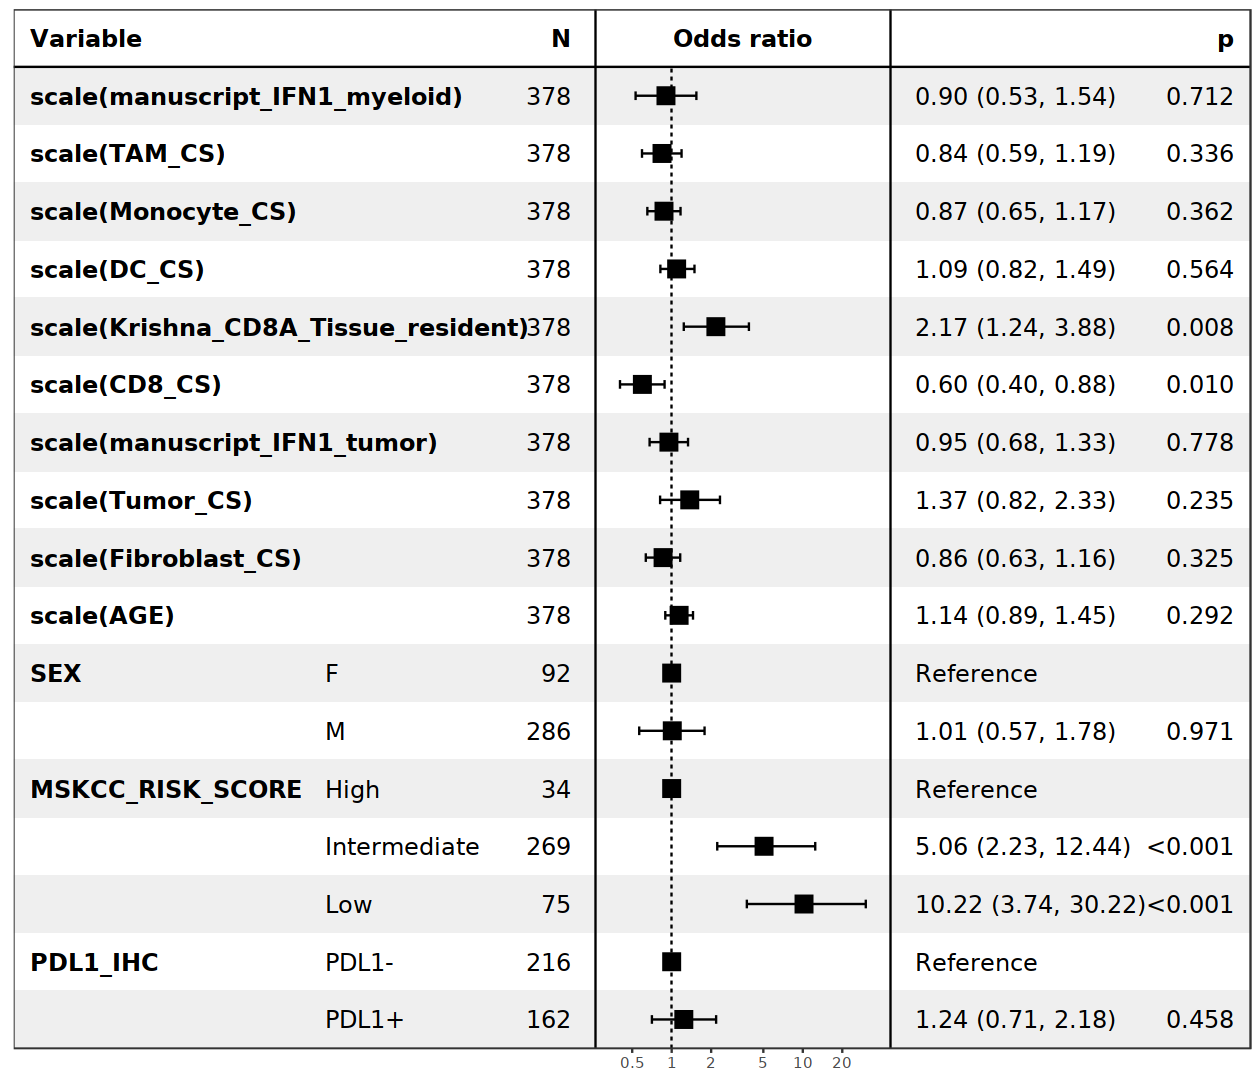

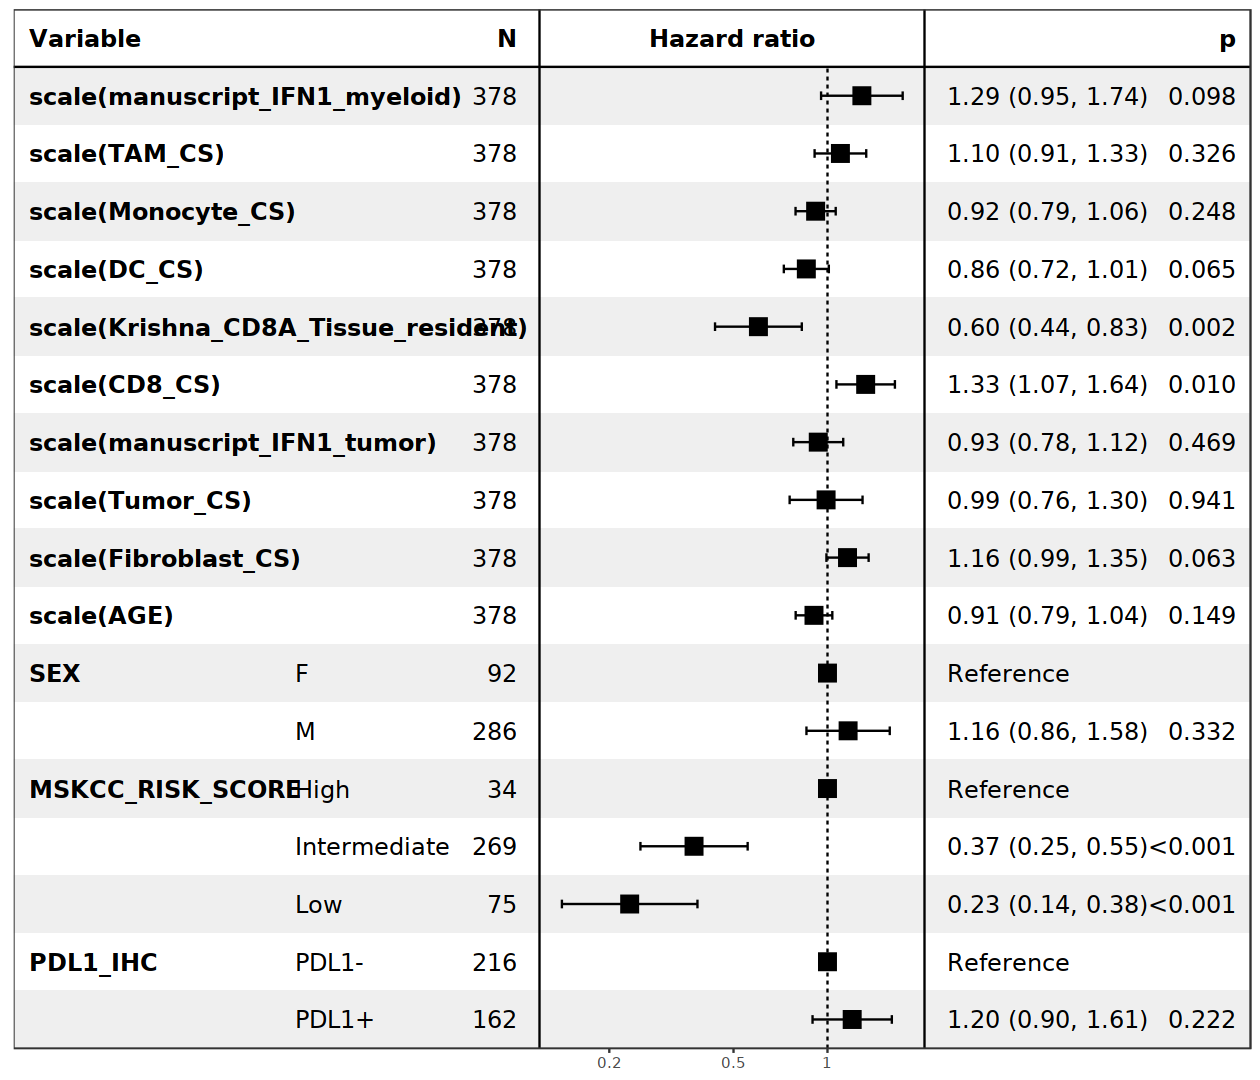

In [95]:
options(repr.plot.width=10.5, repr.plot.height=9)

clin_imm151_full$PDL1_IHC = relevel(factor(clin_imm151_full$PDL1_IHC), ref = "PDL1-")
sunitinib = subset(clin_imm151_full, ARM == "sunitinib")

sunitinib = subset(sunitinib, OBJECTIVE_RESPONSE %in% c("CR","PD","PR","SD"))
sunitinib = mutate(sunitinib, Benefit = ifelse(OBJECTIVE_RESPONSE == "CR","CB",ifelse(OBJECTIVE_RESPONSE == "PR","CB",ifelse(OBJECTIVE_RESPONSE == "PD","NCB",ifelse(OBJECTIVE_RESPONSE == "SD" & PFS_MONTHS >= 6,"CB","NCB")))))
table(sunitinib$Benefit)

sunitinib = mutate(sunitinib, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~ scale(manuscript_IFN1_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFN1_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, family = "binomial", data = sunitinib)
#summary(mylogit)
vif(mylogit)
imm151_ifn1_lr_tki = forest_model(mylogit, panels_lr,recalculate_width = F)
imm151_ifn1_lr_tki

res.cox <- coxph(Surv(PFS_MONTHS, PFS_CENSOR) ~ scale(manuscript_IFN1_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFN1_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, data = sunitinib)
imm151_ifn1_cox_tki = forest_model(res.cox, panels_cox,recalculate_width = F)
imm151_ifn1_cox_tki

### Expanded combined signatures in sunitinib arm


 CB NCB 
255 123 

GVIF     Df GVIF^(1/(2*Df))
scale(manuscript_myeloid_combined)  5.319384 1  2.306379       
scale(TAM_CS)                       2.048119 1  1.431125       
scale(Monocyte_CS)                  1.534683 1  1.238823       
scale(DC_CS)                        1.458379 1  1.207634       
scale(Krishna_CD8A_Tissue_resident) 6.958442 1  2.637886       
scale(CD8_CS)                       3.057415 1  1.748546       
scale(manuscript_tumor_combined)    1.966516 1  1.402325       
scale(Tumor_CS)                     4.634495 1  2.152788       
scale(Fibroblast_CS)                1.809573 1  1.345204       
scale(AGE)                          1.069128 1  1.033986       
SEX                                 1.118509 1  1.057596       
MSKCC_RISK_SCORE                    1.077014 2  1.018721       
PDL1_IHC                            1.398854 1  1.182732

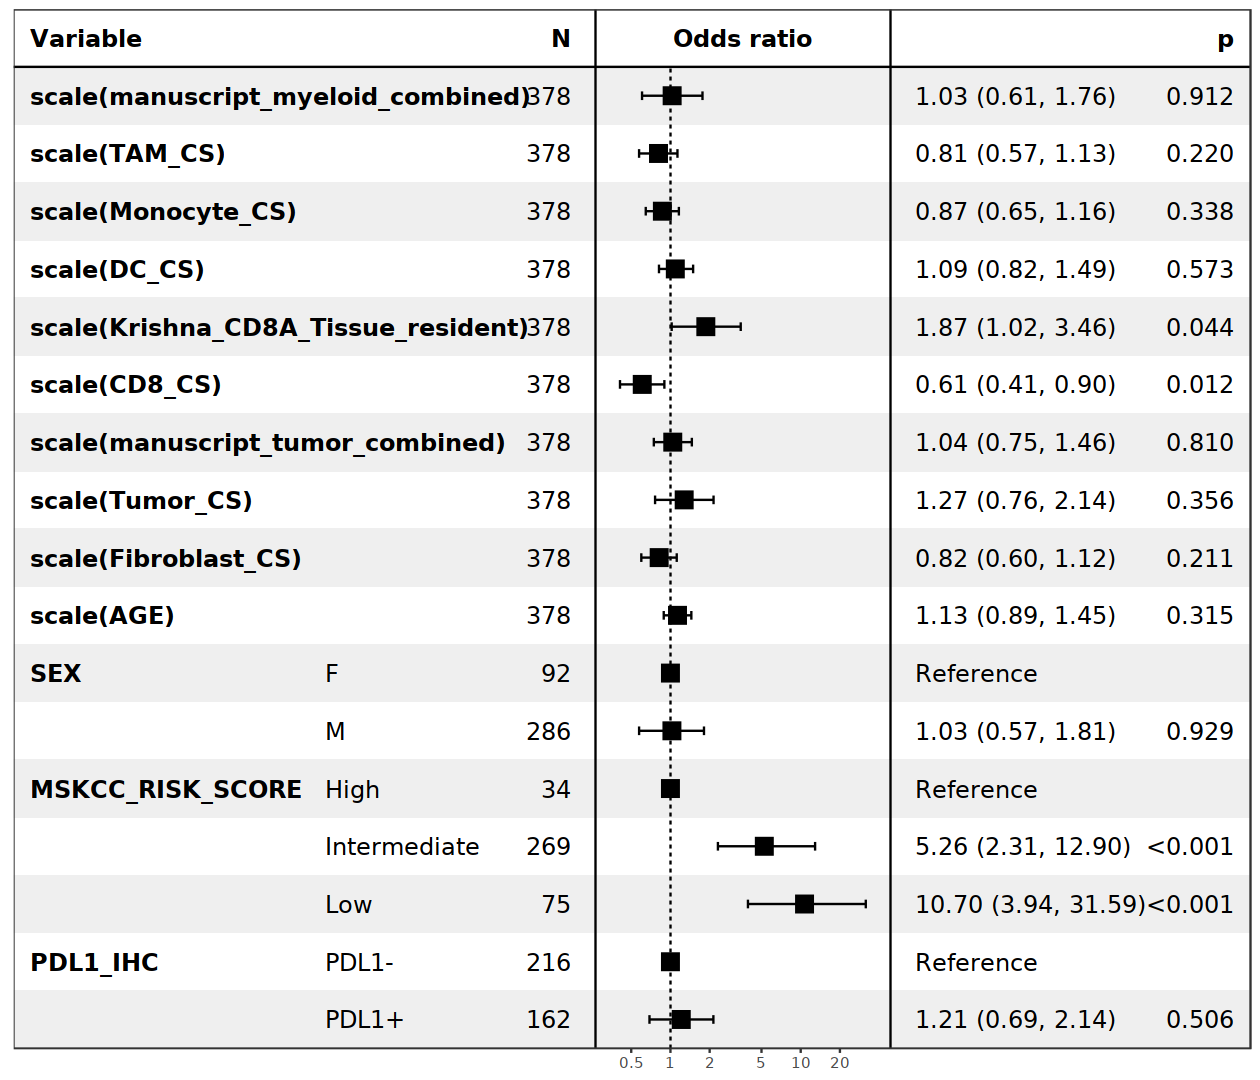

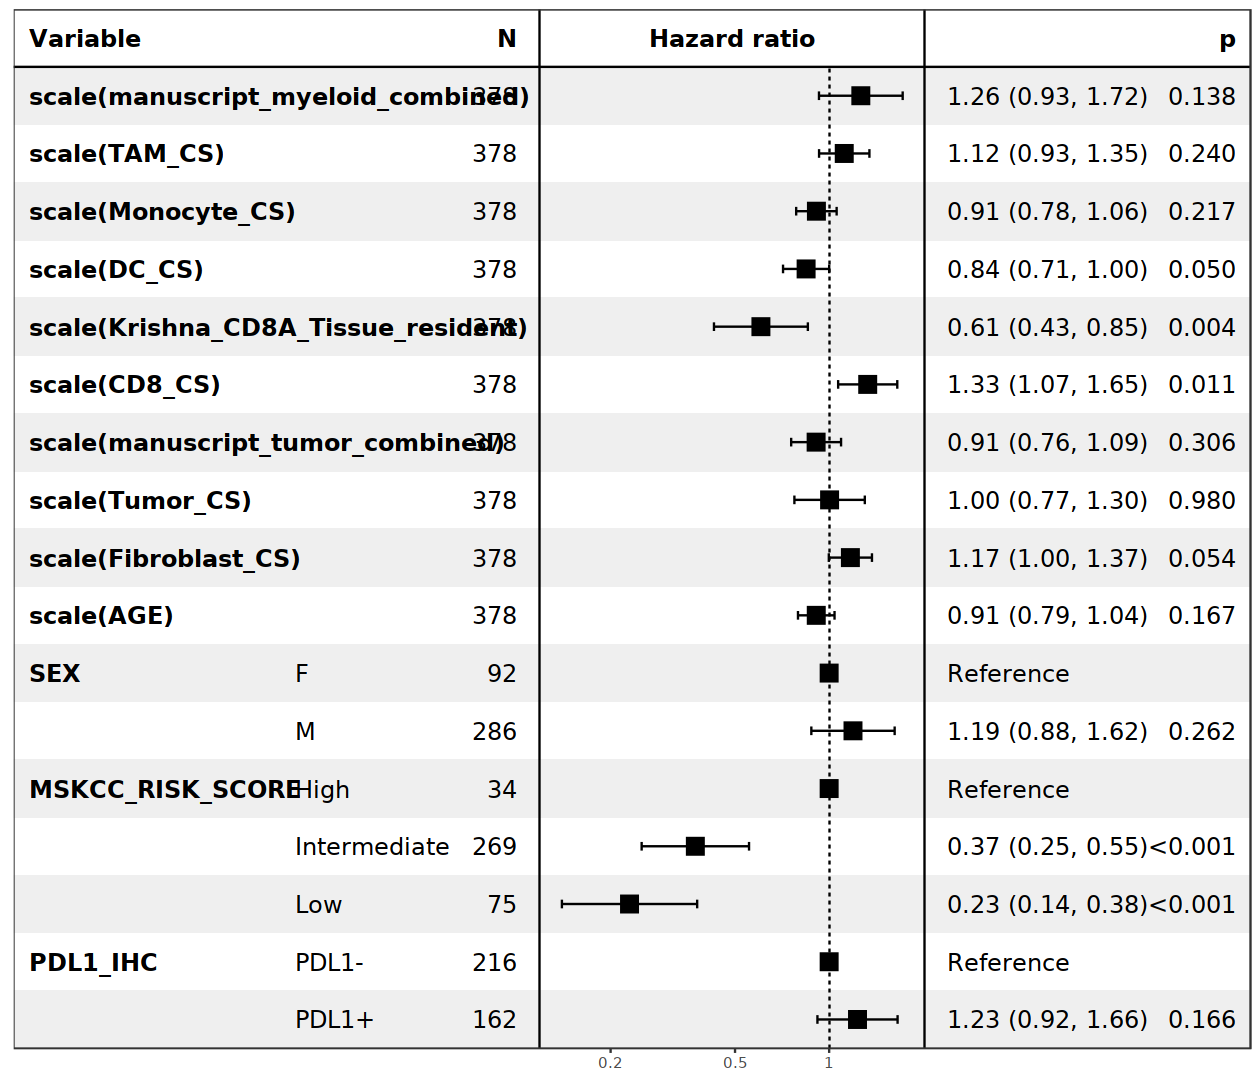

In [96]:
options(repr.plot.width=10.5, repr.plot.height=9)

clin_imm151_full$PDL1_IHC = relevel(factor(clin_imm151_full$PDL1_IHC), ref = "PDL1-")
sunitinib = subset(clin_imm151_full, ARM == "sunitinib")

sunitinib = subset(sunitinib, OBJECTIVE_RESPONSE %in% c("CR","PD","PR","SD"))
sunitinib = mutate(sunitinib, Benefit = ifelse(OBJECTIVE_RESPONSE == "CR","CB",ifelse(OBJECTIVE_RESPONSE == "PR","CB",ifelse(OBJECTIVE_RESPONSE == "PD","NCB",ifelse(OBJECTIVE_RESPONSE == "SD" & PFS_MONTHS >= 6,"CB","NCB")))))
table(sunitinib$Benefit)

sunitinib = mutate(sunitinib, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~ scale(manuscript_myeloid_combined) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_tumor_combined)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, family = "binomial", data = sunitinib)
#summary(mylogit)
vif(mylogit)
imm151_comb_lr_tki = forest_model(mylogit, panels_lr,recalculate_width = F)
imm151_comb_lr_tki

res.cox <- coxph(Surv(PFS_MONTHS, PFS_CENSOR) ~ scale(manuscript_myeloid_combined) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_tumor_combined)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, data = sunitinib)
imm151_comb_cox_tki = forest_model(res.cox, panels_cox,recalculate_width = F)
imm151_comb_cox_tki

### JAV101

In [97]:
clin_jav101_full = readRDS("../../Trial_Cohorts/JAV101/JAV101_Clinical_Metadata_with_SigScores_CIBERSORTx_ExpandedISGs_FigureS10.RDS")

df = data.frame(table(colnames(clin_jav101_full)))
subset(df, Freq > 1)

clin_jav101_full = subset(clin_jav101_full, select = -c(CD8A,Eosinophils,IFIT3, Neutrophils) )

Var1        Freq
14682 CD8A        2   
17979 Eosinophils 2   
21236 IFIT3       2   
27495 Neutrophils 2

### Expanded IFNg signatures in avel + axit arm


 CB NCB 
239  96 

GVIF     Df GVIF^(1/(2*Df))
scale(manuscript_IFNG_myeloid)      7.134339 1  2.671018       
scale(TAM_CS)                       2.001049 1  1.414584       
scale(Monocyte_CS)                  1.710099 1  1.307708       
scale(DC_CS)                        1.423595 1  1.193145       
scale(Krishna_CD8A_Tissue_resident) 7.511367 1  2.740687       
scale(CD8_CS)                       1.715043 1  1.309597       
scale(manuscript_IFNG_tumor)        2.097024 1  1.448111       
scale(Tumor_CS)                     3.602225 1  1.897953       
scale(Fibroblast_CS)                2.011087 1  1.418128       
scale(Age)                          1.052908 1  1.026113       
Sex                                 1.054789 1  1.027029       
MSKCC                               1.133365 2  1.031793       
PDL1_status_v1                      1.204979 1  1.097715

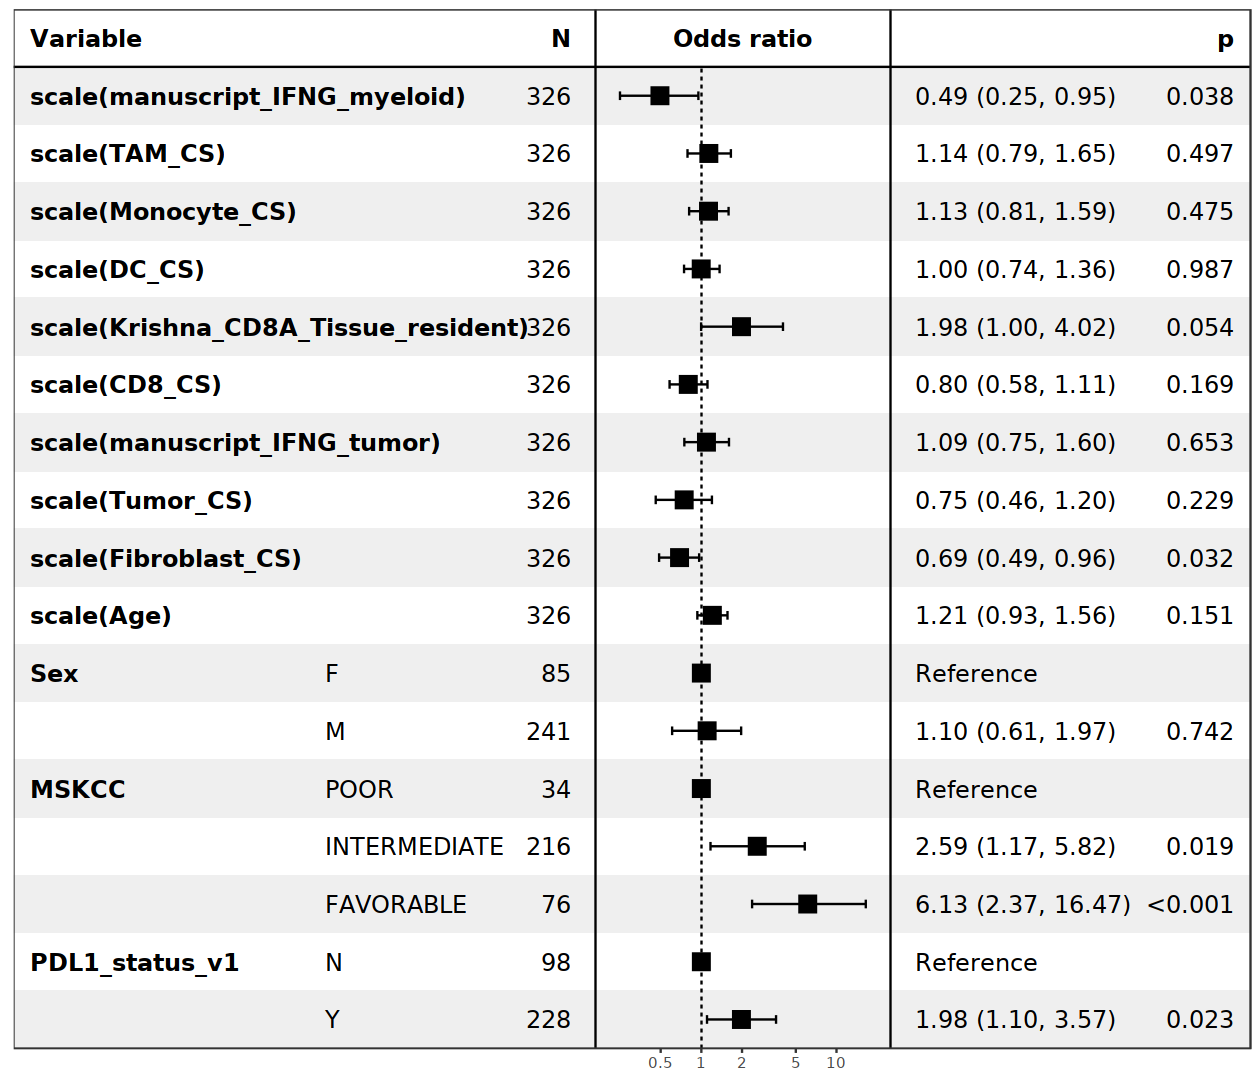

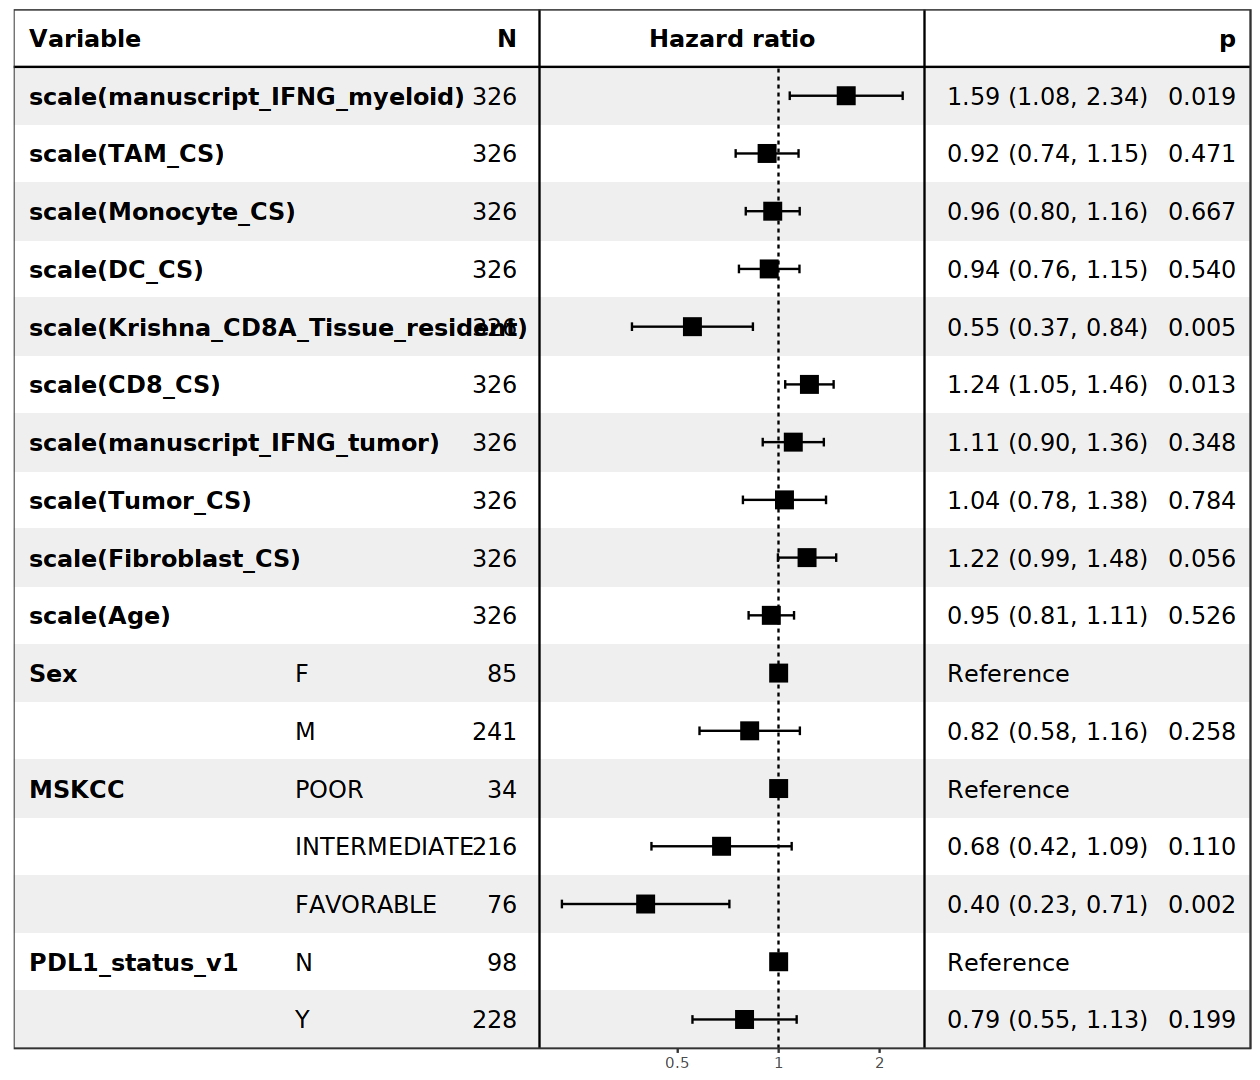

In [98]:
options(repr.plot.width=10.5, repr.plot.height=9)

avel_axit = subset(clin_jav101_full, Arm == "Avelumab + Axitinib")

avel_axit = subset(avel_axit, ORR %in% c("CR","PD","PR","SD"))
avel_axit = mutate(avel_axit, Benefit = ifelse(ORR == "CR","CB",ifelse(ORR == "PR","CB",ifelse(ORR == "PD","NCB",ifelse(ORR == "SD" & PFS >= 6,"CB","NCB")))))
table(avel_axit$Benefit)

avel_axit = mutate(avel_axit, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~  scale(manuscript_IFNG_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, family = "binomial", data = avel_axit)
#summary(mylogit)
vif(mylogit)
jav101_ifng_lr_io = forest_model(mylogit, panels_lr,recalculate_width = F)
jav101_ifng_lr_io

res.cox <- coxph(Surv(PFS, PFS_CNSR) ~  scale(manuscript_IFNG_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, data = avel_axit)
jav101_ifng_cox_io = forest_model(res.cox, panels_cox,recalculate_width = F)
jav101_ifng_cox_io


### Expanded IFN1 signatures in avel + axit arm


 CB NCB 
239  96 

GVIF     Df GVIF^(1/(2*Df))
scale(manuscript_IFN1_myeloid)      7.941898 1  2.818137       
scale(TAM_CS)                       3.098045 1  1.760126       
scale(Monocyte_CS)                  1.887756 1  1.373956       
scale(DC_CS)                        1.436698 1  1.198623       
scale(Krishna_CD8A_Tissue_resident) 5.739780 1  2.395784       
scale(CD8_CS)                       1.663991 1  1.289958       
scale(manuscript_IFN1_tumor)        2.368224 1  1.538904       
scale(Tumor_CS)                     3.342016 1  1.828118       
scale(Fibroblast_CS)                1.674405 1  1.293988       
scale(Age)                          1.055041 1  1.027152       
Sex                                 1.063093 1  1.031064       
MSKCC                               1.120847 2  1.028932       
PDL1_status_v1                      1.197371 1  1.094244

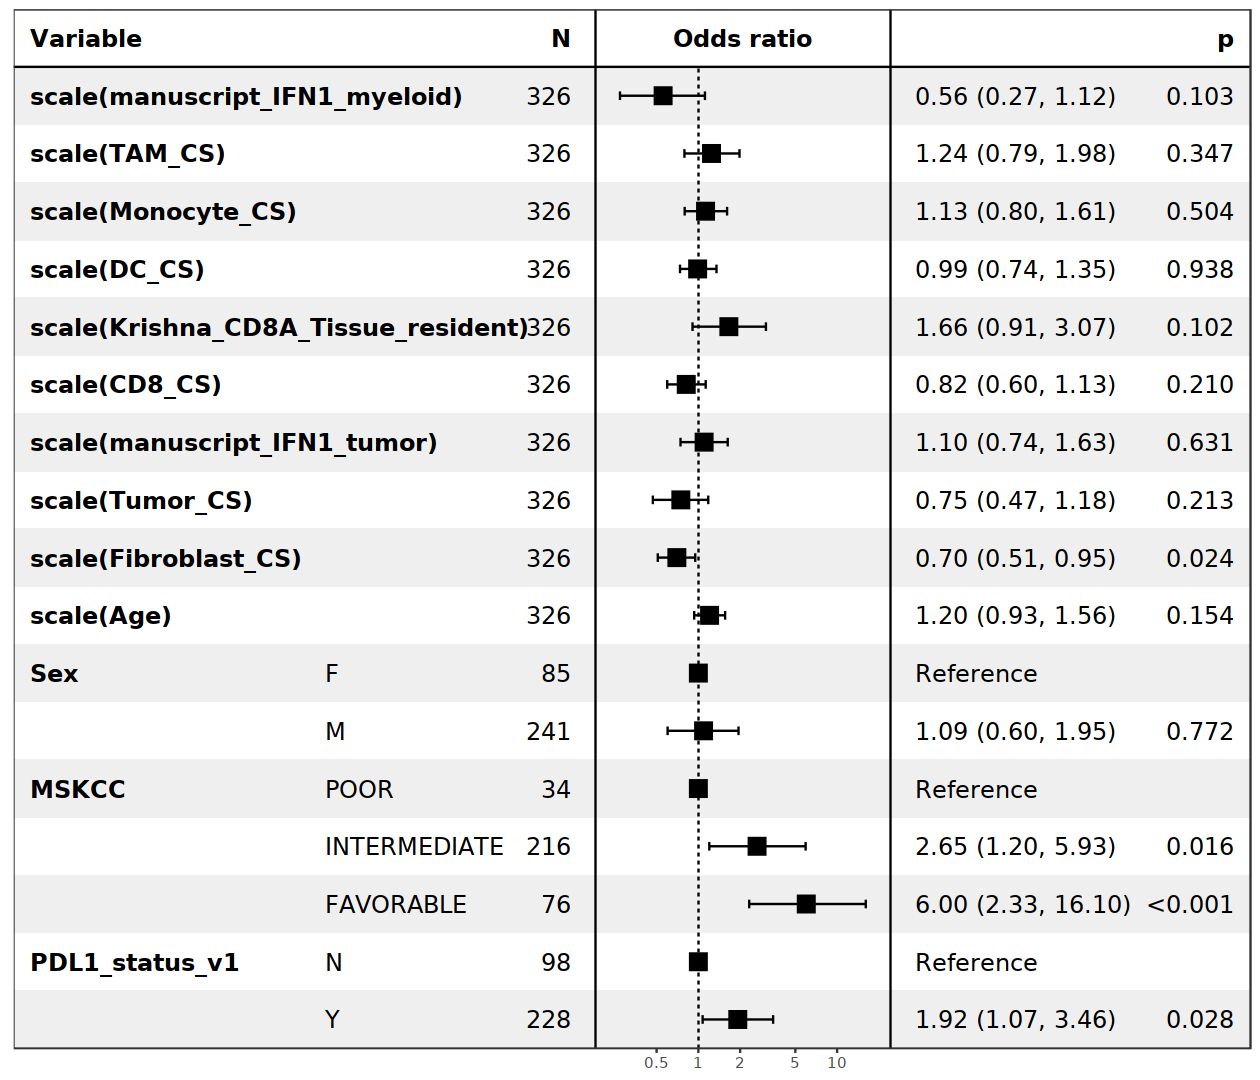

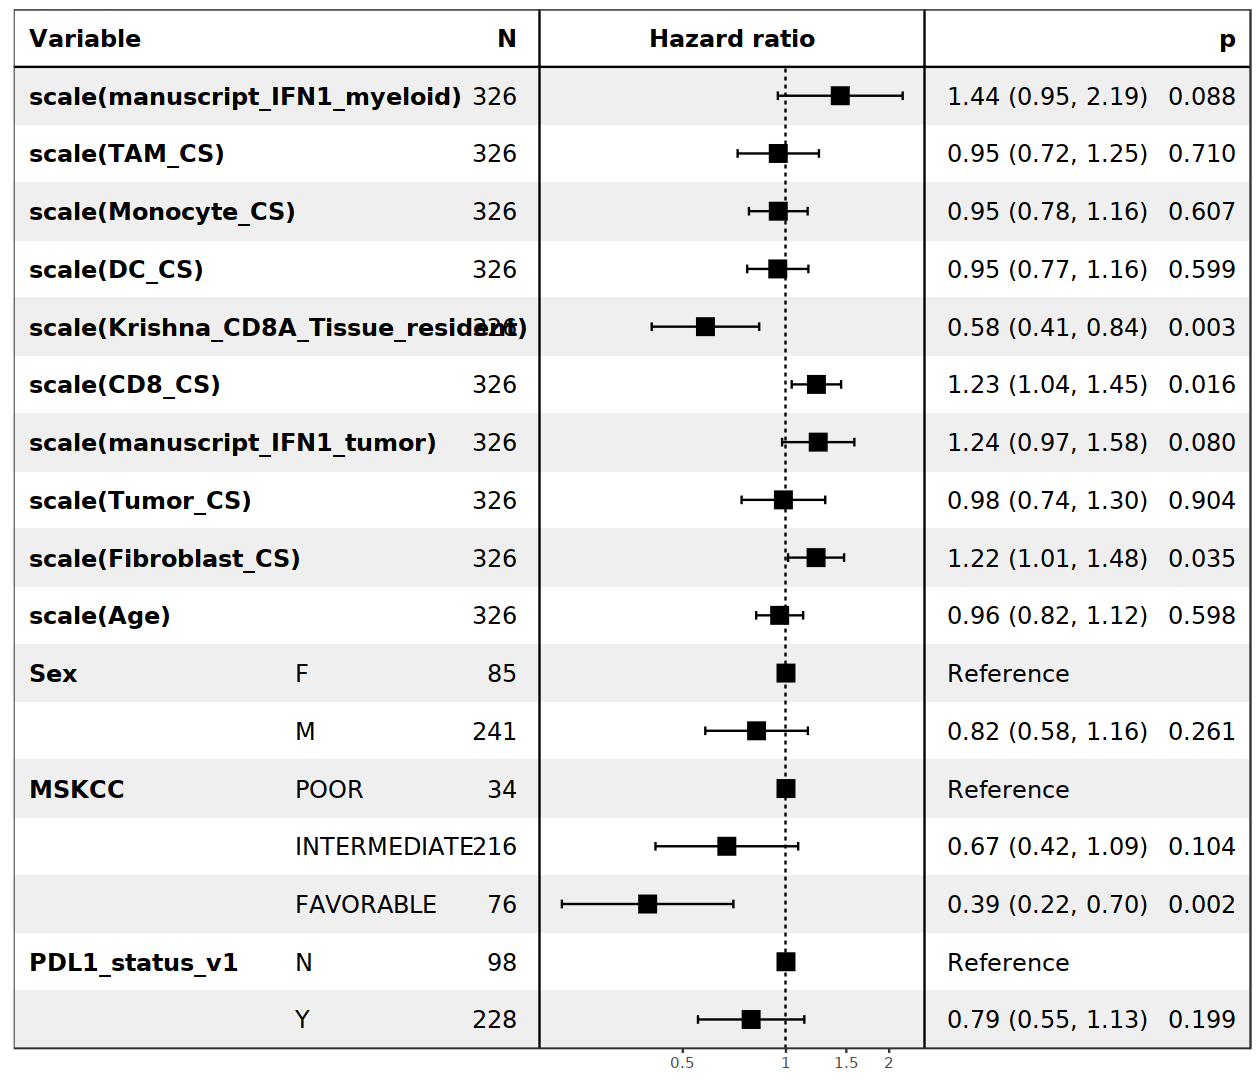

In [99]:
options(repr.plot.width=10.5, repr.plot.height=9)

avel_axit = subset(clin_jav101_full, Arm == "Avelumab + Axitinib")

avel_axit = subset(avel_axit, ORR %in% c("CR","PD","PR","SD"))
avel_axit = mutate(avel_axit, Benefit = ifelse(ORR == "CR","CB",ifelse(ORR == "PR","CB",ifelse(ORR == "PD","NCB",ifelse(ORR == "SD" & PFS >= 6,"CB","NCB")))))
table(avel_axit$Benefit)

avel_axit = mutate(avel_axit, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~  scale(manuscript_IFN1_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFN1_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, family = "binomial", data = avel_axit)
#summary(mylogit)
vif(mylogit)
jav101_ifn1_lr_io = forest_model(mylogit, panels_lr,recalculate_width = F)
jav101_ifn1_lr_io

res.cox <- coxph(Surv(PFS, PFS_CNSR) ~  scale(manuscript_IFN1_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFN1_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, data = avel_axit)
jav101_ifn1_cox_io = forest_model(res.cox, panels_cox,recalculate_width = F)
jav101_ifn1_cox_io


### Expanded combined signatures in avel + axit arm


 CB NCB 
239  96 

GVIF     Df GVIF^(1/(2*Df))
scale(manuscript_myeloid_combined)  8.360488 1  2.891451       
scale(TAM_CS)                       2.404466 1  1.550634       
scale(Monocyte_CS)                  1.821647 1  1.349684       
scale(DC_CS)                        1.439216 1  1.199673       
scale(Krishna_CD8A_Tissue_resident) 6.927767 1  2.632065       
scale(CD8_CS)                       1.720126 1  1.311536       
scale(manuscript_tumor_combined)    2.703364 1  1.644191       
scale(Tumor_CS)                     4.013055 1  2.003261       
scale(Fibroblast_CS)                1.889755 1  1.374684       
scale(Age)                          1.055593 1  1.027421       
Sex                                 1.054707 1  1.026989       
MSKCC                               1.130788 2  1.031206       
PDL1_status_v1                      1.204670 1  1.097575

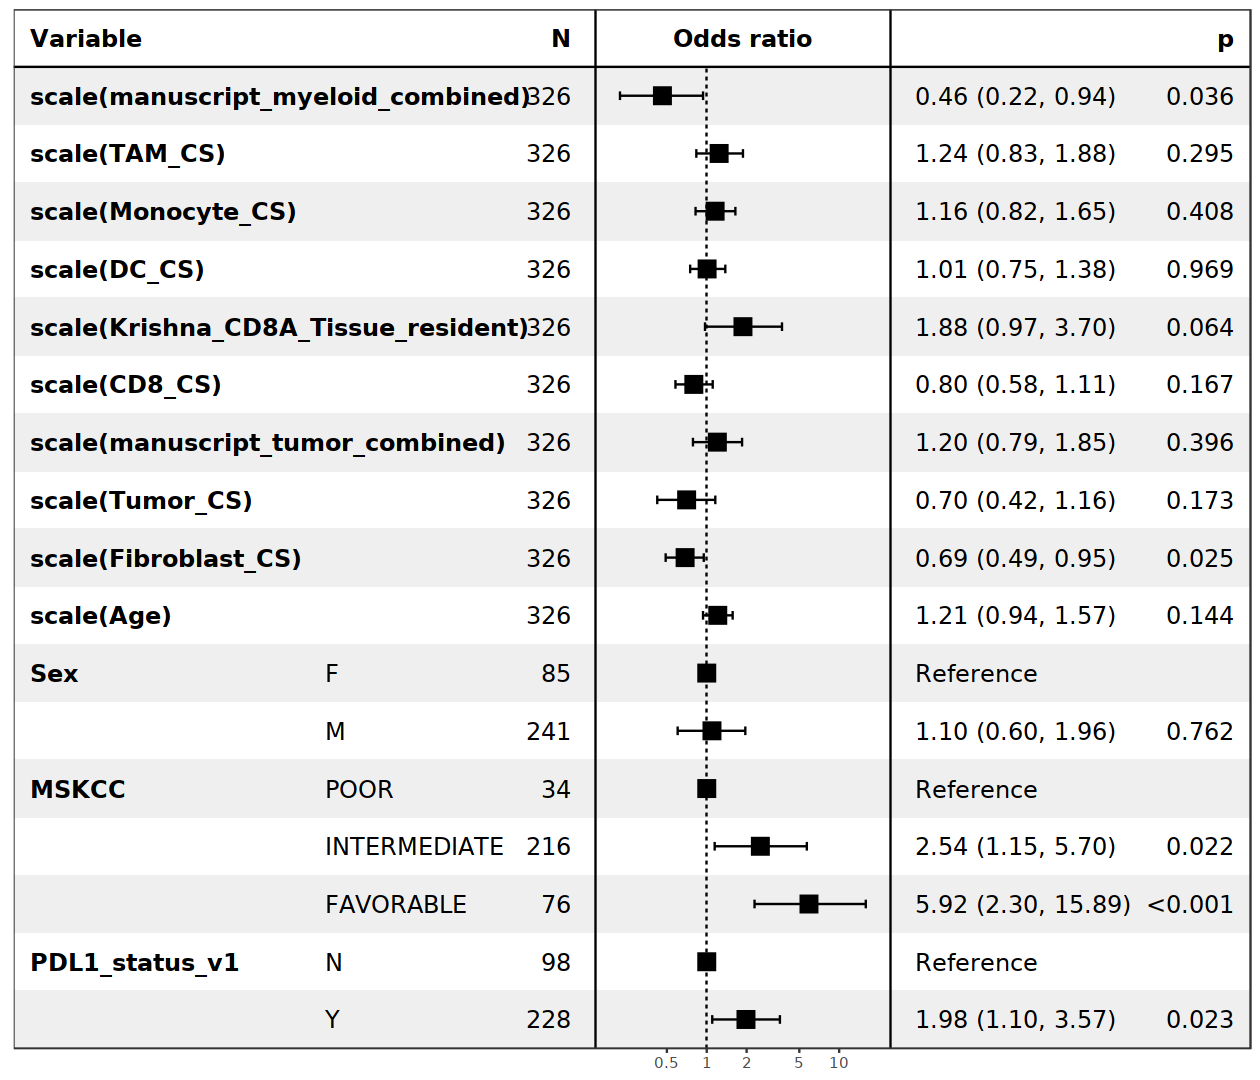

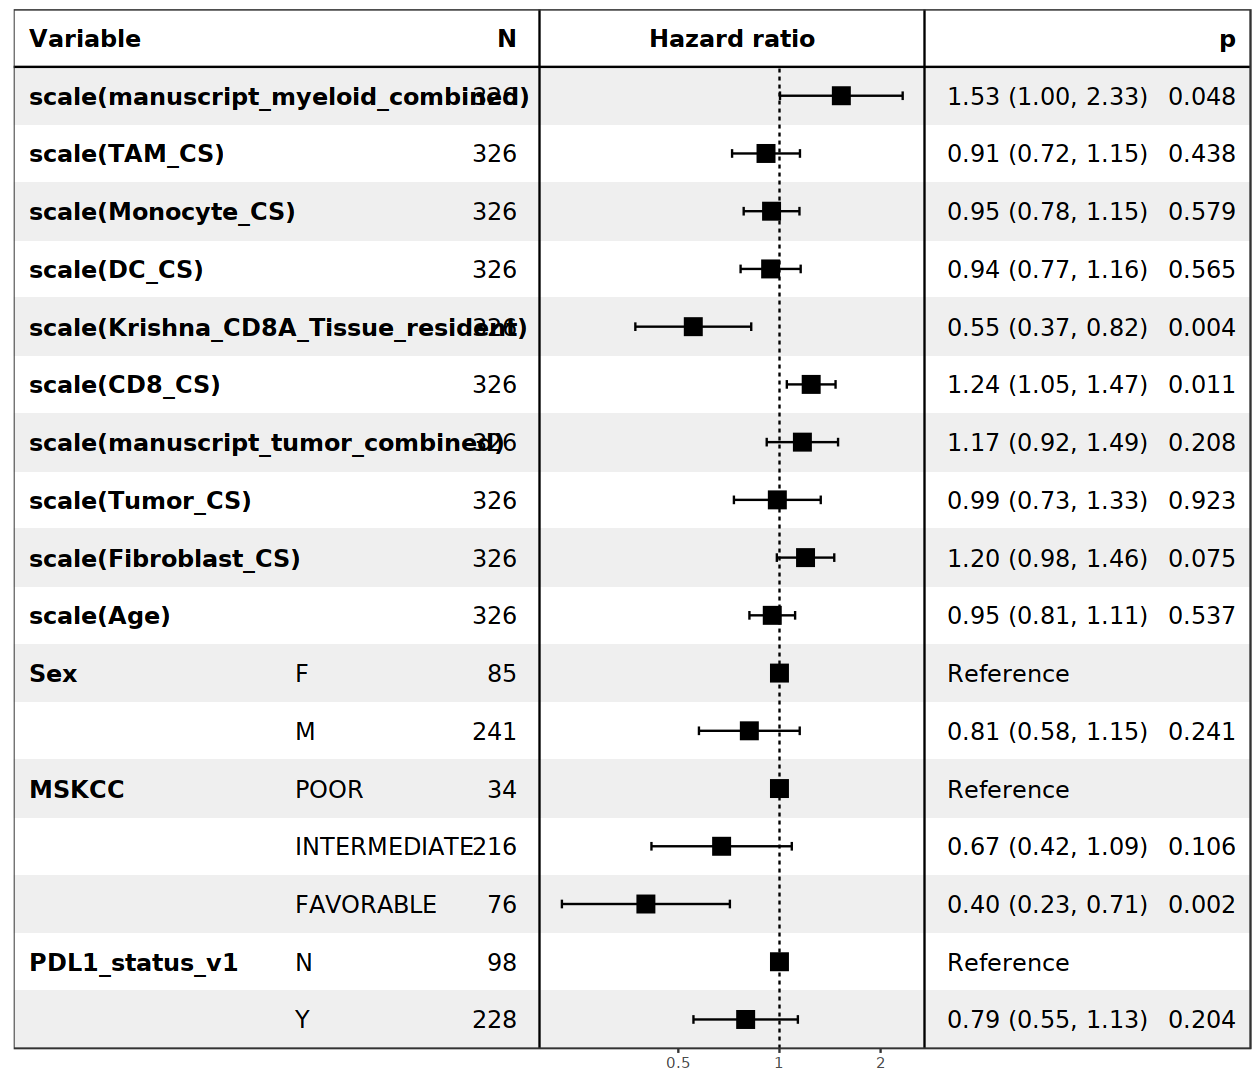

In [100]:
options(repr.plot.width=10.5, repr.plot.height=9)

avel_axit = subset(clin_jav101_full, Arm == "Avelumab + Axitinib")

avel_axit = subset(avel_axit, ORR %in% c("CR","PD","PR","SD"))
avel_axit = mutate(avel_axit, Benefit = ifelse(ORR == "CR","CB",ifelse(ORR == "PR","CB",ifelse(ORR == "PD","NCB",ifelse(ORR == "SD" & PFS >= 6,"CB","NCB")))))
table(avel_axit$Benefit)

avel_axit = mutate(avel_axit, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~  scale(manuscript_myeloid_combined) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_tumor_combined)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, family = "binomial", data = avel_axit)
#summary(mylogit)
vif(mylogit)
jav101_comb_lr_io = forest_model(mylogit, panels_lr,recalculate_width = F)
jav101_comb_lr_io

res.cox <- coxph(Surv(PFS, PFS_CNSR) ~  scale(manuscript_myeloid_combined) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_tumor_combined)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, data = avel_axit)
jav101_comb_cox_io = forest_model(res.cox, panels_cox,recalculate_width = F)
jav101_comb_cox_io


### Expanded IFNg signatures in sunitinib arm


 CB NCB 
182 161 

GVIF     Df GVIF^(1/(2*Df))
scale(manuscript_IFNG_myeloid)      7.452778 1  2.729978       
scale(TAM_CS)                       1.772212 1  1.331245       
scale(Monocyte_CS)                  1.810697 1  1.345621       
scale(DC_CS)                        1.392134 1  1.179887       
scale(Krishna_CD8A_Tissue_resident) 7.524810 1  2.743139       
scale(CD8_CS)                       1.823675 1  1.350435       
scale(manuscript_IFNG_tumor)        1.993697 1  1.411983       
scale(Tumor_CS)                     3.397017 1  1.843100       
scale(Fibroblast_CS)                1.639460 1  1.280414       
scale(Age)                          1.028521 1  1.014160       
Sex                                 1.043225 1  1.021384       
MSKCC                               1.075811 2  1.018437       
PDL1_status_v1                      1.169003 1  1.081204

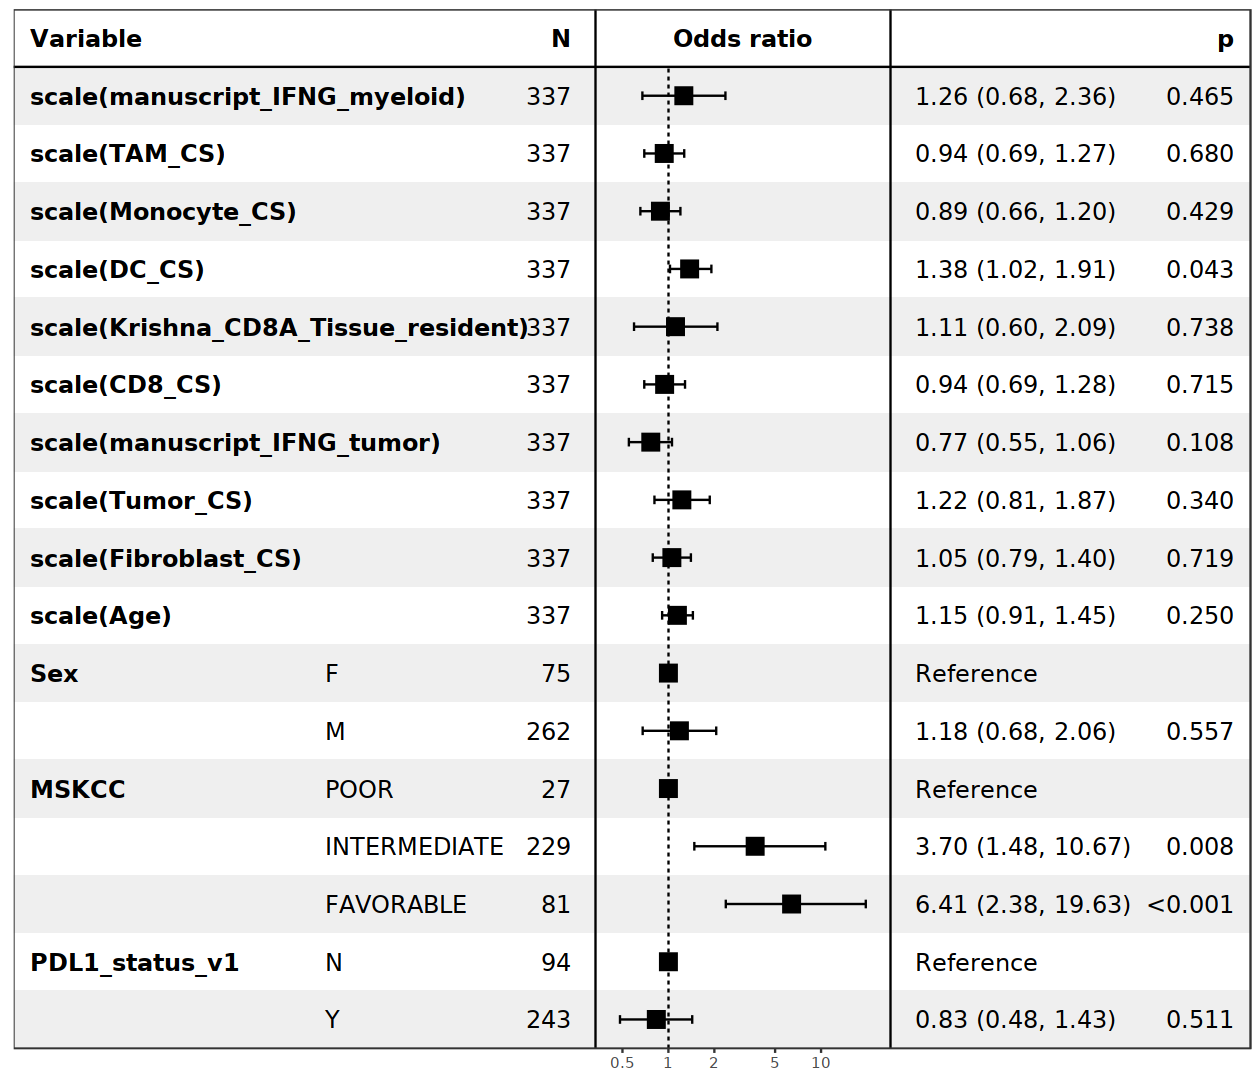

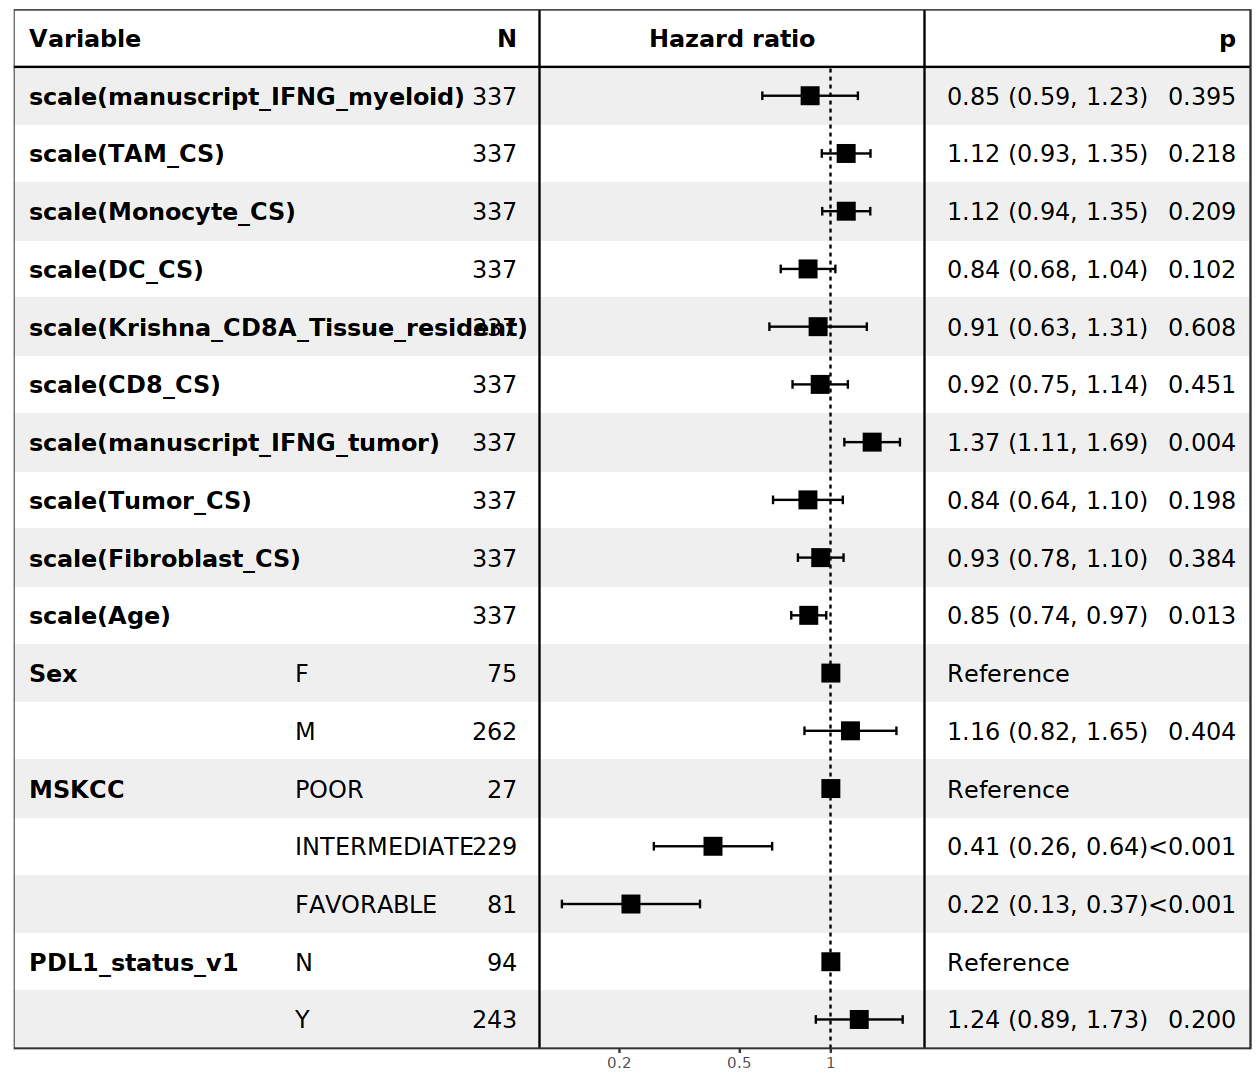

In [101]:
options(repr.plot.width=10.5, repr.plot.height=9)

sunitinib = subset(clin_jav101_full, Arm == "Sunitinib")

sunitinib = subset(sunitinib, ORR %in% c("CR","PD","PR","SD"))
sunitinib = mutate(sunitinib, Benefit = ifelse(ORR == "CR","CB",ifelse(ORR == "PR","CB",ifelse(ORR == "PD","NCB",ifelse(ORR == "SD" & PFS >= 6,"CB","NCB")))))
table(sunitinib$Benefit)

sunitinib = mutate(sunitinib, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~  scale(manuscript_IFNG_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, family = "binomial", data = sunitinib)
#summary(mylogit)
vif(mylogit)
jav101_ifng_lr_tki = forest_model(mylogit, panels_lr,recalculate_width = F)
jav101_ifng_lr_tki

res.cox <- coxph(Surv(PFS, PFS_CNSR) ~  scale(manuscript_IFNG_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, data = sunitinib)
jav101_ifng_cox_tki = forest_model(res.cox, panels_cox,recalculate_width = F)
jav101_ifng_cox_tki


### Expanded IFN1 signatures in sunitinib arm


 CB NCB 
182 161 

GVIF     Df GVIF^(1/(2*Df))
scale(manuscript_IFN1_myeloid)      8.295490 1  2.880189       
scale(TAM_CS)                       2.357027 1  1.535261       
scale(Monocyte_CS)                  1.839287 1  1.356203       
scale(DC_CS)                        1.354594 1  1.163870       
scale(Krishna_CD8A_Tissue_resident) 6.188970 1  2.487764       
scale(CD8_CS)                       1.777474 1  1.333219       
scale(manuscript_IFN1_tumor)        2.512451 1  1.585071       
scale(Tumor_CS)                     3.850912 1  1.962374       
scale(Fibroblast_CS)                1.425372 1  1.193890       
scale(Age)                          1.028607 1  1.014202       
Sex                                 1.044310 1  1.021915       
MSKCC                               1.077373 2  1.018806       
PDL1_status_v1                      1.170894 1  1.082079

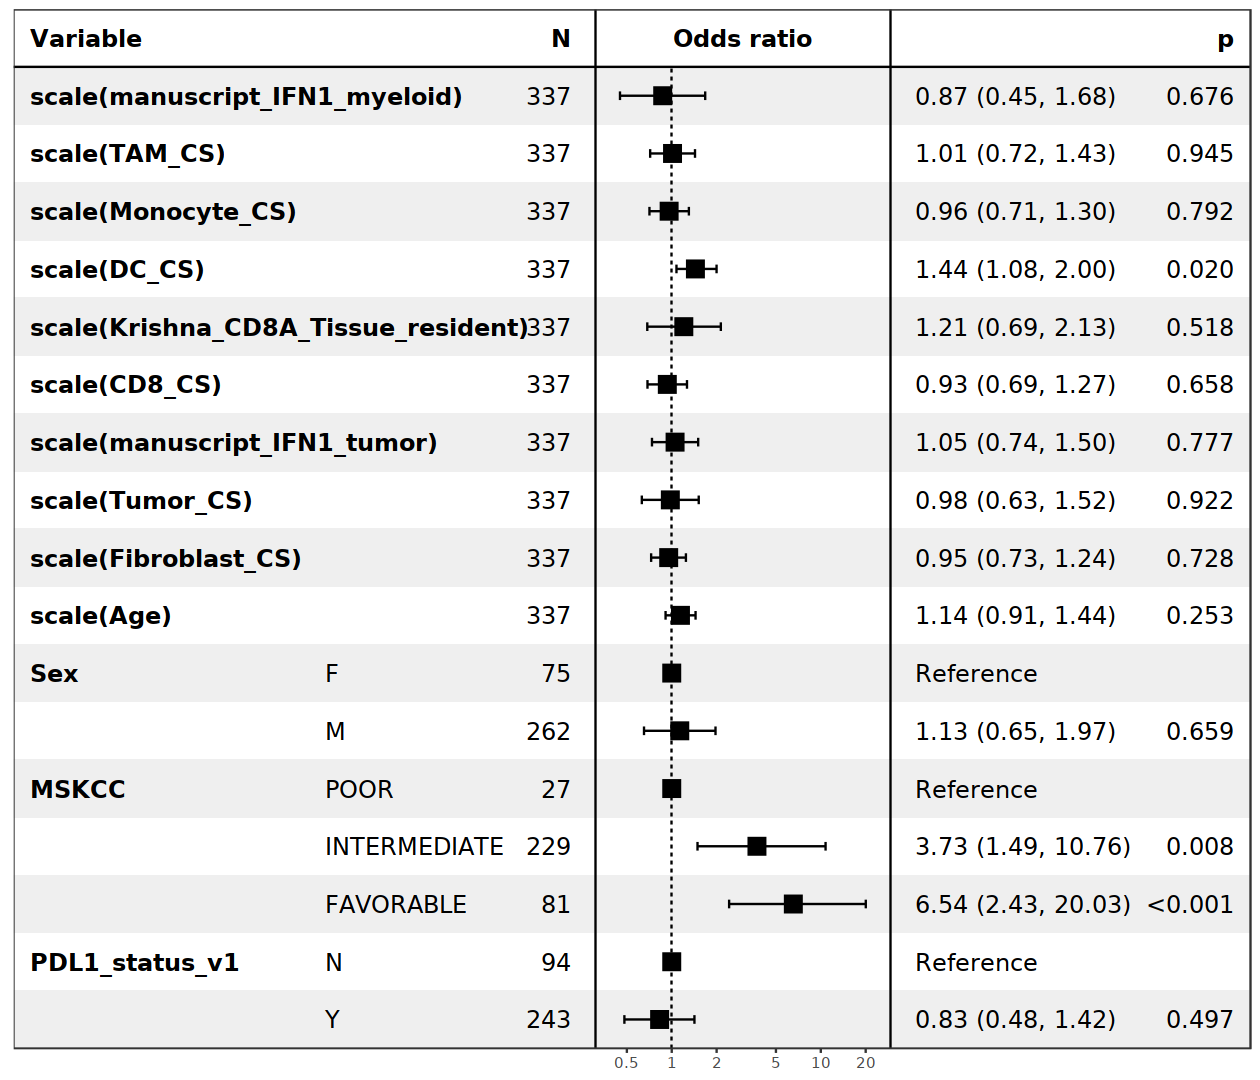

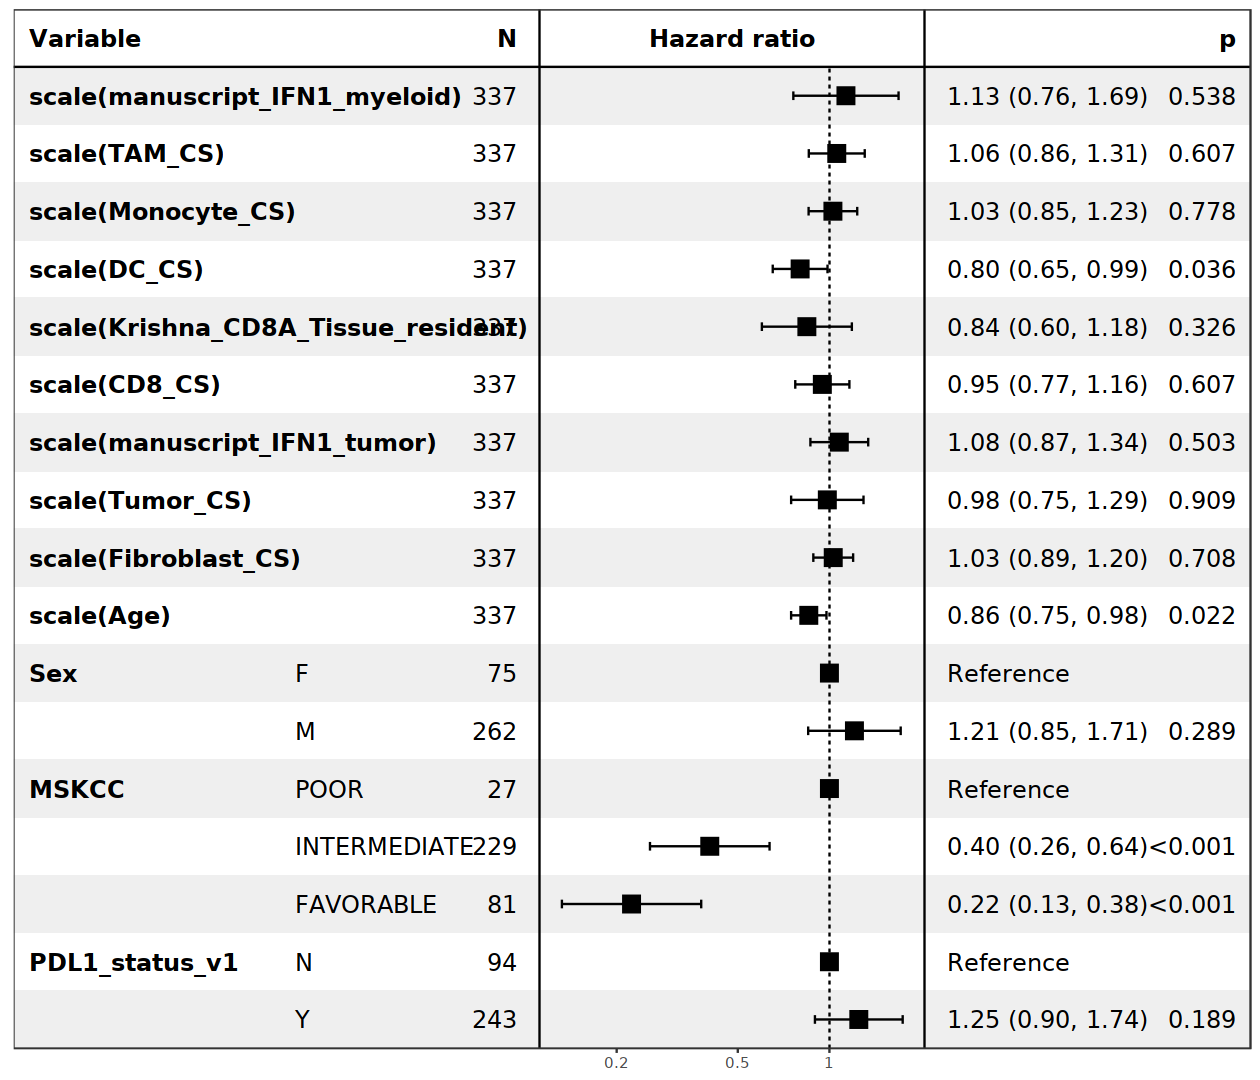

In [102]:
options(repr.plot.width=10.5, repr.plot.height=9)

sunitinib = subset(clin_jav101_full, Arm == "Sunitinib")

sunitinib = subset(sunitinib, ORR %in% c("CR","PD","PR","SD"))
sunitinib = mutate(sunitinib, Benefit = ifelse(ORR == "CR","CB",ifelse(ORR == "PR","CB",ifelse(ORR == "PD","NCB",ifelse(ORR == "SD" & PFS >= 6,"CB","NCB")))))
table(sunitinib$Benefit)

sunitinib = mutate(sunitinib, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~  scale(manuscript_IFN1_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFN1_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, family = "binomial", data = sunitinib)
#summary(mylogit)
vif(mylogit)
jav101_ifn1_lr_tki = forest_model(mylogit, panels_lr,recalculate_width = F)
jav101_ifn1_lr_tki

res.cox <- coxph(Surv(PFS, PFS_CNSR) ~  scale(manuscript_IFN1_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFN1_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, data = sunitinib)
jav101_ifn1_cox_tki = forest_model(res.cox, panels_cox,recalculate_width = F)
jav101_ifn1_cox_tki


### Expanded combined signatures in sunitinib arm


 CB NCB 
182 161 

GVIF     Df GVIF^(1/(2*Df))
scale(manuscript_myeloid_combined)  8.540308 1  2.922381       
scale(TAM_CS)                       2.066425 1  1.437507       
scale(Monocyte_CS)                  1.840570 1  1.356676       
scale(DC_CS)                        1.368853 1  1.169980       
scale(Krishna_CD8A_Tissue_resident) 7.254966 1  2.693504       
scale(CD8_CS)                       1.841374 1  1.356972       
scale(manuscript_tumor_combined)    2.593988 1  1.610586       
scale(Tumor_CS)                     4.095420 1  2.023714       
scale(Fibroblast_CS)                1.548405 1  1.244349       
scale(Age)                          1.027961 1  1.013884       
Sex                                 1.046870 1  1.023167       
MSKCC                               1.078671 2  1.019113       
PDL1_status_v1                      1.172771 1  1.082945

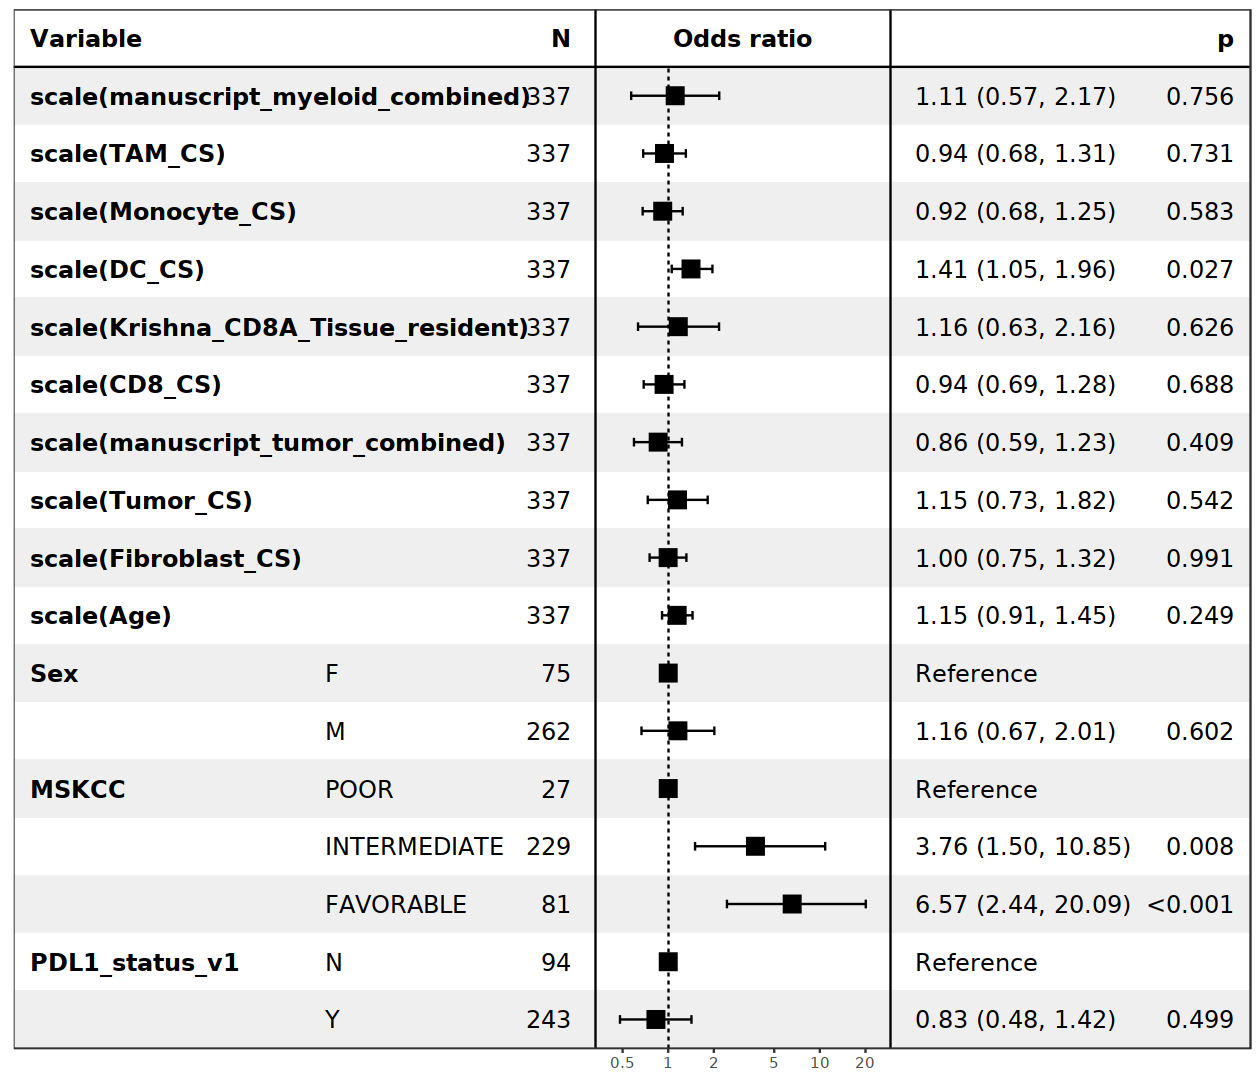

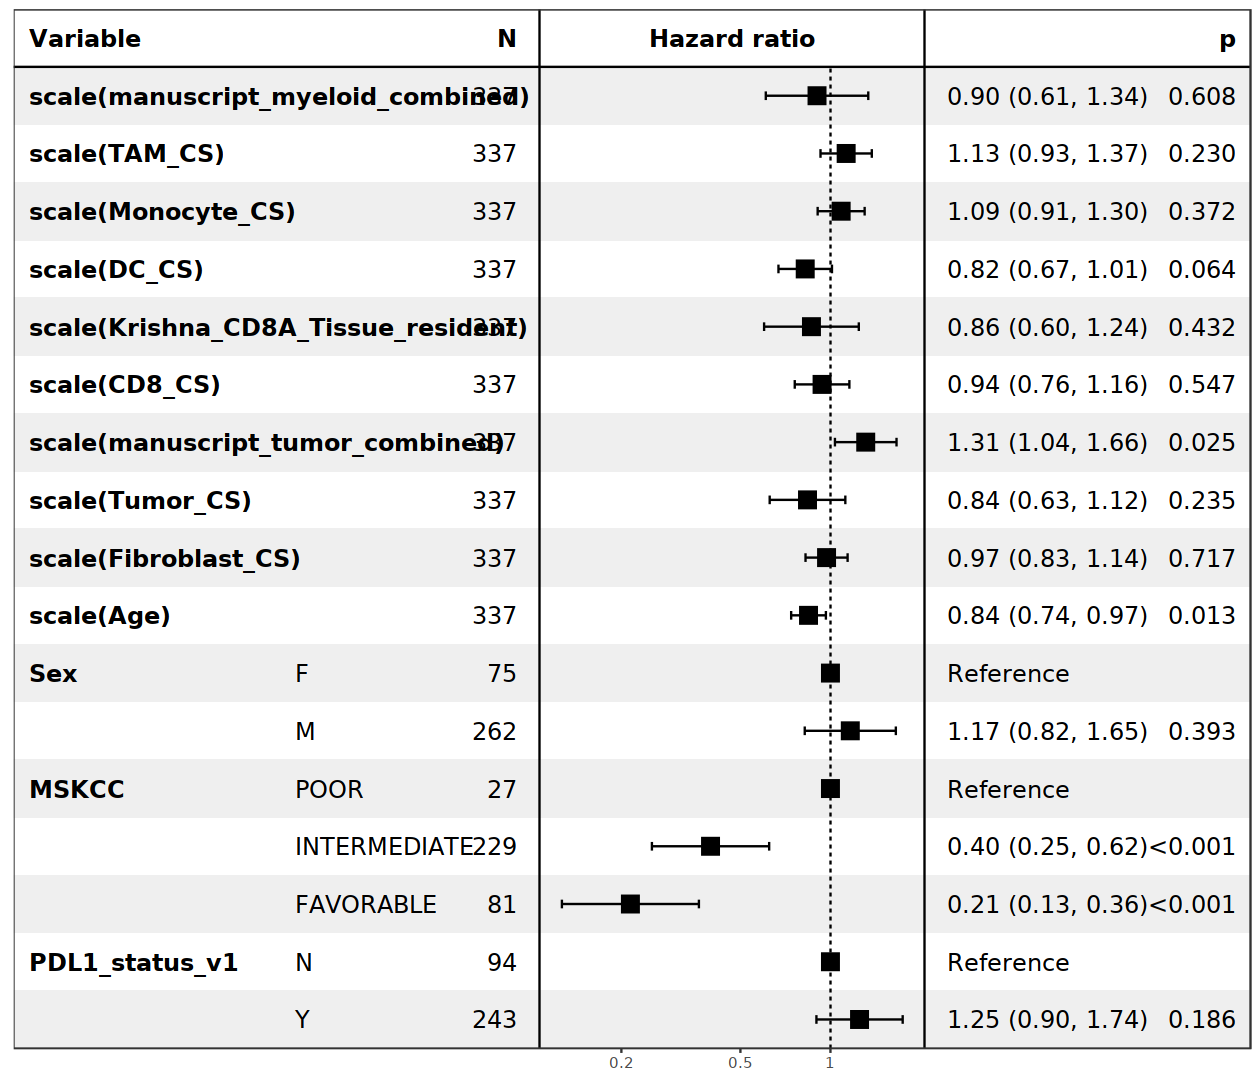

In [103]:
options(repr.plot.width=10.5, repr.plot.height=9)

sunitinib = subset(clin_jav101_full, Arm == "Sunitinib")

sunitinib = subset(sunitinib, ORR %in% c("CR","PD","PR","SD"))
sunitinib = mutate(sunitinib, Benefit = ifelse(ORR == "CR","CB",ifelse(ORR == "PR","CB",ifelse(ORR == "PD","NCB",ifelse(ORR == "SD" & PFS >= 6,"CB","NCB")))))
table(sunitinib$Benefit)

sunitinib = mutate(sunitinib, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~  scale(manuscript_myeloid_combined) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_tumor_combined)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, family = "binomial", data = sunitinib)
#summary(mylogit)
vif(mylogit)
jav101_comb_lr_tki = forest_model(mylogit, panels_lr,recalculate_width = F)
jav101_comb_lr_tki

res.cox <- coxph(Surv(PFS, PFS_CNSR) ~  scale(manuscript_myeloid_combined) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_tumor_combined)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, data = sunitinib)
jav101_comb_cox_tki = forest_model(res.cox, panels_cox,recalculate_width = F)
jav101_comb_cox_tki


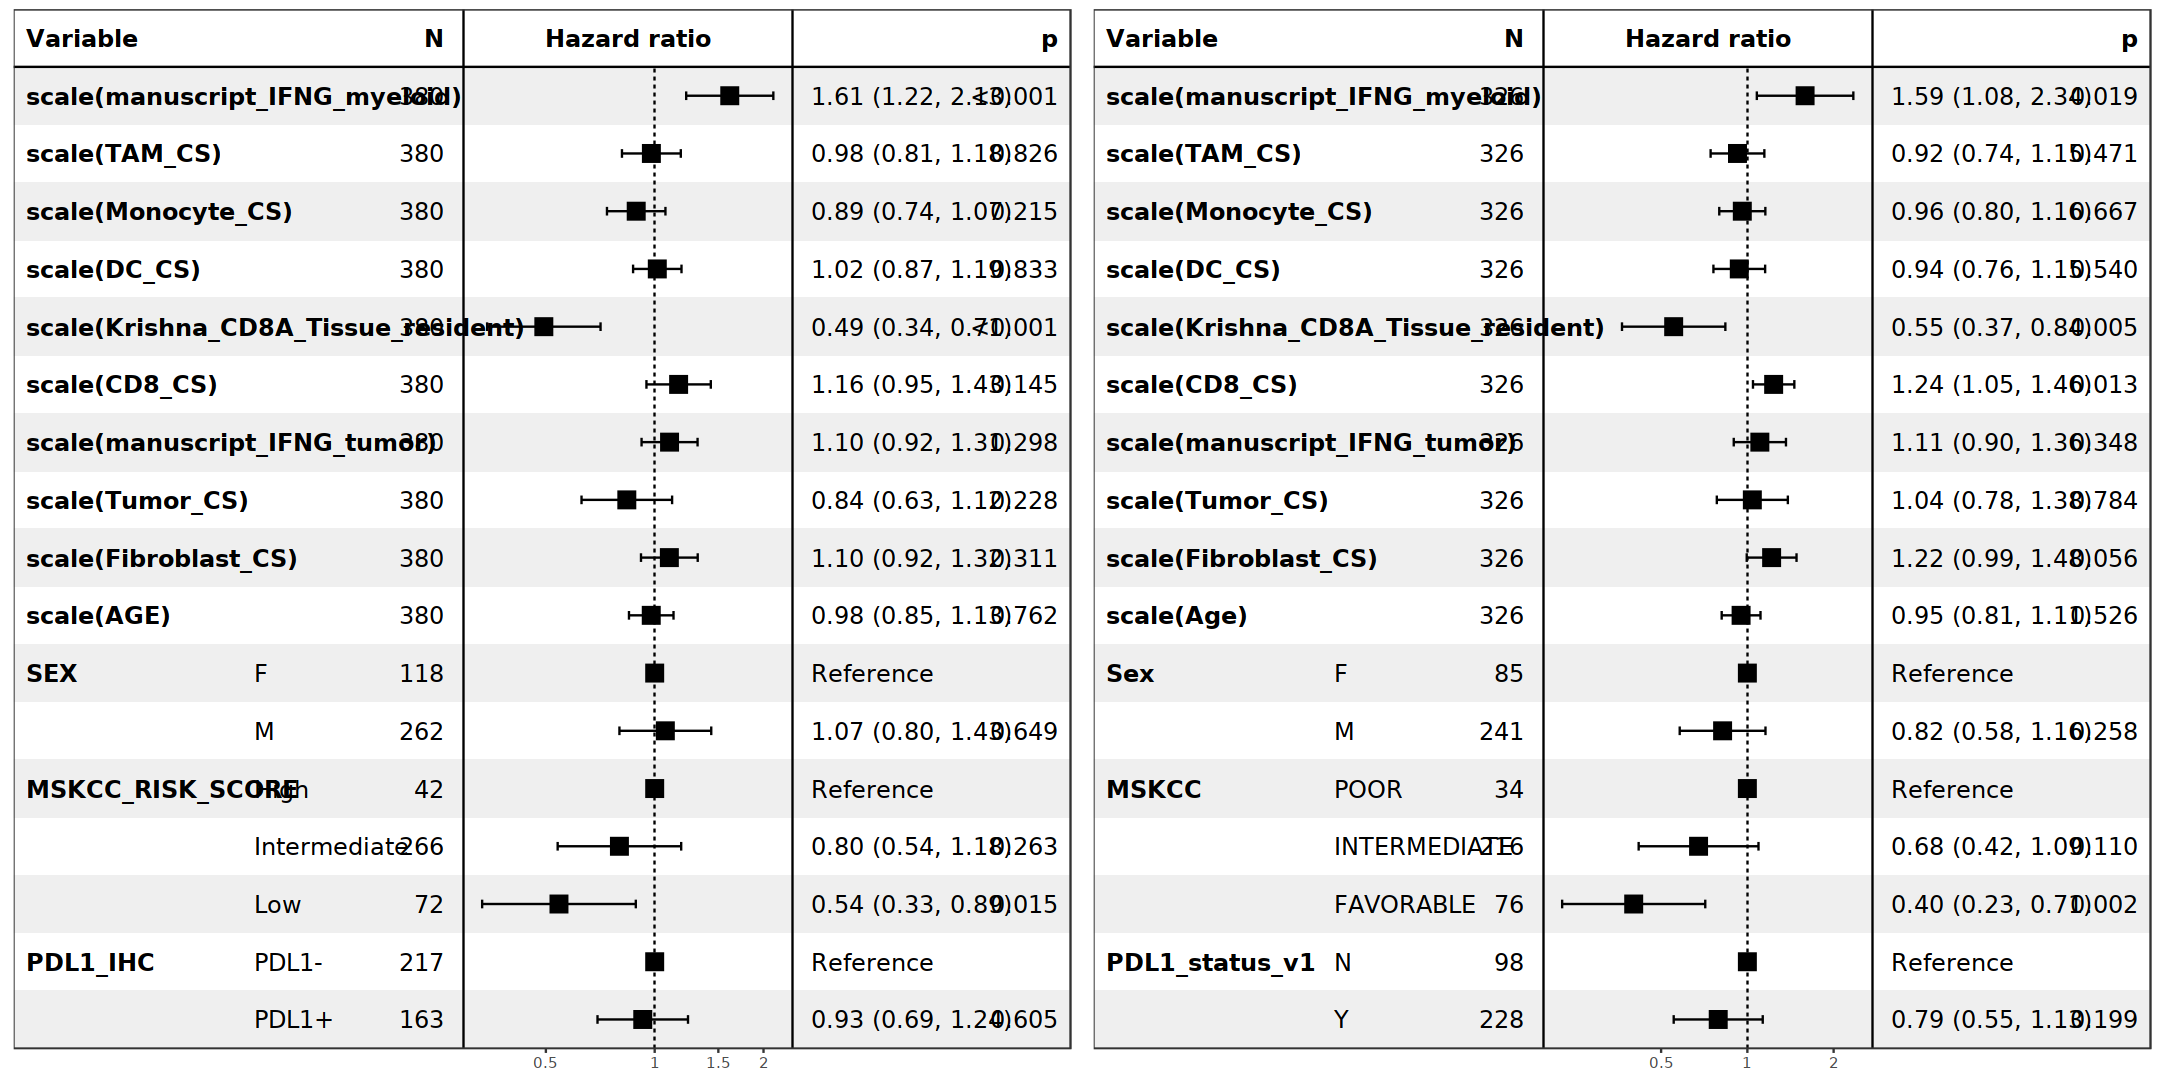

In [104]:
options(repr.plot.width=18, repr.plot.height=9)

ggarrange(imm151_ifng_cox_io, jav101_ifng_cox_io)

ggsave("../../Supp_Figures_Final/Figure_S10/FigureS10G_H_IM151_JR101_Expanded_IFNG_Cox_Forests.pdf",width = 18, height = 9)

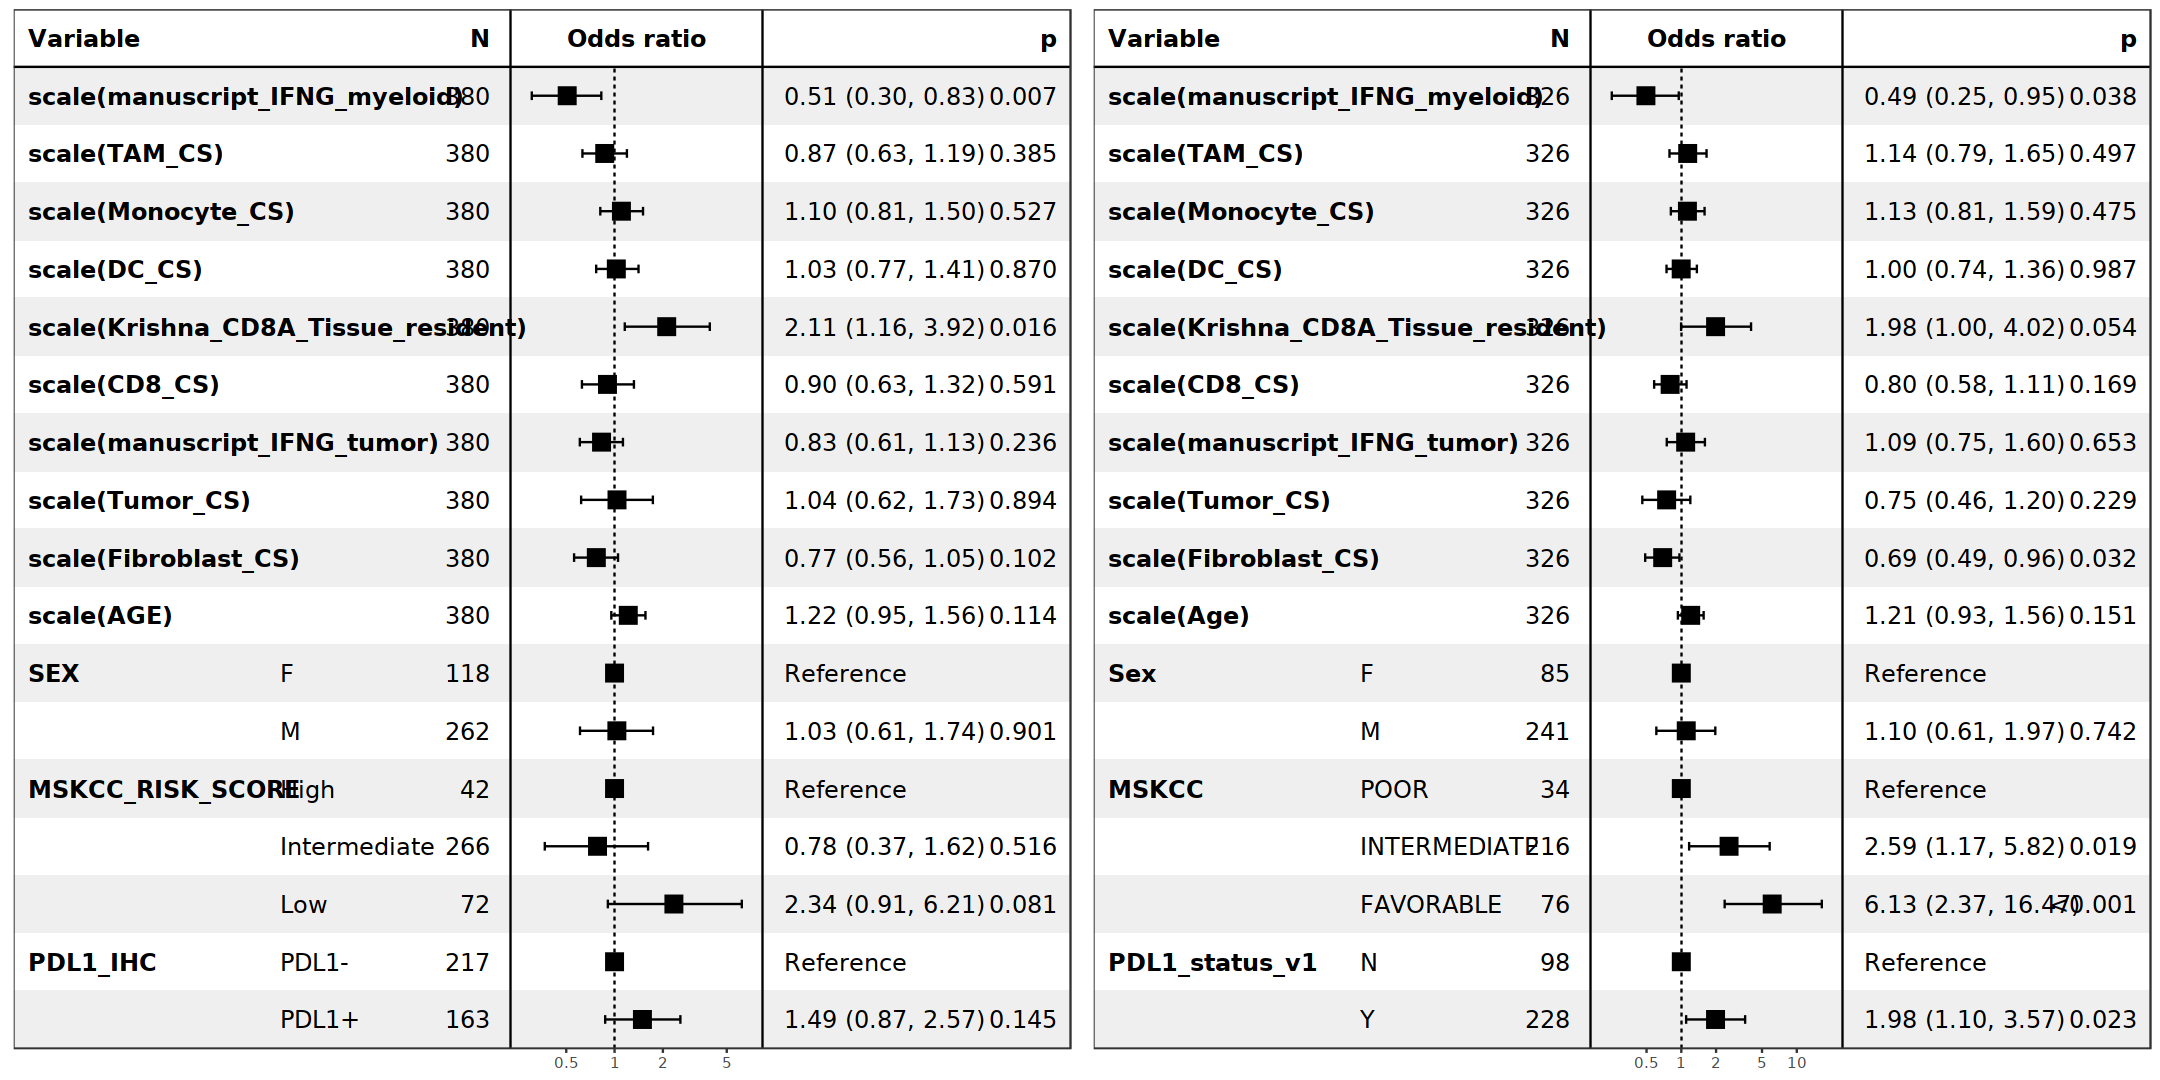

In [105]:
options(repr.plot.width=18, repr.plot.height=9)

ggarrange(imm151_ifng_lr_io, jav101_ifng_lr_io)

ggsave("../../Supp_Figures_Final/Figure_S10/FigureS10I_J_IM151_JR101_Expanded_IFNG_LR_Forests.pdf",width = 18, height = 9)

In [106]:
print(sessionInfo())
print(version)

R version 4.1.0 (2021-05-18)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS:   /usr/lib64/libblas.so.3.4.2
LAPACK: /broad/software/free/Linux/redhat_7_x86_64/pkgs/r_4.1.0/lib64/R/lib/libRlapack.so

locale:
[1] C

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] pROC_1.17.0.1          scales_1.3.0           forestmodel_0.6.2     
 [4] forcats_0.5.2          purrr_0.3.5            readr_2.0.0           
 [7] tidyr_1.2.1            tibble_3.1.8           tidyverse_1.3.1       
[10] survminer_0.4.9.999    survival_3.2-11        yarrr_0.1.5           
[13] circlize_0.4.15        BayesFactor_0.9.12-4.2 coda_0.19-4           
[16] jpeg_0.1-9             broom_1.0.1            magrittr_2.0.3        
[19] ggrastr_1.0.2          pheatmap_1.0.12        ggridges_0.5.4        
[22] hrbrthemes_0.8.0       viridis_0.6.1        